# Bachelorarbeit - Improving Primary Key Detection with Machine Learning
Importing important libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn

from sklearn.model_selection import train_test_split

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score
from sklearn.metrics import log_loss, f1_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold

import random
from itertools import combinations
from collections import Counter
import itertools
import timeit 
import os, glob

import time
import datetime
from IPython.display import clear_output

import re
from xgboost import XGBClassifier
import xgboost

import joblib

#plt.style.use('fivethirtyeight')
#%matplotlib inline
#plt.rcParams['figure.dpi'] = 150
#plt.rcParams['figure.figsize'] = (16,8)

In [2]:
pd.set_option('display.max_rows', 150)


parameters = {'n_jobs': 96}

limit_num_rows_in_og_dataframe = 5  # set to 200_000 if all rows of all the data are wanted

limit_take_all_column_combinations = 9
limit_num_column_combinations = 500   # has to be less than 2^(limit_take_all_column_combinations + 1)

sort_results_by = 'Avg Comp.-Time per Combination'

path_read_data = '../../../data_testing/*.csv'

path_save_dataframe = "dataframe/dataframe.csv"
path_save_models1 = '../training_no_tuples_bigrams_and_bag_of_chars/models/'
path_save_models2 = '.json'
path_save_results = "results/results.csv"
path_save_time = "time/time.csv"
path_save_bow = "../training_no_tuples_bigrams_and_bag_of_chars/bow/"

use_column_names = True
use_column_names_bigrams = True
use_column_names_bag_of_chars = True
use_data_types = True
use_tuples_bigrams = False
use_tuples_bag_of_chars = False

do_saving = True

load_model_instead_of_training = True

### Create new DataFrame with rows for each column combination

In [3]:
def get_list_all_column_combinations(df):
    list_all_column_combinations = []
    max_range = df.shape[1]
    
    if max_range <= limit_take_all_column_combinations:
        combis = range(1, max_range + 1)
        temp = []
    
        for i in range(1, max_range + 1):
            temp.append(list(combinations(combis, i)))
    
        for n in range(len(temp)):
            for elem in temp[n]:
                list_all_column_combinations.append(list(elem))
    
    else:
        attributes_list = range(1, max_range + 1)
        set_chosen_combinations = set()
        counter = 0
    
        #Get different sizes with different propabilities: 1->6%, 2->9%, 3->11%, 4->14%, 5->18%, 6->16%, 7->14%, 8->8%, 8+->4%
        while counter < limit_num_column_combinations:
            random_number = random.random()
    
            if random_number < 0.18:
                num_attributes = 5
            elif random_number < 0.34:
                num_attributes = 6
            elif random_number < 0.48:
                num_attributes = 4
            elif random_number < 0.62:
                num_attributes = 7
            elif random_number < 0.73:
                num_attributes = 3
            elif random_number < 0.82:
                num_attributes = 2
            elif random_number < 0.90:
                num_attributes = 8
            elif random_number < 0.96:
                num_attributes = 1
            else:
                num_attributes = random.choice(attributes_list[8:])
                        
            attribute_tuple = tuple(sorted(random.sample(attributes_list, num_attributes)))
        
            if attribute_tuple not in set_chosen_combinations:
                set_chosen_combinations.add(attribute_tuple)
                counter += 1
    
    
        list_all_column_combinations = [list(elem) for elem in set_chosen_combinations]


    list_all_column_combinations = sorted(list_all_column_combinations, key = lambda i: (len(i), i))
    return list_all_column_combinations

### Create list with True/False for (super)key properties

In [4]:
def get_list_key_properties(df, list_all_column_combinations):
    
    list_column_names = list(df)
    
    #list_set_all_keys = []
    #list_candidate_key_properties = []
    list_superkey_properties = []
    #list_superkey1_properties = []
    #list_superkey2_properties = []
    #list_superkey3_properties = []
    
    for combi in list_all_column_combinations:
        
        #set_combi = set(combi)
    
        #is_possible_candidate_key = True
        #is_superkey1 = False
        #is_superkey2 = False
        #is_superkey3 = False
        
        temp_column_names = []
        
        for attribute in combi:
            temp_column_names.append(list_column_names[attribute - 1])
    
        is_superkey = not df.duplicated(subset = temp_column_names).any()
        list_superkey_properties.append(is_superkey)
        '''
        if is_superkey:
            for elem in list_set_all_keys:
                if elem.issubset(set_combi):
                    if is_possible_candidate_key:
                        list_candidate_key_properties.append(False)
                        is_possible_candidate_key = False
    
                    len_elem = len(elem)
                    len_combi = len(set_combi)
    
                    if len_elem + 1 == len_combi and not is_superkey1:
                        list_superkey1_properties.append(True)
                        is_superkey1 = True
                    elif len_elem + 2 == len_combi and not is_superkey2:
                        list_superkey2_properties.append(True)
                        is_superkey2 = True
                    elif len_elem + 3 == len_combi and not is_superkey3:
                        list_superkey3_properties.append(True)
                        is_superkey3 = True
                    
                    if is_superkey1 and is_superkey2 and is_superkey3:
                        break
    
            if is_possible_candidate_key:
                list_candidate_key_properties.append(True)
                list_set_all_keys.append(set_combi)
    
            if not is_superkey1:
                list_superkey1_properties.append(False)
            if not is_superkey2:
                list_superkey2_properties.append(False)
            if not is_superkey3:
                list_superkey3_properties.append(False)
        
        else:
            list_candidate_key_properties.append(False)
            list_superkey1_properties.append(False)
            list_superkey2_properties.append(False)
            list_superkey3_properties.append(False)'''


    '''return list_candidate_key_properties, list_superkey_properties, list_superkey1_properties,\
    list_superkey2_properties, list_superkey3_properties'''

    return list_superkey_properties

### Create list with concatenated column names

In [5]:
def get_list_column_names_concat(df, list_all_column_combinations):
    list_column_names_concat = []
    list_column_names = list(df)
    
    for combi in list_all_column_combinations:
        concat_one_combi = ""
        for attribute in combi:
            concat_one_combi += list_column_names[attribute - 1] + "Ø"
        concat_one_combi = concat_one_combi[:-1]
        list_column_names_concat.append(concat_one_combi)

    return list_column_names_concat

### Create list with number of columns in the combination

In [6]:
def get_list_number_attributes(df, list_all_column_combinations):
    list_number_attributes = []
    
    for combi in list_all_column_combinations:
        list_number_attributes.append(len(combi))
    
    return list_number_attributes

### Create list with concatenated data types of columns

In [7]:
def get_list_column_dtypes(df, list_all_column_combinations):
    column_dtypes = list(df.dtypes)
    list_column_dtypes = []
    
    for combi in list_all_column_combinations:
        concat_one_combi = ""
        for attribute in combi:
            concat_one_combi += str(column_dtypes[attribute - 1]) + "Ø"
        concat_one_combi = concat_one_combi[:-1]
        list_column_dtypes.append(concat_one_combi)

    return list_column_dtypes

### Create list with total number of colums in original table

In [8]:
def get_list_total_num_columns(df, list_all_column_combinations):
    list_total_num_columns = [len(list(df))] * len(list_all_column_combinations)

    return list_total_num_columns

### Create Concatenation of "n" tuples for each column combination

In [9]:
def get_list_concat_of_content_column(df, list_all_column_combinations):#, amount_tuples):
    list_concat_of_content_column = []
    #list_concat_of_content_row = []

    #if more than <limit_num_rows_in_og_dataframe> rows, take sample of dataframe of <limit_num_rows_in_og_dataframe>
    if df.shape[0] > limit_num_rows_in_og_dataframe:
        df = df.sample(limit_num_rows_in_og_dataframe, random_state = 42)

    
    #sample_for_concat_of_content = df.sample(amount_tuples, random_state = 42)
    
    for combi in list_all_column_combinations:
        concat_content_column = ""
        #concat_content_row = ""
        for attribute in combi:
            concat_content_column += 'Ø'.join(str(x) for x in df.iloc[:, attribute - 1].tolist()) + "Þ"
        concat_content_column = concat_content_column[:-1]
        list_concat_of_content_column.append(concat_content_column)
    
        #temp_combi = [attribute - 1 for attribute in combi]
        #temp_df = sample_for_concat_of_content.iloc[:, temp_combi]
        #for i in range(amount_tuples):
        #    concat_content_row += 'Ø'.join(str(x) for x in temp_df.iloc[i].tolist()) + "Þ"
        #concat_content_row = concat_content_row[:-1]
        #list_concat_of_content_row.append(concat_content_row)

    return list_concat_of_content_column

### Create 49 statistics for number of duplicate entries (count of values) in each column for that combination

In [10]:
def get_49_statistics(list_concat_of_content_column, number_rows):
    max_highest_count_list = []
    avg_highest_count_list = []
    min_highest_count_list = []
    median_highest_count_list = []
    q25_highest_count_list = []
    q75_highest_count_list = []
    diff_values_highest_count_list = []
    
    max_lowest_count_list = []
    avg_lowest_count_list = []
    min_lowest_count_list = []
    median_lowest_count_list = []
    q25_lowest_count_list = []
    q75_lowest_count_list = []
    diff_values_lowest_count_list = []
    
    max_avg_count_list = []
    avg_avg_count_list = []
    min_avg_count_list = []
    median_avg_count_list = []
    q25_avg_count_list = []
    q75_avg_count_list = []
    diff_values_avg_count_list = []
    
    max_median_count_list = []
    avg_median_count_list = []
    min_median_count_list = []
    median_median_count_list = []
    q25_median_count_list = []
    q75_median_count_list = []
    diff_values_median_count_list = []
    
    max_q25_count_list = []
    avg_q25_count_list = []
    min_q25_count_list = []
    median_q25_count_list = []
    q25_q25_count_list = []
    q75_q25_count_list = []
    diff_values_q25_count_list = []
    
    max_q75_count_list = []
    avg_q75_count_list = []
    min_q75_count_list = []
    median_q75_count_list = []
    q25_q75_count_list = []
    q75_q75_count_list = []
    diff_values_q75_count_list = []
    
    max_diff_values_list = []
    avg_diff_values_list = []
    min_diff_values_list = []
    median_diff_values_list = []
    q25_diff_values_list = []
    q75_diff_values_list = []
    diff_values_diff_values_list = []
    
    
    
    for combi in list_concat_of_content_column:
        combi_list = combi.split("Þ")
        
        highest_count_temp = []
        lowest_count_temp = []
        avg_count_temp = []
        median_count_temp = []
        q25_count_temp = []
        q75_count_temp = []
        diff_values_temp = []
        
        for attribute in combi_list:
            attribute_list = attribute.split("Ø")
            counter = Counter(attribute_list)        
            temp_dict = dict(sorted(counter.items(), key=lambda item: item[1], reverse = True))
            values_list = list(temp_dict.values())
            values_list = [elem / number_rows for elem in values_list]
            len_values_list = len(values_list)
    
            np_values_list = np.array(values_list)
            highest_count_temp.append(np_values_list.max())
            lowest_count_temp.append(np_values_list.min())
            avg_count_temp.append(np_values_list.mean())
            median_count_temp.append(np.median(np_values_list))
            q25_count_temp.append(np.quantile(np_values_list, 0.25))
            q75_count_temp.append(np.quantile(np_values_list, 0.75))
            diff_values_temp.append(len_values_list)
    
        np_highest_count_temp = np.array(highest_count_temp)
        max_highest_count_list.append(np_highest_count_temp.max())
        avg_highest_count_list.append(np_highest_count_temp.mean())
        min_highest_count_list.append(np_highest_count_temp.min())
        median_highest_count_list.append(np.median(np_highest_count_temp))
        q25_highest_count_list.append(np.quantile(np_highest_count_temp, 0.25))
        q75_highest_count_list.append(np.quantile(np_highest_count_temp, 0.75))
        diff_values_highest_counter = Counter(highest_count_temp)
        diff_values_highest_temp_dict = dict(sorted(diff_values_highest_counter.items(), key=lambda item: item[1], reverse = True))
        diff_values_highest_list = list(diff_values_highest_temp_dict.values())
        diff_values_highest_count_list.append(len(diff_values_highest_list))
    
        np_lowest_count_temp = np.array(lowest_count_temp)
        max_lowest_count_list.append(np_lowest_count_temp.max())
        avg_lowest_count_list.append(np_lowest_count_temp.mean())
        min_lowest_count_list.append(np_lowest_count_temp.min())
        median_lowest_count_list.append(np.median(np_lowest_count_temp))
        q25_lowest_count_list.append(np.quantile(np_lowest_count_temp, 0.25))
        q75_lowest_count_list.append(np.quantile(np_lowest_count_temp, 0.75))
        diff_values_lowest_counter = Counter(lowest_count_temp)
        diff_values_lowest_temp_dict = dict(sorted(diff_values_lowest_counter.items(), key=lambda item: item[1], reverse = True))
        diff_values_lowest_list = list(diff_values_lowest_temp_dict.values())
        diff_values_lowest_count_list.append(len(diff_values_lowest_list))
    
        np_avg_count_temp = np.array(avg_count_temp)
        max_avg_count_list.append(np_avg_count_temp.max())
        avg_avg_count_list.append(np_avg_count_temp.mean())
        min_avg_count_list.append(np_avg_count_temp.min())
        median_avg_count_list.append(np.median(np_avg_count_temp))
        q25_avg_count_list.append(np.quantile(np_avg_count_temp, 0.25))
        q75_avg_count_list.append(np.quantile(np_avg_count_temp, 0.75))
        diff_values_avg_counter = Counter(avg_count_temp)
        diff_values_avg_temp_dict = dict(sorted(diff_values_avg_counter.items(), key=lambda item: item[1], reverse = True))
        diff_values_avg_list = list(diff_values_avg_temp_dict.values())
        diff_values_avg_count_list.append(len(diff_values_avg_list))
    
        np_median_count_temp = np.array(median_count_temp)
        max_median_count_list.append(np_median_count_temp.max())
        avg_median_count_list.append(np_median_count_temp.mean())
        min_median_count_list.append(np_median_count_temp.min())
        median_median_count_list.append(np.median(np_median_count_temp))
        q25_median_count_list.append(np.quantile(np_median_count_temp, 0.25))
        q75_median_count_list.append(np.quantile(np_median_count_temp, 0.75))
        diff_values_median_counter = Counter(median_count_temp)
        diff_values_median_temp_dict = dict(sorted(diff_values_median_counter.items(), key=lambda item: item[1], reverse = True))
        diff_values_median_list = list(diff_values_median_temp_dict.values())
        diff_values_median_count_list.append(len(diff_values_median_list))
    
        np_q25_count_temp = np.array(q25_count_temp)
        max_q25_count_list.append(np_q25_count_temp.max())
        avg_q25_count_list.append(np_q25_count_temp.mean())
        min_q25_count_list.append(np_q25_count_temp.min())
        median_q25_count_list.append(np.median(np_q25_count_temp))
        q25_q25_count_list.append(np.quantile(np_q25_count_temp, 0.25))
        q75_q25_count_list.append(np.quantile(np_q25_count_temp, 0.75))
        diff_values_q25_counter = Counter(q25_count_temp)
        diff_values_q25_temp_dict = dict(sorted(diff_values_q25_counter.items(), key=lambda item: item[1], reverse = True))
        diff_values_q25_list = list(diff_values_q25_temp_dict.values())
        diff_values_q25_count_list.append(len(diff_values_q25_list))
    
        np_q75_count_temp = np.array(q75_count_temp)
        max_q75_count_list.append(np_q75_count_temp.max())
        avg_q75_count_list.append(np_q75_count_temp.mean())
        min_q75_count_list.append(np_q75_count_temp.min())
        median_q75_count_list.append(np.median(np_q75_count_temp))
        q25_q75_count_list.append(np.quantile(np_q75_count_temp, 0.25))
        q75_q75_count_list.append(np.quantile(np_q75_count_temp, 0.75))
        diff_values_q75_counter = Counter(q75_count_temp)
        diff_values_q75_temp_dict = dict(sorted(diff_values_q75_counter.items(), key=lambda item: item[1], reverse = True))
        diff_values_q75_list = list(diff_values_q75_temp_dict.values())
        diff_values_q75_count_list.append(len(diff_values_q75_list))
    
        np_diff_values_temp = np.array(diff_values_temp)
        max_diff_values_list.append(np_diff_values_temp.max())
        avg_diff_values_list.append(np_diff_values_temp.mean())
        min_diff_values_list.append(np_diff_values_temp.min())
        median_diff_values_list.append(np.median(np_diff_values_temp))
        q25_diff_values_list.append(np.quantile(np_diff_values_temp, 0.25))
        q75_diff_values_list.append(np.quantile(np_diff_values_temp, 0.75))
        diff_values_diff_counter = Counter(diff_values_temp)
        diff_values_diff_temp_dict = dict(sorted(diff_values_diff_counter.items(), key=lambda item: item[1], reverse = True))
        diff_values_diff_list = list(diff_values_diff_temp_dict.values())
        diff_values_diff_values_list.append(len(diff_values_diff_list))
    


    return max_highest_count_list, avg_highest_count_list, min_highest_count_list, median_highest_count_list,\
    q25_highest_count_list, q75_highest_count_list, diff_values_highest_count_list,\
    max_lowest_count_list, avg_lowest_count_list, min_lowest_count_list, median_lowest_count_list,\
    q25_lowest_count_list, q75_lowest_count_list, diff_values_lowest_count_list, \
    max_avg_count_list, avg_avg_count_list, min_avg_count_list, median_avg_count_list, \
    q25_avg_count_list, q75_avg_count_list, diff_values_avg_count_list, \
    max_median_count_list, avg_median_count_list, min_median_count_list, median_median_count_list, \
    q25_median_count_list, q75_median_count_list, diff_values_median_count_list, \
    max_q25_count_list, avg_q25_count_list, min_q25_count_list, median_q25_count_list, \
    q25_q25_count_list, q75_q25_count_list, diff_values_q25_count_list, \
    max_q75_count_list, avg_q75_count_list, min_q75_count_list, median_q75_count_list, \
    q25_q75_count_list, q75_q75_count_list, diff_values_q75_count_list, \
    max_diff_values_list, avg_diff_values_list, min_diff_values_list, median_diff_values_list, \
    q25_diff_values_list, q75_diff_values_list, diff_values_diff_values_list

### Create 4 statistics for NaN count in each column for that combination

In [11]:
def get_4_nan_statistics(list_concat_of_content_column, number_rows):
    nan_count_total = []
    nan_avg_per_attribute = []
    nan_count_highest_in_attribute = []
    nan_count_lowest_in_attribute = []
    
    
    for combi in list_concat_of_content_column:
        combi_list = combi.split("Þ")
        
        nan_count_temp = []
        
        for attribute in combi_list:
            attribute_list = attribute.split("Ø")
            counter = Counter(attribute_list)   
            for key, value in counter.items():
                if key == "nan":
                    nan_count_temp.append(value / number_rows)
                    break
            else:
                nan_count_temp.append(0)
    
        np_nan_count_temp = np.array(nan_count_temp)
        nan_count_total.append(np.sum(np_nan_count_temp))
        nan_avg_per_attribute.append(np.sum(np_nan_count_temp)/len(nan_count_temp))
        nan_count_highest_in_attribute.append(np_nan_count_temp.max())
        nan_count_lowest_in_attribute.append(np_nan_count_temp.min())
    


    return nan_count_total, nan_avg_per_attribute, nan_count_highest_in_attribute, nan_count_lowest_in_attribute

### Create list with average, min and max tuple length in a column

In [12]:
def get_4_tuple_length_statistics(list_concat_of_content_column):
    max_avg_tuple_length_list = []
    avg_avg_tuple_length_list = []
    min_avg_tuple_length_list = []
    total_tuple_length_list = []
    
    for combi in list_concat_of_content_column:
        combi_list = combi.split("Þ")
        
        avg_length_temp = []
        #total_length_temp = []
        
        for attribute in combi_list:
            attribute_list = attribute.split("Ø")
    
            list_with_lengths = [len(elem) for elem in attribute_list]
            mean = np.mean(list_with_lengths)
            #sum = np.sum(list_with_lengths)
            
            avg_length_temp.append(mean)
            #total_length_temp.append(sum)
    
        np_avg_length_temp = np.array(avg_length_temp)
        #np_total_length_temp = np.array(total_length_temp)
        
        max_avg_tuple_length_list.append(np_avg_length_temp.max())
        min_avg_tuple_length_list.append(np_avg_length_temp.min())
        avg_avg_tuple_length_list.append(np_avg_length_temp.mean())
    
        total_tuple_length_list.append(np_avg_length_temp.sum())
    

    return max_avg_tuple_length_list, avg_avg_tuple_length_list, min_avg_tuple_length_list, total_tuple_length_list

### Create bag of words of column names

In [13]:
def get_bag_of_words_column_names(df):
    if use_column_names:
        list_in_lowercase = df["Column Names Concat"].str.lower()

        if load_model_instead_of_training:
            bow = joblib.load(path_save_bow + 'bow_column_names_bag_of_words.joblib') # load and reuse the model
        else:
            bow = CountVectorizer(token_pattern = "[a-zA-Z0-9]+")
            bow.fit(list_in_lowercase)
            if do_saving:
                joblib.dump(bow, path_save_bow + 'bow_column_names_bag_of_words.joblib') # save the model
        
        bow_encoding = pd.DataFrame(
            bow.transform(list_in_lowercase).todense(),
            columns = 'Part of Column Name: ' + bow.get_feature_names_out(),
            index = df.index)
        
        df = df.join(bow_encoding)
        
        df_column_names = bow_encoding
    else:
        df_dummy = df[['Lowest NaN Count in an Attribute']] * 0
        df_dummy[['dummy_column_names_bag_of_words']] = df[['Lowest NaN Count in an Attribute']] * 0
        df_dummy = df_dummy.drop(columns=['Lowest NaN Count in an Attribute'])

        
        df = df.join(df_dummy)
        
        df_column_names = df_dummy




    return df, df_column_names

### Create bigrams of column names

In [14]:
def get_column_names_bigrams(df):
    if use_column_names_bigrams:
        list_in_lowercase = df["Column Names Concat"].str.lower()

        if load_model_instead_of_training:
            bow = joblib.load(path_save_bow + 'bow_column_names_bigrams.joblib') # load and reuse the model
        else:
            bow = CountVectorizer(token_pattern = '[\u0020-\u007E\u2019\u2013\u201d\u201c\u2014\u2026\u2018]{1}', ngram_range = (2, 2))
            bow.fit(list_in_lowercase)
            if do_saving:
                joblib.dump(bow, path_save_bow + 'bow_column_names_bigrams.joblib') # save the model
        
        bow_encoding = pd.DataFrame(
            bow.transform(list_in_lowercase).todense(),
            columns = 'Column Names Bigram: ' + bow.get_feature_names_out(),
            index = df.index)
        
        list_symbols = ['<', '[', ']']
        list_names = list(bow_encoding)
        for elem in list(bow_encoding):
            for symbol in elem:
                if symbol in list_symbols:
                    if 'Column Names Bigram: unknown' in list_names:
                        bow_encoding['Column Names Bigram: unknown'] += bow_encoding[elem]
                    else:
                        bow_encoding['Column Names Bigram: unknown'] = bow_encoding[elem]
                        list_names = list(bow_encoding)
                    bow_encoding = bow_encoding.drop(columns = [elem])
                    break

        
        df = df.join(bow_encoding)
        
        df_column_names_bigrams = bow_encoding
    else:
        df_dummy = df[['Lowest NaN Count in an Attribute']] * 0
        df_dummy[['dummy_column_names_bigrams']] = df[['Lowest NaN Count in an Attribute']] * 0
        df_dummy = df_dummy.drop(columns=['Lowest NaN Count in an Attribute'])

        
        df = df.join(df_dummy)
        
        df_column_names_bigrams = df_dummy



    return df, df_column_names_bigrams

### Create bag of chars for column names

In [15]:
def get_column_names_bag_of_chars(df):
    if use_column_names_bag_of_chars:
        list_in_lowercase = df["Column Names Concat"].str.lower()

        if load_model_instead_of_training:
            bow = joblib.load(path_save_bow + 'bow_column_names_bag_of_chars.joblib') # load and reuse the model
        else:
            bow = CountVectorizer(token_pattern = '[\u0020-\u007E\u2019\u2013\u201d\u201c\u2014\u2026\u2018]{1}')
            bow.fit(list_in_lowercase)
            if do_saving:
                joblib.dump(bow, path_save_bow + 'bow_column_names_bag_of_chars.joblib') # save the model
        
        bow_encoding = pd.DataFrame(
            bow.transform(list_in_lowercase).todense(),
            columns = 'Column Names Char: ' + bow.get_feature_names_out(),
            index = df.index)
        
        list_symbols = ['<', '[', ']']
        list_names = list(bow_encoding)
        for elem in list(bow_encoding):
            for symbol in elem:
                if symbol in list_symbols:
                    if 'Column Names Char: unknown' in list_names:
                        bow_encoding['Column Names Char: unknown'] += bow_encoding[elem]
                    else:
                        bow_encoding['Column Names Char: unknown'] = bow_encoding[elem]
                        list_names = list(bow_encoding)
                    bow_encoding = bow_encoding.drop(columns = [elem])
                    break
                
        
        df = df.join(bow_encoding)
        
        df_column_names_bag_of_chars = bow_encoding
    else:
        df_dummy = df[['Lowest NaN Count in an Attribute']] * 0
        df_dummy[['dummy_column_names_bag_of_chars']] = df[['Lowest NaN Count in an Attribute']] * 0
        df_dummy = df_dummy.drop(columns=['Lowest NaN Count in an Attribute'])

        
        df = df.join(df_dummy)
        
        df_column_names_bag_of_chars = df_dummy




    return df, df_column_names_bag_of_chars

### Create bag of words of data types

In [16]:
def get_bag_of_words_data_types(df):
    if use_data_types:
        list_data_types = df["Data Types Concat"]

        if load_model_instead_of_training:
            bow = joblib.load(path_save_bow + 'bow_data_types.joblib') # load and reuse the model
        else:
            bow = CountVectorizer(token_pattern = "[a-zA-Z0-9]+")
            bow.fit(list_data_types)
            if do_saving:
                joblib.dump(bow, path_save_bow + 'bow_data_types.joblib') # save the model

        bow_encoding = pd.DataFrame(
            bow.transform(list_data_types).todense(),
            columns = 'Data Type: ' + bow.get_feature_names_out(),
            index = df.index)
        df = df.join(bow_encoding)
        
        df_data_types = bow_encoding
    else:
        df_dummy = df[['Lowest NaN Count in an Attribute']] * 0
        df_dummy[['dummy_data_types']] = df[['Lowest NaN Count in an Attribute']] * 0
        df_dummy = df_dummy.drop(columns=['Lowest NaN Count in an Attribute'])

        
        df = df.join(df_dummy)
        
        df_data_types = df_dummy




    return df, df_data_types

### Create bigrams of tuples

In [17]:
def get_tuples_bigrams(df, number_rows):
    if use_tuples_bigrams:
        list_without_delimiters = df["Content of Tuples Concat (column-wise)"]

        if load_model_instead_of_training:
            bow = joblib.load(path_save_bow + 'bow_tuples_bigrams.joblib') # load and reuse the model
        else:
            bow = CountVectorizer(token_pattern = '[\u0020-\u007E\u2019\u2013\u201d\u201c\u2014\u2026\u2018]{1}', lowercase = False, ngram_range = (2, 2))
            bow.fit(list_without_delimiters)
            if do_saving:
                joblib.dump(bow, path_save_bow + 'bow_tuples_bigrams.joblib') # save the model

        bow_encoding = pd.DataFrame(
            bow.transform(list_without_delimiters).todense() / number_rows,
            columns = 'Tuples Bigram: ' + bow.get_feature_names_out(),
            index = df.index)
        
        list_symbols = ['<', '[', ']']
        list_names = list(bow_encoding)
        for elem in list(bow_encoding):
            for symbol in elem:
                if symbol in list_symbols:
                    if 'Tuples Bigram: unknown' in list_names:
                        bow_encoding['Tuples Bigram: unknown'] += bow_encoding[elem]
                    else:
                        bow_encoding['Tuples Bigram: unknown'] = bow_encoding[elem]
                        list_names = list(bow_encoding)
                    bow_encoding = bow_encoding.drop(columns = [elem])
                    break

        
        df = df.join(bow_encoding)
        
        df_tuples_bigrams = bow_encoding
    else:
        df_dummy = df[['Lowest NaN Count in an Attribute']] * 0
        df_dummy[['dummy_tuples_bigrams']] = df[['Lowest NaN Count in an Attribute']] * 0
        df_dummy = df_dummy.drop(columns=['Lowest NaN Count in an Attribute'])

        
        df = df.join(df_dummy)
        
        df_tuples_bigrams = df_dummy




    return df, df_tuples_bigrams

### Create bag of chars for tuples

In [18]:
def get_tuples_bag_of_chars(df, number_rows):
    if use_tuples_bag_of_chars:
        list_without_delimiters = df["Content of Tuples Concat (column-wise)"]

        if load_model_instead_of_training:
            bow = joblib.load(path_save_bow + 'bow_tuples_bag_of_chars.joblib') # load and reuse the model
        else:
            bow = CountVectorizer(token_pattern = '[\u0020-\u007E\u2019\u2013\u201d\u201c\u2014\u2026\u2018]{1}', lowercase = False)
            bow.fit(list_without_delimiters)
            if do_saving:
                joblib.dump(bow, path_save_bow + 'bow_tuples_bag_of_chars.joblib') # save the model

        bow_encoding = pd.DataFrame(
            bow.transform(list_without_delimiters).todense() / number_rows,
            columns = 'Tuples Char: ' + bow.get_feature_names_out(),
            index = df.index)

        list_symbols = ['<', '[', ']']
        list_names = list(bow_encoding)
        for elem in list(bow_encoding):
            for symbol in elem:
                if symbol in list_symbols:
                    if 'Tuples Char: unknown' in list_names:
                        bow_encoding['Tuples Char: unknown'] += bow_encoding[elem]
                    else:
                        bow_encoding['Tuples Char: unknown'] = bow_encoding[elem]
                        list_names = list(bow_encoding)
                    bow_encoding = bow_encoding.drop(columns = [elem])
                    break
        
        df = df.join(bow_encoding)
        
        df_tuples_bag_of_chars = bow_encoding
    else:
        df_dummy = df[['Lowest NaN Count in an Attribute']] * 0
        df_dummy[['dummy_tuples_bag_of_chars']] = df[['Lowest NaN Count in an Attribute']] * 0
        df_dummy = df_dummy.drop(columns=['Lowest NaN Count in an Attribute'])

        
        df = df.join(df_dummy)
        
        df_tuples_bag_of_chars = df_dummy




    return df, df_tuples_bag_of_chars

### ----------------------------------------------------------------------------------------------------------------------

# Iterate over all .csv files in folder 'data' in current directory

In [19]:
list_all_column_combinations = []

#list_candidate_key_properties = []
list_superkey_properties = []
#list_superkey1_properties = []
#list_superkey2_properties = []
#list_superkey3_properties = []

list_column_names_concat = []
list_number_attributes = []
list_column_dtypes = []
list_total_num_columns = []
list_concat_of_content_column = []

max_highest_count_list = []
avg_highest_count_list = []
min_highest_count_list = []
median_highest_count_list = []
q25_highest_count_list = []
q75_highest_count_list = []
diff_values_highest_count_list = []

max_lowest_count_list = []
avg_lowest_count_list = []
min_lowest_count_list = []
median_lowest_count_list = []
q25_lowest_count_list = []
q75_lowest_count_list = []
diff_values_lowest_count_list = []

max_avg_count_list = []
avg_avg_count_list = []
min_avg_count_list = []
median_avg_count_list = []
q25_avg_count_list = []
q75_avg_count_list = []
diff_values_avg_count_list = []

max_median_count_list = []
avg_median_count_list = []
min_median_count_list = []
median_median_count_list = []
q25_median_count_list = []
q75_median_count_list = []
diff_values_median_count_list = []

max_q25_count_list = []
avg_q25_count_list = []
min_q25_count_list = []
median_q25_count_list = []
q25_q25_count_list = []
q75_q25_count_list = []
diff_values_q25_count_list = []

max_q75_count_list = []
avg_q75_count_list = []
min_q75_count_list = []
median_q75_count_list = []
q25_q75_count_list = []
q75_q75_count_list = []
diff_values_q75_count_list = []

max_diff_values_list = []
avg_diff_values_list = []
min_diff_values_list = []
median_diff_values_list = []
q25_diff_values_list = []
q75_diff_values_list = []
diff_values_diff_values_list = []

nan_count_total = []
nan_avg_per_attribute = []
nan_count_highest_in_attribute = []
nan_count_lowest_in_attribute = []

max_avg_tuple_length_list = []
avg_avg_tuple_length_list = []
min_avg_tuple_length_list = []
total_tuple_length_list = []
####################

#amount_of_tuples = 5

####################
times_all_column_combinations = []
times_superkey_properties = []
times_column_names_concat = []
times_number_attributes = []
times_column_dtypes = []
times_total_num_columns = []
times_concat_of_content_column = []
times_49_statistics = []
times_4_nan_statistics = []
times_4_tuple_length_statistics = []

times_creation_df_number_attributes = []
times_creation_df_total_num_columns = []
times_creation_df_49_statistics = []
times_creation_df_4_nan_statistics = []
times_creation_df_4_tuple_length_statistics = []
times_creation_df_total_tuple_length = []
times_creation_df_avg_avg_tuple_length = []
times_creation_new_df = []
times_creation_df_attribute_percentage = []
times_creation_df_tuple_length_per_column_average = []

times_column_names_bag_of_words = []
times_column_names_bigrams = []
times_column_names_bag_of_chars = []
times_data_types_bag_of_words = []
times_tuples_bigrams = []
times_tuples_bag_of_chars = []
####################


####################
num_file = 0
df_time = pd.DataFrame(columns = ['Total time for computation'])

start_time = datetime.datetime.now()
####################


for filename in glob.glob(path_read_data):
    df_original = pd.read_csv(filename, sep = None, engine = 'python', on_bad_lines = 'skip', encoding = 'utf-8-sig')

    #check if data frame has too few tuples and if yes then skip it
    #if df_original.shape[0] < amount_of_tuples:
    #    continue

    ####################
    #print current state of the program
    num_file += 1
    print(f'Currently at file number {num_file}: {filename}, started at {datetime.datetime.now()}')
    ####################


    ####################
    #number of rows in df_original or <limit_num_rows_in_og_dataframe>, to normalize
    if df_original.shape[0] > limit_num_rows_in_og_dataframe:
        number_rows = limit_num_rows_in_og_dataframe
    else:
        number_rows = df_original.shape[0]
    ####################


    ####################
    start_of_computation = time.time()
    #compute column combinations
    list_all_column_combinations_temp = get_list_all_column_combinations(df_original)
    end_of_computation = time.time()
    times_all_column_combinations.append(end_of_computation - start_of_computation)
    ####################


    ####################
    #get (super)key properties
    start_of_computation = time.time()
    '''list_candidate_key_properties_temp, list_superkey_properties_temp, list_superkey1_properties_temp, \
    list_superkey2_properties_temp, list_superkey3_properties_temp = get_list_key_properties(df_original, \
                                                                                             list_all_column_combinations_temp)'''
    list_superkey_properties_temp = get_list_key_properties(df_original, list_all_column_combinations_temp)
    end_of_computation = time.time()
    times_superkey_properties.append(end_of_computation - start_of_computation)
    ####################


    ####################
    start_of_computation = time.time()
    #concatenation of column names
    list_column_names_concat_temp = get_list_column_names_concat(df_original, list_all_column_combinations_temp)
    end_of_computation = time.time()
    times_column_names_concat.append(end_of_computation - start_of_computation)
    ####################


    ####################
    start_of_computation = time.time()
    #number of columns in combination
    list_number_attributes_temp= get_list_number_attributes(df_original, list_all_column_combinations_temp)
    end_of_computation = time.time()
    times_number_attributes.append(end_of_computation - start_of_computation)
    ####################


    ####################
    start_of_computation = time.time()
    #concatenation of column data types
    list_column_dtypes_temp = get_list_column_dtypes(df_original, list_all_column_combinations_temp)
    end_of_computation = time.time()
    times_column_dtypes.append(end_of_computation - start_of_computation)
    ####################


    ####################
    start_of_computation = time.time()
    #total number of columns in original table
    list_total_num_columns_temp = get_list_total_num_columns(df_original, list_all_column_combinations_temp)
    end_of_computation = time.time()
    times_total_num_columns.append(end_of_computation - start_of_computation)
    ####################


    ####################
    start_of_computation = time.time()
    #concatenation of n tuples
    list_concat_of_content_column_temp = get_list_concat_of_content_column(df_original, list_all_column_combinations_temp)#, \
    #                                                                       amount_tuples = amount_of_tuples)
    end_of_computation = time.time()
    times_concat_of_content_column.append(end_of_computation - start_of_computation)
    ####################


    ####################
    start_of_computation = time.time()
    #compute the 49 statistics
    max_highest_count_list_temp, avg_highest_count_list_temp, min_highest_count_list_temp, median_highest_count_list_temp,\
    q25_highest_count_list_temp, q75_highest_count_list_temp, diff_values_highest_count_list_temp,\
    max_lowest_count_list_temp, avg_lowest_count_list_temp, min_lowest_count_list_temp, median_lowest_count_list_temp,\
    q25_lowest_count_list_temp, q75_lowest_count_list_temp, diff_values_lowest_count_list_temp, \
    max_avg_count_list_temp, avg_avg_count_list_temp, min_avg_count_list_temp, median_avg_count_list_temp, \
    q25_avg_count_list_temp, q75_avg_count_list_temp, diff_values_avg_count_list_temp, \
    max_median_count_list_temp, avg_median_count_list_temp, min_median_count_list_temp, median_median_count_list_temp, \
    q25_median_count_list_temp, q75_median_count_list_temp, diff_values_median_count_list_temp, \
    max_q25_count_list_temp, avg_q25_count_list_temp, min_q25_count_list_temp, median_q25_count_list_temp, \
    q25_q25_count_list_temp, q75_q25_count_list_temp, diff_values_q25_count_list_temp, \
    max_q75_count_list_temp, avg_q75_count_list_temp, min_q75_count_list_temp, median_q75_count_list_temp, \
    q25_q75_count_list_temp, q75_q75_count_list_temp, diff_values_q75_count_list_temp, \
    max_diff_values_list_temp, avg_diff_values_list_temp, min_diff_values_list_temp, median_diff_values_list_temp, \
    q25_diff_values_list_temp, q75_diff_values_list_temp, diff_values_diff_values_list_temp, \
    = get_49_statistics(list_concat_of_content_column_temp, number_rows)
    end_of_computation = time.time()
    times_49_statistics.append(end_of_computation - start_of_computation)
    ####################


    ####################
    start_of_computation = time.time()
    #compute the 4 statistics for NaN Count
    nan_count_total_temp, nan_avg_per_attribute_temp, nan_count_highest_in_attribute_temp, nan_count_lowest_in_attribute_temp,\
    = get_4_nan_statistics(list_concat_of_content_column_temp, number_rows)
    end_of_computation = time.time()
    times_4_nan_statistics.append(end_of_computation - start_of_computation)
    ####################


    ####################
    start_of_computation = time.time()
    #compute the 4 tuple length statistics
    max_avg_tuple_length_list_temp, avg_avg_tuple_length_list_temp, min_avg_tuple_length_list_temp, total_tuple_length_list_temp,\
    = get_4_tuple_length_statistics(list_concat_of_content_column_temp)
    end_of_computation = time.time()
    times_4_tuple_length_statistics.append(end_of_computation - start_of_computation)
    ####################




    ####################
    #add lists together
    list_all_column_combinations.extend(list_all_column_combinations_temp)

    #list_candidate_key_properties.extend(list_candidate_key_properties_temp)
    list_superkey_properties.extend(list_superkey_properties_temp)
    #list_superkey1_properties.extend(list_superkey1_properties_temp)
    #list_superkey2_properties.extend(list_superkey2_properties_temp)
    #list_superkey3_properties.extend(list_superkey3_properties_temp)
    
    list_column_names_concat.extend(list_column_names_concat_temp)
    list_number_attributes.extend(list_number_attributes_temp)
    list_column_dtypes.extend(list_column_dtypes_temp)
    list_total_num_columns.extend(list_total_num_columns_temp)
    list_concat_of_content_column.extend(list_concat_of_content_column_temp)
    
    max_highest_count_list.extend(max_highest_count_list_temp)
    avg_highest_count_list.extend(avg_highest_count_list_temp)
    min_highest_count_list.extend(min_highest_count_list_temp)
    median_highest_count_list.extend(median_highest_count_list_temp)
    q25_highest_count_list.extend(q25_highest_count_list_temp)
    q75_highest_count_list.extend(q75_highest_count_list_temp)
    diff_values_highest_count_list.extend(diff_values_highest_count_list_temp)
    
    max_lowest_count_list.extend(max_lowest_count_list_temp)
    avg_lowest_count_list.extend(avg_lowest_count_list_temp)
    min_lowest_count_list.extend(min_lowest_count_list_temp)
    median_lowest_count_list.extend(median_lowest_count_list_temp)
    q25_lowest_count_list.extend(q25_lowest_count_list_temp)
    q75_lowest_count_list.extend(q75_lowest_count_list_temp)
    diff_values_lowest_count_list.extend(diff_values_lowest_count_list_temp)
    
    max_avg_count_list.extend(max_avg_count_list_temp)
    avg_avg_count_list.extend(avg_avg_count_list_temp)
    min_avg_count_list.extend(min_avg_count_list_temp)
    median_avg_count_list.extend(median_avg_count_list_temp)
    q25_avg_count_list.extend(q25_avg_count_list_temp)
    q75_avg_count_list.extend(q75_avg_count_list_temp)
    diff_values_avg_count_list.extend(diff_values_avg_count_list_temp)
    
    max_median_count_list.extend(max_median_count_list_temp)
    avg_median_count_list.extend(avg_median_count_list_temp)
    min_median_count_list.extend(min_median_count_list_temp)
    median_median_count_list.extend(median_median_count_list_temp)
    q25_median_count_list.extend(q25_median_count_list_temp)
    q75_median_count_list.extend(q75_median_count_list_temp)
    diff_values_median_count_list.extend(diff_values_median_count_list_temp)
    
    max_q25_count_list.extend(max_q25_count_list_temp)
    avg_q25_count_list.extend(avg_q25_count_list_temp)
    min_q25_count_list.extend(min_q25_count_list_temp)
    median_q25_count_list.extend(median_q25_count_list_temp)
    q25_q25_count_list.extend(q25_q25_count_list_temp)
    q75_q25_count_list.extend(q75_q25_count_list_temp)
    diff_values_q25_count_list.extend(diff_values_q25_count_list_temp)
    
    max_q75_count_list.extend(max_q75_count_list_temp)
    avg_q75_count_list.extend(avg_q75_count_list_temp)
    min_q75_count_list.extend(min_q75_count_list_temp)
    median_q75_count_list.extend(median_q75_count_list_temp)
    q25_q75_count_list.extend(q25_q75_count_list_temp)
    q75_q75_count_list.extend(q75_q75_count_list_temp)
    diff_values_q75_count_list.extend(diff_values_q75_count_list_temp)
    
    max_diff_values_list.extend(max_diff_values_list_temp)
    avg_diff_values_list.extend(avg_diff_values_list_temp)
    min_diff_values_list.extend(min_diff_values_list_temp)
    median_diff_values_list.extend(median_diff_values_list_temp)
    q25_diff_values_list.extend(q25_diff_values_list_temp)
    q75_diff_values_list.extend(q75_diff_values_list_temp)
    diff_values_diff_values_list.extend(diff_values_diff_values_list_temp)
    
    nan_count_total.extend(nan_count_total_temp)
    nan_avg_per_attribute.extend(nan_avg_per_attribute_temp)
    nan_count_highest_in_attribute.extend(nan_count_highest_in_attribute_temp)
    nan_count_lowest_in_attribute.extend(nan_count_lowest_in_attribute_temp)
    
    max_avg_tuple_length_list.extend(max_avg_tuple_length_list_temp)
    avg_avg_tuple_length_list.extend(avg_avg_tuple_length_list_temp)
    min_avg_tuple_length_list.extend(min_avg_tuple_length_list_temp)
    total_tuple_length_list.extend(total_tuple_length_list_temp)

    clear_output(wait = True)
    ####################


####################
times_all_column_combinations = [sum(times_all_column_combinations)]
times_superkey_properties = [sum(times_superkey_properties)]
times_column_names_concat = [sum(times_column_names_concat)]
times_number_attributes = [sum(times_number_attributes)]
times_column_dtypes = [sum(times_column_dtypes)]
times_total_num_columns = [sum(times_total_num_columns)]
times_concat_of_content_column = [sum(times_concat_of_content_column)]
times_49_statistics = [sum(times_49_statistics)]
times_4_nan_statistics = [sum(times_4_nan_statistics)]
times_4_tuple_length_statistics = [sum(times_4_tuple_length_statistics)]
####################


####################
end_time = datetime.datetime.now()
df_time.loc['Reading Data'] = end_time - start_time
display(df_time)
####################


####################
start_of_computation = time.time()
df_number_attributes = pd.DataFrame({
    'Number of Attributs in Combination': list_number_attributes})
end_of_computation = time.time()
times_creation_df_number_attributes.append(end_of_computation - start_of_computation)
####################


####################
start_of_computation = time.time()
df_total_num_columns = pd.DataFrame({
    'Total Number of Attributs in Original Table': list_total_num_columns})
end_of_computation = time.time()
times_creation_df_total_num_columns.append(end_of_computation - start_of_computation)
####################


####################
start_of_computation = time.time()
df_49_statistics = pd.DataFrame({
    'Maximum of highest Count in each Attribute': max_highest_count_list,
    'Average of highest Count in each Attribute': avg_highest_count_list,
    'Minimum of highest Count in each Attribute': min_highest_count_list,
    'Median of highest Count in each Attribute': median_highest_count_list,
    'Q25 of highest Count in each Attribute': q25_highest_count_list,
    'Q75 of highest Count in each Attribute': q75_highest_count_list,
    'Different Values of highest Count in each Attribute': diff_values_highest_count_list,
    'Maximum of lowest Count in each Attribute': max_lowest_count_list,
    'Average of lowest Count in each Attribute': avg_lowest_count_list,
    'Minimum of lowest Count in each Attribute': min_lowest_count_list,
    'Median of lowest Count in each Attribute': median_lowest_count_list,
    'Q25 of lowest Count in each Attribute': q25_lowest_count_list,
    'Q75 of lowest Count in each Attribute': q75_lowest_count_list,
    'Different Values of lowest Count in each Attribute': diff_values_lowest_count_list,
    'Maximum of average Count in each Attribute': max_avg_count_list,
    'Average of average Count in each Attribute': avg_avg_count_list,
    'Minimum of average Count in each Attribute': min_avg_count_list,
    'Median of average Count in each Attribute': median_avg_count_list,
    'Q25 of average Count in each Attribute': q25_avg_count_list,
    'Q75 of average Count in each Attribute': q75_avg_count_list,
    'Different Values of average Count in each Attribute': diff_values_avg_count_list,
    'Maximum of Median Count in each Attribute': max_median_count_list,
    'Average of Median Count in each Attribute': avg_median_count_list,
    'Minimum of Median Count in each Attribute': min_median_count_list,
    'Median of Median Count in each Attribute': median_median_count_list,
    'Q25 of Median Count in each Attribute': q25_median_count_list,
    'Q75 of Median Count in each Attribute': q75_median_count_list,
    'Different Values of Median Count in each Attribute': diff_values_median_count_list,
    'Maximum of Q25 Count in each Attribute': max_q25_count_list,
    'Average of Q25 Count in each Attribute': avg_q25_count_list,
    'Minimum of Q25 Count in each Attribute': min_q25_count_list,
    'Median of Q25 Count in each Attribute': median_q25_count_list,
    'Q25 of Q25 Count in each Attribute': q25_q25_count_list,
    'Q75 of Q25 Count in each Attribute': q75_q25_count_list,
    'Different Values of Q25 Count in each Attribute': diff_values_q25_count_list,
    'Maximum of Q75 Count in each Attribute': max_q75_count_list,
    'Average of Q75 Count in each Attribute': avg_q75_count_list,
    'Minimum of Q75 Count in each Attribute': min_q75_count_list,
    'Median of Q75 Count in each Attribute': median_q75_count_list,
    'Q25 of Q75 Count in each Attribute': q25_q75_count_list,
    'Q75 of Q75 Count in each Attribute': q75_q75_count_list,
    'Different Values of Q75 Count in each Attribute': diff_values_q75_count_list,
    'Maximum of Different Values in each Attribute': max_diff_values_list,
    'Average of Different Values in each Attribute': avg_diff_values_list,
    'Minimum of Different Values in each Attribute': min_diff_values_list,
    'Median of Different Values in each Attribute': median_diff_values_list,
    'Q25 of Different Values in each Attribute': q25_diff_values_list,
    'Q75 of Different Values in each Attribute': q75_diff_values_list,
    'Different Values of Different Values in each Attribute': diff_values_diff_values_list})
end_of_computation = time.time()
times_creation_df_49_statistics.append(end_of_computation - start_of_computation)
####################


####################
start_of_computation = time.time()
df_4_nan_statistics = pd.DataFrame({
    'Total NaN Count in all Attributes': nan_count_total,
    'Average NaN per Attribute': nan_avg_per_attribute,
    'Highest NaN Count in an Attribute': nan_count_highest_in_attribute,
    'Lowest NaN Count in an Attribute': nan_count_lowest_in_attribute})
end_of_computation = time.time()
times_creation_df_4_nan_statistics.append(end_of_computation - start_of_computation)
####################


####################
start_of_computation = time.time()
df_4_tuple_length_statistics = pd.DataFrame({
    'Maximum of Average Tuple Length in a Column': max_avg_tuple_length_list,
    'Minimum of Average Tuple Length in a Column': min_avg_tuple_length_list,
    'Average of Average Tuple Length in a Column': avg_avg_tuple_length_list,
    'Total Length across all the Columns': total_tuple_length_list})
end_of_computation = time.time()
times_creation_df_4_tuple_length_statistics.append(end_of_computation - start_of_computation)
####################


####################
start_of_computation = time.time()
df_total_tuple_length = df_4_tuple_length_statistics[['Total Length across all the Columns']]
end_of_computation = time.time()
times_creation_df_total_tuple_length.append(end_of_computation - start_of_computation)
####################


####################
start_of_computation = time.time()
df_avg_avg_tuple_length = df_4_tuple_length_statistics[['Average of Average Tuple Length in a Column']]
end_of_computation = time.time()
times_creation_df_avg_avg_tuple_length.append(end_of_computation - start_of_computation)
####################




####################
start_of_computation = time.time()
new_df = pd.DataFrame(
    {'Column Combination': list_all_column_combinations,
    #'Is Candidate Key': list_candidate_key_properties,
    'Is Super Key': list_superkey_properties,
    #'Is Candidate Key with 1 extra column': list_superkey1_properties,
    #'Is Candidate Key with 2 extra columns': list_superkey2_properties,
    #'Is Candidate Key with 3 extra columns': list_superkey3_properties,
    'Number of Attributs in Combination': list_number_attributes,
    'Total Number of Attributs in Original Table': list_total_num_columns,
    'Column Names Concat': list_column_names_concat,
    'Data Types Concat': list_column_dtypes,
    'Content of Tuples Concat (column-wise)': list_concat_of_content_column,
    #'Content of Tuples Concat (row-wise)': list_concat_of_content_row,
    'Maximum of Average Tuple Length in a Column': max_avg_tuple_length_list,
    'Minimum of Average Tuple Length in a Column': min_avg_tuple_length_list,
    'Average of Average Tuple Length in a Column': avg_avg_tuple_length_list,
    'Total Length across all the Columns': total_tuple_length_list,
    'Maximum of highest Count in each Attribute': max_highest_count_list,
    'Average of highest Count in each Attribute': avg_highest_count_list,
    'Minimum of highest Count in each Attribute': min_highest_count_list,
    'Median of highest Count in each Attribute': median_highest_count_list,
    'Q25 of highest Count in each Attribute': q25_highest_count_list,
    'Q75 of highest Count in each Attribute': q75_highest_count_list,
    'Different Values of highest Count in each Attribute': diff_values_highest_count_list,
    'Maximum of lowest Count in each Attribute': max_lowest_count_list,
    'Average of lowest Count in each Attribute': avg_lowest_count_list,
    'Minimum of lowest Count in each Attribute': min_lowest_count_list,
    'Median of lowest Count in each Attribute': median_lowest_count_list,
    'Q25 of lowest Count in each Attribute': q25_lowest_count_list,
    'Q75 of lowest Count in each Attribute': q75_lowest_count_list,
    'Different Values of lowest Count in each Attribute': diff_values_lowest_count_list,
    'Maximum of average Count in each Attribute': max_avg_count_list,
    'Average of average Count in each Attribute': avg_avg_count_list,
    'Minimum of average Count in each Attribute': min_avg_count_list,
    'Median of average Count in each Attribute': median_avg_count_list,
    'Q25 of average Count in each Attribute': q25_avg_count_list,
    'Q75 of average Count in each Attribute': q75_avg_count_list,
    'Different Values of average Count in each Attribute': diff_values_avg_count_list,
    'Maximum of Median Count in each Attribute': max_median_count_list,
    'Average of Median Count in each Attribute': avg_median_count_list,
    'Minimum of Median Count in each Attribute': min_median_count_list,
    'Median of Median Count in each Attribute': median_median_count_list,
    'Q25 of Median Count in each Attribute': q25_median_count_list,
    'Q75 of Median Count in each Attribute': q75_median_count_list,
    'Different Values of Median Count in each Attribute': diff_values_median_count_list,
    'Maximum of Q25 Count in each Attribute': max_q25_count_list,
    'Average of Q25 Count in each Attribute': avg_q25_count_list,
    'Minimum of Q25 Count in each Attribute': min_q25_count_list,
    'Median of Q25 Count in each Attribute': median_q25_count_list,
    'Q25 of Q25 Count in each Attribute': q25_q25_count_list,
    'Q75 of Q25 Count in each Attribute': q75_q25_count_list,
    'Different Values of Q25 Count in each Attribute': diff_values_q25_count_list,
    'Maximum of Q75 Count in each Attribute': max_q75_count_list,
    'Average of Q75 Count in each Attribute': avg_q75_count_list,
    'Minimum of Q75 Count in each Attribute': min_q75_count_list,
    'Median of Q75 Count in each Attribute': median_q75_count_list,
    'Q25 of Q75 Count in each Attribute': q25_q75_count_list,
    'Q75 of Q75 Count in each Attribute': q75_q75_count_list,
    'Different Values of Q75 Count in each Attribute': diff_values_q75_count_list,
    'Maximum of Different Values in each Attribute': max_diff_values_list,
    'Average of Different Values in each Attribute': avg_diff_values_list,
    'Minimum of Different Values in each Attribute': min_diff_values_list,
    'Median of Different Values in each Attribute': median_diff_values_list,
    'Q25 of Different Values in each Attribute': q25_diff_values_list,
    'Q75 of Different Values in each Attribute': q75_diff_values_list,
    'Different Values of Different Values in each Attribute': diff_values_diff_values_list,
    'Total NaN Count in all Attributes': nan_count_total,
    'Average NaN per Attribute': nan_avg_per_attribute,
    'Highest NaN Count in an Attribute': nan_count_highest_in_attribute,
    'Lowest NaN Count in an Attribute': nan_count_lowest_in_attribute})
end_of_computation = time.time()
times_creation_new_df.append(end_of_computation - start_of_computation)
####################




####################
start_time = datetime.datetime.now()
print(f'Currently at computing Percentage of Attributes Used, started at {start_time}')

start_of_computation = time.time()
#Add percentage of columns used in that combination compared to total number of columns in original table
new_df["Percentage of Attributes Used"] = new_df["Number of Attributs in Combination"]/ \
new_df["Total Number of Attributs in Original Table"]
df_attribute_percentage = new_df[["Percentage of Attributes Used"]]
end_of_computation = time.time()
times_creation_df_attribute_percentage.append(end_of_computation - start_of_computation)

clear_output(wait = True)
end_time = datetime.datetime.now()
df_time.loc['Percentage Atributes'] = end_time - start_time
display(df_time)
####################



####################
start_time = datetime.datetime.now()
print(f'Currently at computing Tuple Length of one column (on average), started at {start_time}')

start_of_computation = time.time()
#Add tuple length of one column (one average)
new_df["Tuple Length of one column (on average)"] = new_df["Total Length across all the Columns"]/ \
new_df["Number of Attributs in Combination"]
df_tuple_length_per_column_average = new_df[["Tuple Length of one column (on average)"]]
end_of_computation = time.time()
times_creation_df_tuple_length_per_column_average.append(end_of_computation - start_of_computation)

clear_output(wait = True)
end_time = datetime.datetime.now()
df_time.loc['Tuple Length of one column'] = end_time - start_time
display(df_time)
####################



####################
start_time = datetime.datetime.now()
print(f'Currently at computing Column Names Bag of Words, started at {start_time}')

start_of_computation = time.time()
#add bag of words for column names
new_df, df_column_names = get_bag_of_words_column_names(new_df)
end_of_computation = time.time()
times_column_names_bag_of_words.append(end_of_computation - start_of_computation)

clear_output(wait = True)
end_time = datetime.datetime.now()
df_time.loc['Column Names Bag of Words'] = end_time - start_time
display(df_time)
####################



####################
start_time = datetime.datetime.now()
print(f'Currently at computing Column Names Bigrams, started at {start_time}')

start_of_computation = time.time()
#add bigrams for column names
new_df, df_column_names_bigrams = get_column_names_bigrams(new_df)
end_of_computation = time.time()
times_column_names_bigrams.append(end_of_computation - start_of_computation)

clear_output(wait = True)
end_time = datetime.datetime.now()
df_time.loc['Column Names Bigrams'] = end_time - start_time
display(df_time)
####################



####################
start_time = datetime.datetime.now()
print(f'Currently at computing Column Names Bag of Chars, started at {start_time}')

start_of_computation = time.time()
#add bag of chars for column names
new_df, df_column_names_bag_of_chars = get_column_names_bag_of_chars(new_df)
end_of_computation = time.time()
times_column_names_bag_of_chars.append(end_of_computation - start_of_computation)

clear_output(wait = True)
end_time = datetime.datetime.now()
df_time.loc['Column Names Bag of Chars'] = end_time - start_time
display(df_time)
####################



####################
start_time = datetime.datetime.now()
print(f'Currently at computing Data Types Bag of Words, started at {start_time}')

start_of_computation = time.time()
#add bag of words for data types
new_df, df_data_types = get_bag_of_words_data_types(new_df)
end_of_computation = time.time()
times_data_types_bag_of_words.append(end_of_computation - start_of_computation)

clear_output(wait = True)
end_time = datetime.datetime.now()
df_time.loc['Data Types Bag of Words'] = end_time - start_time
display(df_time)
####################



####################
start_time = datetime.datetime.now()
print(f'Currently at computing Tuples Bigrams, started at {start_time}')

start_of_computation = time.time()
#add bigrams for tuples
new_df, df_tuples_bigrams = get_tuples_bigrams(new_df, number_rows)
end_of_computation = time.time()
times_tuples_bigrams.append(end_of_computation - start_of_computation)

clear_output(wait = True)
end_time = datetime.datetime.now()
df_time.loc['Tuples Bigrams'] = end_time - start_time
display(df_time)
####################



####################
start_time = datetime.datetime.now()
print(f'Currently at computing Tuples Bag of Chars, started at {start_time}')

start_of_computation = time.time()
#add bag of chars for tuples
new_df, df_tuples_bag_of_chars = get_tuples_bag_of_chars(new_df, number_rows)
end_of_computation = time.time()
times_tuples_bag_of_chars.append(end_of_computation - start_of_computation)

clear_output(wait = True)
end_time = datetime.datetime.now()
df_time.loc['Tuples Bag of Chars'] = end_time - start_time
display(df_time)
####################




####################
start_time = datetime.datetime.now()
print(f'Currently at saving DataFrame, started at {start_time}')

new_df = new_df.drop(columns = ['Column Names Concat', 'Data Types Concat', 'Content of Tuples Concat (column-wise)'])
if do_saving:
    new_df.to_csv(path_save_dataframe, index = False)

clear_output(wait = True)
end_time = datetime.datetime.now()
df_time.loc['Saving Complete DataFrame'] = end_time - start_time
display(df_time)
####################


####################
if do_saving:
    df_time.to_csv(path_save_time, index = False)
####################




new_df

Total time for computation
Reading Data                   0 days 00:05:47.507023
Percentage Atributes           0 days 00:00:00.002506
Tuple Length of one column     0 days 00:00:00.001723
Column Names Bag of Words      0 days 00:01:05.383627
Column Names Bigrams           0 days 00:04:00.551778
Column Names Bag of Chars      0 days 00:03:12.880047
Data Types Bag of Words        0 days 00:03:01.678956
Tuples Bigrams                 0 days 00:03:02.224999
Tuples Bag of Chars            0 days 00:01:12.202139
Saving Complete DataFrame      0 days 00:04:14.698474

Column Combination  Is Super Key  \
0                                       [1]         False   
1                                       [2]         False   
2                                       [3]         False   
3                                       [4]         False   
4                                       [5]         False   
...                                     ...           ...   
107535     [1, 2, 3, 4, 5, 6, 8, 9, 10, 11]          True   
107536     [1, 2, 3, 4, 5, 7, 8, 9, 10, 11]          True   
107537     [1, 2, 4, 5, 6, 7, 8, 9, 10, 11]          True   
107538     [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]          True   
107539  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]          True   

        Number of Attributs in Combination  \
0                                        1   
1                                        1   
2                                        1   
3                                        1   
4                                        1   
...                                    ...   
107535                                  10   
107536                                  10   
107537                                  10   
107538                                  10   
107539                                  11   

        Total Number of Attributs in Original Table  \
0                                                10   
1                                                10   
2                                                10   
3                                                10   
4                                                10   
...                                             ...   
107535                                           11   
107536                                           11   
107537                                           11   
107538                                           11   
107539                                           11   

        Maximum of Average Tuple Length in a Column  \
0                                               4.0   
1                                               9.0   
2                                              15.2   
3                                              10.4   
4                                               4.0   
...                                             ...   
107535                                        342.4   
107536                                        342.4   
107537                                        342.4   
107538                                        342.4   
107539                                        342.4   

        Minimum of Average Tuple Length in a Column  \
0                                               4.0   
1                                               9.0   
2                                              15.2   
3                                              10.4   
4                                               4.0   
...                                             ...   
107535                                          1.0   
107536                                          1.0   
107537                                          1.0   
107538                                          1.0   
107539                                          1.0   

        Average of Average Tuple Length in a Column  \
0                                          4.000000   
1                                          9.000000   
2                                         15.200000   
3                                         10.400000   
4                                          4.000000   
...                                             ...   
107535                                    38.940000   
107536                                    39.560000   
107537                                    38.860000   
107538                                    39.060000   
107539                                    36.054545   

        Total Length across all the Columns  \
0                                       4.0   
1

In [20]:
print(list(new_df))

['Column Combination', 'Is Super Key', 'Number of Attributs in Combination', 'Total Number of Attributs in Original Table', 'Maximum of Average Tuple Length in a Column', 'Minimum of Average Tuple Length in a Column', 'Average of Average Tuple Length in a Column', 'Total Length across all the Columns', 'Maximum of highest Count in each Attribute', 'Average of highest Count in each Attribute', 'Minimum of highest Count in each Attribute', 'Median of highest Count in each Attribute', 'Q25 of highest Count in each Attribute', 'Q75 of highest Count in each Attribute', 'Different Values of highest Count in each Attribute', 'Maximum of lowest Count in each Attribute', 'Average of lowest Count in each Attribute', 'Minimum of lowest Count in each Attribute', 'Median of lowest Count in each Attribute', 'Q25 of lowest Count in each Attribute', 'Q75 of lowest Count in each Attribute', 'Different Values of lowest Count in each Attribute', 'Maximum of average Count in each Attribute', 'Average of a

In [21]:
times_complete_df_49_statistics = [sum(times_creation_df_49_statistics) + sum(times_49_statistics) + sum(times_concat_of_content_column)]
times_complete_df_4_nan_statistics = [sum(times_creation_df_4_nan_statistics) + sum(times_4_nan_statistics) + sum(times_concat_of_content_column)]
times_complete_df_4_tuple_length_statistics = [sum(times_creation_df_4_tuple_length_statistics) + sum(times_4_tuple_length_statistics) + sum(times_concat_of_content_column)]
times_complete_df_avg_avg_tuple_length = [sum(times_creation_df_avg_avg_tuple_length) + sum(times_complete_df_4_tuple_length_statistics)]
times_complete_df_total_tuple_length = [sum(times_creation_df_total_tuple_length) + sum(times_complete_df_4_tuple_length_statistics)]
times_complete_df_tuple_length_per_column_average = [sum(times_creation_df_tuple_length_per_column_average) + sum(times_complete_df_4_tuple_length_statistics)]
times_complete_df_number_attributes = [sum(times_creation_df_number_attributes) + sum(times_number_attributes)]
times_complete_df_total_num_columns = [sum(times_creation_df_total_num_columns) + sum(times_total_num_columns)]
times_complete_df_attribute_percentage = [sum(times_creation_df_attribute_percentage) + sum(times_complete_df_number_attributes) + sum(times_complete_df_total_num_columns)]
times_complete_df_column_names = [sum(times_column_names_bag_of_words) + sum(times_column_names_concat)]
times_complete_df_data_types = [sum(times_data_types_bag_of_words) + sum(times_column_dtypes)]
times_complete_df_tuples_bag_of_chars = [sum(times_tuples_bag_of_chars) + sum(times_concat_of_content_column)]
times_complete_df_column_names_bag_of_chars = [sum(times_column_names_bag_of_chars) + sum(times_column_names_concat)]
times_complete_df_column_names_bigrams = [sum(times_column_names_bigrams) + sum(times_column_names_concat)]
times_complete_df_tuples_bigrams = [sum(times_tuples_bigrams) + sum(times_concat_of_content_column)]

### ----------------------------------------------------------------------------------------------------------------------

# Starting Machine Learning

In [22]:
def plot_confusion_matrix(conf_mat, normalize = False, title = 'Confusion Matrix'):
    ####################
    if normalize:
        conf_mat = conf_mat.astype('float') / conf_mat.sum(axis = 1)[:, np.newaxis]

    classes = ['False', 'True']
    ####################

    ####################
    plt.imshow(conf_mat, interpolation = 'nearest', cmap = plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    ####################

    ####################
    fmt = '.10f' if normalize else 'd'
    thresh = conf_mat.max() / 2.
    for i, j in itertools.product(range(conf_mat.shape[0]), range(conf_mat.shape[1])):
        plt.text(j, i, format(conf_mat[i, j], fmt), horizontalalignment = "center",
                 color = "white" if conf_mat[i, j] > thresh else "black")
    ####################

    ####################
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

In [23]:
#results_candidate = {}
results_super = {}
#results_super1 = {}
#results_super2 = {}
#results_super3 = {}

In [24]:
def train_with_phi_and_plot(model, phi, classification_attribute, name):
    #Train Model
    ####################
    if do_saving:
        df_time = pd.read_csv(path_save_time)
    start_time = datetime.datetime.now()
    ####################


    ####################
    '''list_all_classification_attributes = ["Is Candidate Key", "Is Super Key", "Is Candidate Key with 1 extra column", \
                                         "Is Candidate Key with 2 extra columns", "Is Candidate Key with 3 extra columns"]
    for classification_attribute in list_all_classification_attributes:'''
    Y = new_df[classification_attribute]
    
    X, total_time = phi()

    #x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 42)
    
    if load_model_instead_of_training:
        print(f'Currently at loading the model, started at {datetime.datetime.now()}')
        model.load_model(path_save_models1 + name + path_save_models2)
        clear_output(wait = True)
    else:
        print(f'Currently at fitting the model, started at {datetime.datetime.now()}')
        model.fit(X, Y)
        clear_output(wait = True)

    

    print(f'Currently at predicting X, started at {datetime.datetime.now()}')
    start_of_computation = time.time()
    y_train_pred = model.predict(X)
    end_of_computation = time.time()
    total_time_for_computation = end_of_computation - start_of_computation
    total_time = [sum(total_time) + total_time_for_computation]
    clear_output(wait = True)

    #print(f'Currently at predicting x_test, started at {datetime.datetime.now()}')
    #y_test_pred = model.predict(x_test)
    #clear_output(wait = True)
    ####################



    ####################
    '''if classification_attribute == "Is Candidate Key":
        results = results_candidate
    elif classification_attribute == "Is Super Key":
        results = results_super
    elif classification_attribute == "Is Candidate Key with 1 extra column":
        results = results_super1
    elif classification_attribute == "Is Candidate Key with 2 extra columns":
        results = results_super2
    elif classification_attribute == "Is Candidate Key with 3 extra columns":
        results = results_super3'''

    results = results_super
    ####################



    #Uncomment the following to add Type of Model to the naming
    #if type(model) == xgboost.sklearn.XGBClassifier:
    #    name += "_XGBoost"
    #elif type(model) == sklearn.linear_model._logistic.LogisticRegression:
    #    name += "_LinReg"


    
    ####################
    print(f'Currently at computing Scores for Data, started at {datetime.datetime.now()}')
    # Compute Metrics for Train and Test sets
    name_train = name #+ "_Train"
    metrics_train = {
        "Amount of Features": len(X.columns),
        "Avg Comp.-Time per Combination": '%.10f' % (sum(total_time) / X.shape[0]),
        "F1-Score": '%.10f' % f1_score(Y, y_train_pred, labels = ['True', 'False']),
        "Precision": '%.10f' % precision_score(Y, y_train_pred, labels = ['True', 'False']),
        "Precision for Negatives": '%.10f' % precision_score(Y, y_train_pred, labels = ['True', 'False'], pos_label = 0),
        "Recall": '%.10f' % recall_score(Y, y_train_pred, labels = ['True', 'False']),
        "Recall for Negatives": '%.10f' % recall_score(Y, y_train_pred, labels = ['True', 'False'], pos_label = 0),
        "Cross-Entropy": '%.10f' % log_loss(Y, y_train_pred, labels = ['True', 'False']),
        "Balanced Accuracy": '%.10f' % balanced_accuracy_score(Y, y_train_pred),
        "Accuracy": '%.10f' % accuracy_score(Y, y_train_pred),
        "ROC-AUC-Score": '%.10f' % roc_auc_score(Y, y_train_pred, labels = ['True', 'False']),
    }
    results[name_train] = metrics_train
    clear_output(wait = True)
    ####################


    ####################
    '''print(f'Currently at computing Scores for Test Data, started at {datetime.datetime.now()}')
    name_test = name + "_Test"
    metrics_test = {
        "Amount of Features": len(X.columns),
        "F1-Score": '%.10f' % f1_score(y_test, y_test_pred, labels = ['True', 'False']),
        "Precision": '%.10f' % precision_score(y_test, y_test_pred, labels = ['True', 'False']),
        "Precision for Negatives": '%.10f' % precision_score(y_test, y_test_pred, labels = ['True', 'False'], pos_label = 0),
        "Recall": '%.10f' % recall_score(y_test, y_test_pred, labels = ['True', 'False']),
        "Recall for Negatives": '%.10f' % recall_score(y_test, y_test_pred, labels = ['True', 'False'], pos_label = 0),
        "Cross-Entropy": '%.10f' % log_loss(y_test, y_test_pred, labels = ['True', 'False']),
        "Balanced Accuracy": '%.10f' % balanced_accuracy_score(y_test, y_test_pred),
        "Accuracy": '%.10f' % accuracy_score(y_test, y_test_pred),
        "ROC-AUC-Score": '%.10f' % roc_auc_score(y_test, y_test_pred, labels = ['True', 'False']),
    }
    results[name_test] = metrics_test
    clear_output(wait = True)'''
    ####################


    ####################
    end_time = datetime.datetime.now()
    if do_saving:
        df_time.loc[name] = end_time - start_time
        df_time.to_csv(path_save_time, index = False)
    ####################

    
    ####################
    print(f'Currently at computing Confusion Matrices, started at {datetime.datetime.now()}')
    #Plot Confusion Matrices
    conf_mat_train = confusion_matrix(Y, y_train_pred)
    #conf_mat_test = confusion_matrix(y_test, y_test_pred)
    clear_output(wait = False)
    ####################


    ####################
    # Plot non-normalized confusion matrix
    #plt.figure()
    #plt.grid(False)
    #plot_confusion_matrix(conf_mat_train, title = 'Train Confusion Matrix, without Normalization')
    

    # Plot normalized confusion matrix
    plt.figure()
    plt.grid(False)
    plot_confusion_matrix(conf_mat_train, normalize = True, title = 'Normalized Confusion Matrix for: ' \
                            + classification_attribute)


    # Plot non-normalized confusion matrix
    #plt.figure()
    #plt.grid(False)
    #plot_confusion_matrix(conf_mat_test, title = 'Test Confusion Matrix, without Normalization')
    
    # Plot normalized confusion matrix
    '''plt.figure()
    plt.grid(False)
    plot_confusion_matrix(conf_mat_test, normalize = True, title = 'Normalized Test Confusion Matrix for: ' \
                            + classification_attribute)'''
    ####################



    if type(model) == xgboost.sklearn.XGBClassifier:
        ####################
        temp_path = path_save_models1 + name + path_save_models2
        if do_saving:
            model.save_model(temp_path)
        ####################


        ####################
        print('Name: ' + name + ' (' + classification_attribute + ')')
        print()
        
        print(f'Number of Boosting Rounds: {model.get_num_boosting_rounds()}')
        #print(model.get_params())
        #print(model.get_xgb_params())
        print(f'Number of Features: {model.n_features_in_}')
        print()
        ####################


        ####################
        y_train_pred_proba = model.predict_proba(X)
        #y_test_pred_proba = model.predict_proba(x_test)
        ####################


        ####################
        temp = 0
        print('Example from the Data' + ' (' + classification_attribute + ')')
        print(f'Column Combination: {new_df.iloc[X.iloc[[temp]].index.values.astype(int)[0]]['Column Combination']}')
        print(f'Prediction: Propability for [False, True]: {y_train_pred_proba[temp]}')
        print(f'{classification_attribute}?: {new_df.iloc[X.iloc[[temp]].index.values.astype(int)[0]][classification_attribute]}')
        print()
        ####################


        ####################
        '''print('Example from the Test Data' + ' (' + classification_attribute + ')')
        print(f'Column Combination: {new_df.iloc[x_test.iloc[[temp]].index.values.astype(int)[0]]['Column Combination']}')
        print(f'Prediction: Propability for [False, True]: {y_test_pred_proba[temp]}')
        print(f'{classification_attribute}?: {new_df.iloc[x_test.iloc[[temp]].index.values.astype(int)[0]][classification_attribute]}')
        print()
        print()
        print()'''
        ####################


        #temp_classification_attribute = classification_attribute.replace(' ', '_')
        #temp_path = 'models_normalized/' + name + '_' + temp_classification_attribute + '.json'


        ####################
        try:
            xgboost.plot_importance(model, max_num_features = 20)
        except:
            print('Fehler bei plot_importance')
            print()
            print()
        ####################


        ####################
        fig, ax = plt.subplots()
        fig.set_figwidth(30)
        fig.set_figheight(30)
        try:
            xgboost.plot_tree(model, ax = ax)
        except:
            print('Fehler bei plot_tree')
            print()
            print()

### Define the model

In [25]:
xgboost_model = XGBClassifier(**parameters)

print(xgboost_model.n_jobs)
print(xgboost_model.max_depth)
print(xgboost_model.n_estimators)
print(xgboost_model.grow_policy)

96
None
None
None


### Train on different features

Name: All_Features (Is Super Key)

Number of Boosting Rounds: 100
Number of Features: 7517

Example from the Data (Is Super Key)
Column Combination: [1]
Prediction: Propability for [False, True]: [9.9986655e-01 1.3343108e-04]
Is Super Key?: False



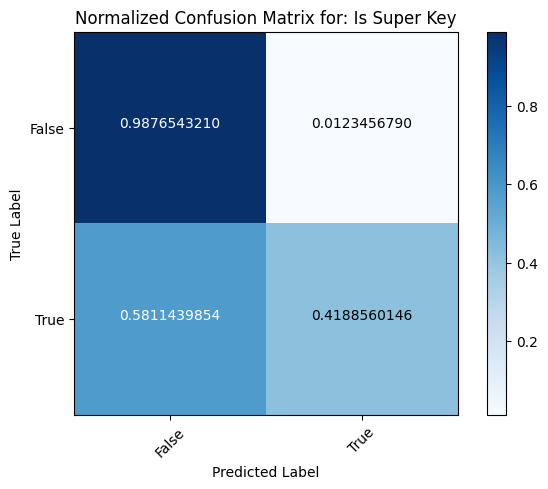

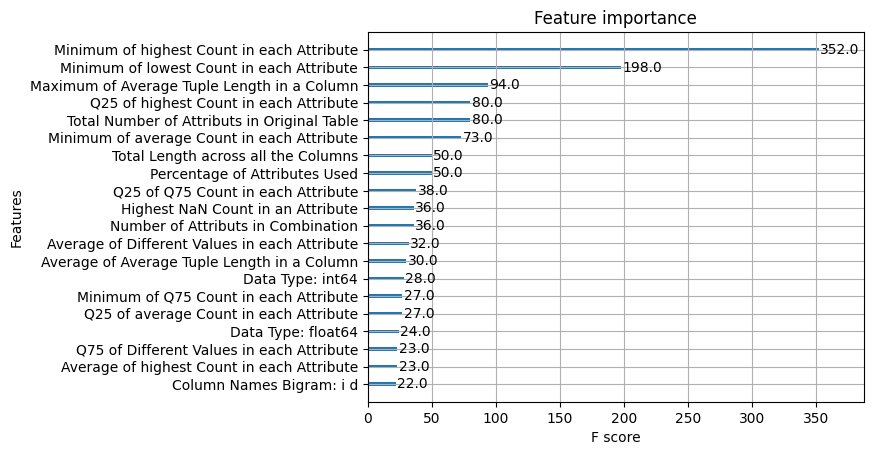

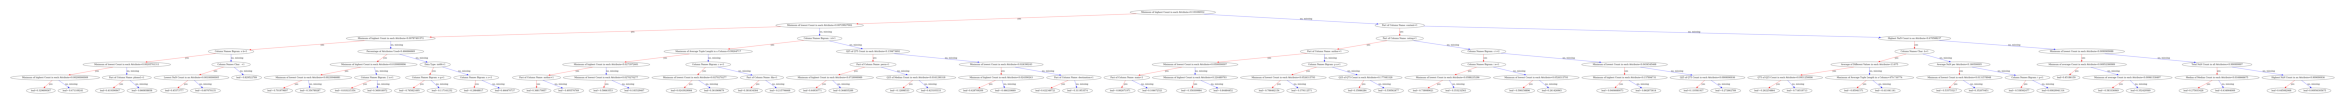

In [26]:
def all_features():
    times_for_creation_summed = [sum(times_column_names_bag_of_chars) + sum(times_column_names_concat)\
                                 + sum(times_concat_of_content_column)\
                                    + sum(times_data_types_bag_of_words) + sum(times_column_dtypes)\
                                        + sum(times_creation_df_total_num_columns) + sum(times_total_num_columns)\
                                            + sum(times_creation_df_number_attributes) + sum(times_number_attributes)\
                                                + sum(times_creation_df_attribute_percentage)\
                                                    + sum(times_creation_df_4_tuple_length_statistics) + sum(times_4_tuple_length_statistics)\
                                                        + sum(times_creation_df_4_nan_statistics) + sum(times_4_nan_statistics)\
                                                            + sum(times_creation_df_49_statistics) + sum(times_49_statistics)\
                                                                + sum(times_column_names_bigrams)\
                                                                    + sum(times_column_names_bag_of_words)]

    start_of_computation = time.time()
    df_complete = df_column_names_bag_of_chars.join(df_data_types)\
        .join(df_total_num_columns).join(df_number_attributes).join(df_attribute_percentage)\
        .join(df_4_tuple_length_statistics).join(df_4_nan_statistics).join(df_49_statistics)\
        .join(df_column_names_bigrams).join(df_column_names)
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, all_features, "Is Super Key", "All_Features")

Name: Column_Names_Bigrams (Is Super Key)

Number of Boosting Rounds: 100
Number of Features: 1704

Example from the Data (Is Super Key)
Column Combination: [1]
Prediction: Propability for [False, True]: [0.7867796  0.21322042]
Is Super Key?: False



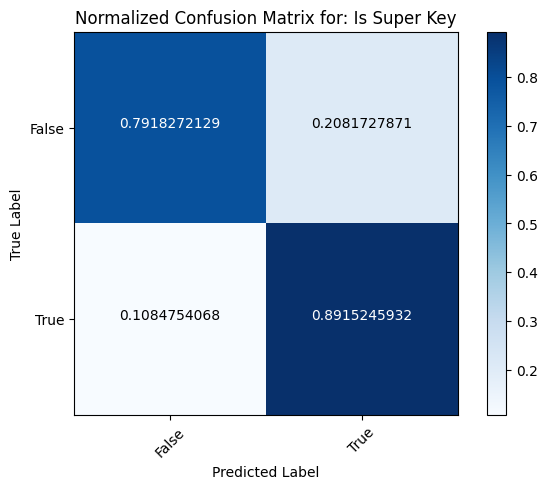

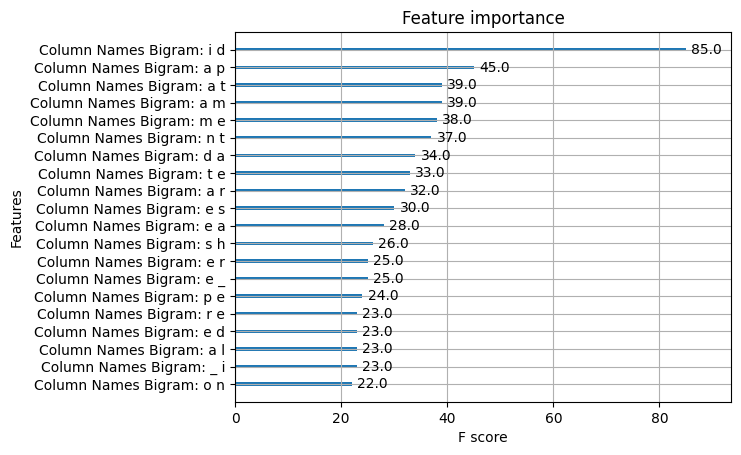

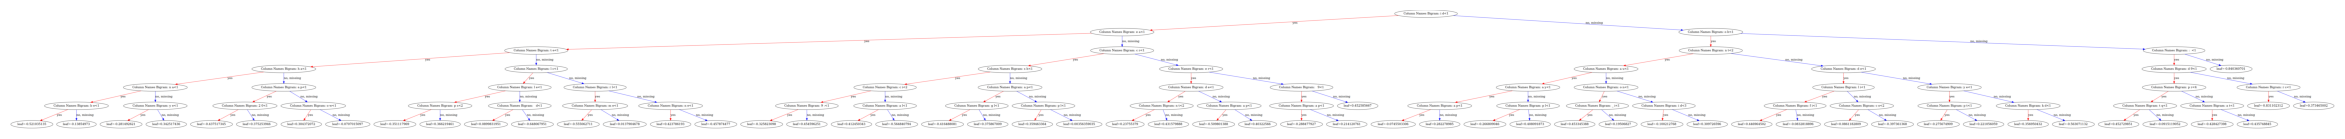

In [27]:
def column_names_bigrams():
    times_for_creation_summed = [sum(times_column_names_bigrams) + sum(times_column_names_concat)]

    start_of_computation = time.time()
    df_complete = df_column_names_bigrams
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, column_names_bigrams, "Is Super Key", "Column_Names_Bigrams")

In [28]:
'''def tuples_bigrams():
    times_for_creation_summed = [sum(times_tuples_bigrams) + sum(times_concat_of_content_column)]

    start_of_computation = time.time()
    df_complete = df_tuples_bigrams
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, tuples_bigrams, "Is Super Key", "Tuples_Bigrams")'''

temp_var = 1

In [29]:
'''def tuples_bag_of_chars():
    times_for_creation_summed = [sum(times_tuples_bag_of_chars) + sum(times_concat_of_content_column)]

    start_of_computation = time.time()
    df_complete = df_tuples_bag_of_chars
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, tuples_bag_of_chars, "Is Super Key", "Tuples_Bag_of_Chars")'''

temp_var = 1

Name: 49_Statistics (Is Super Key)

Number of Boosting Rounds: 100
Number of Features: 49

Example from the Data (Is Super Key)
Column Combination: [1]
Prediction: Propability for [False, True]: [9.9980956e-01 1.9041315e-04]
Is Super Key?: False



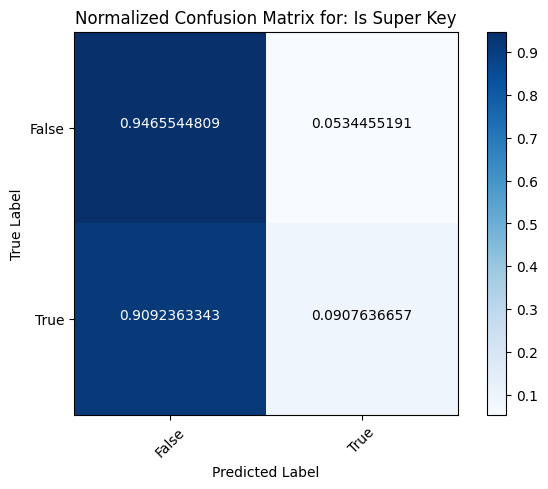

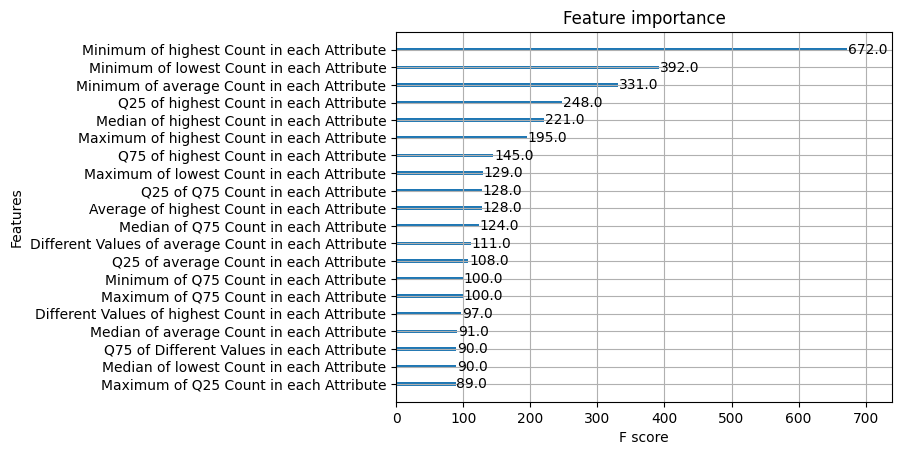

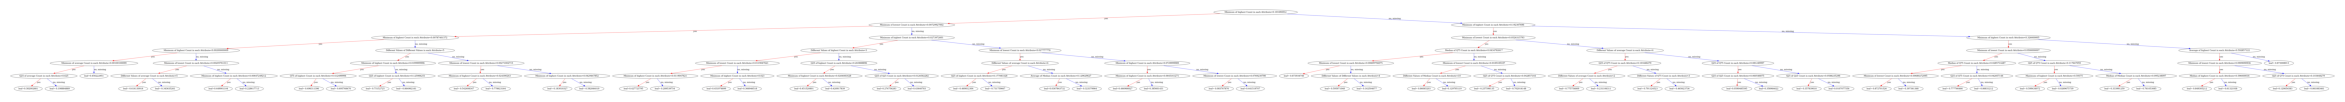

In [30]:
def statistics_49():
    times_for_creation_summed = [sum(times_creation_df_49_statistics) + sum(times_49_statistics) + sum(times_concat_of_content_column)]

    start_of_computation = time.time()
    df_complete = df_49_statistics
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, statistics_49, "Is Super Key", "49_Statistics")

Name: 4_NaN_Statistics (Is Super Key)

Number of Boosting Rounds: 100
Number of Features: 4

Example from the Data (Is Super Key)
Column Combination: [1]
Prediction: Propability for [False, True]: [0.32033485 0.67966515]
Is Super Key?: False



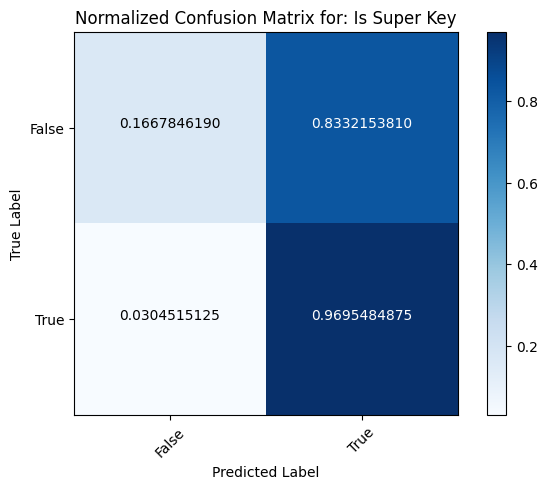

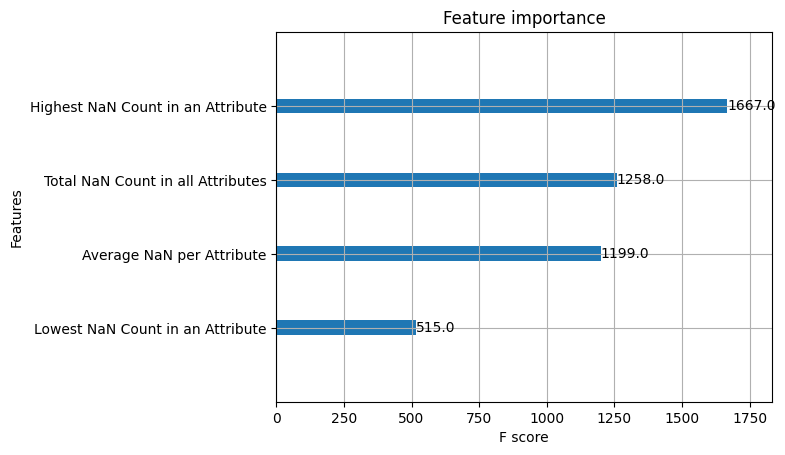

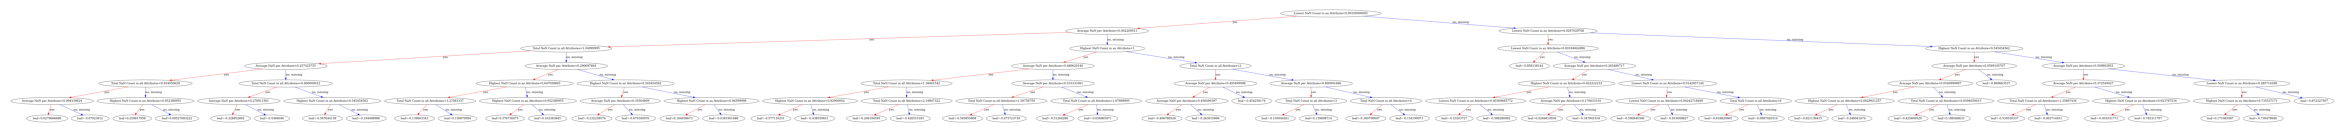

In [31]:
def statistics_4_nan():
    times_for_creation_summed = [sum(times_creation_df_4_nan_statistics) + sum(times_4_nan_statistics) + sum(times_concat_of_content_column)]

    start_of_computation = time.time()
    df_complete = df_4_nan_statistics
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, statistics_4_nan, "Is Super Key", "4_NaN_Statistics")

Name: 53_Statistics (Is Super Key)

Number of Boosting Rounds: 100
Number of Features: 53

Example from the Data (Is Super Key)
Column Combination: [1]
Prediction: Propability for [False, True]: [9.9991024e-01 8.9736393e-05]
Is Super Key?: False



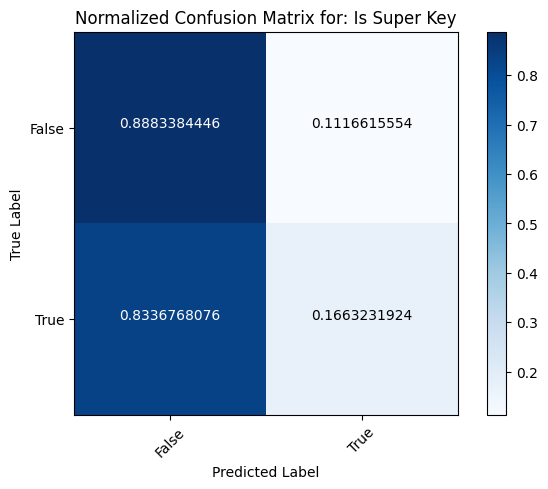

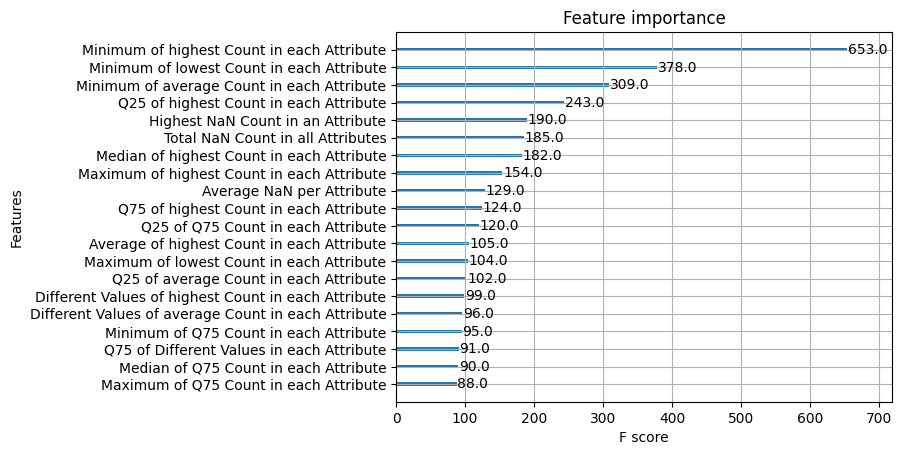

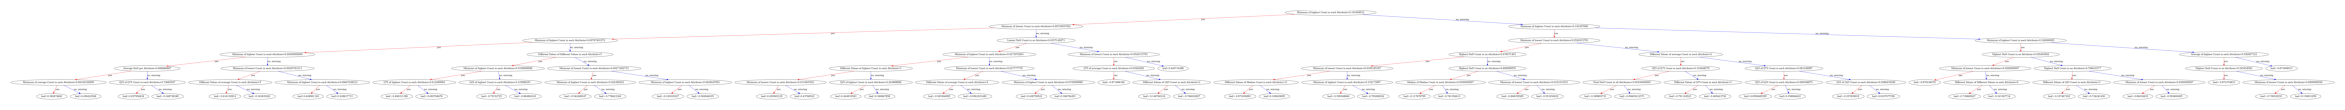

In [32]:
def statistics_53():
    times_for_creation_summed = [sum(times_creation_df_49_statistics) + sum(times_49_statistics) + sum(times_concat_of_content_column)\
                                 + sum(times_creation_df_4_nan_statistics) + sum(times_4_nan_statistics)]

    start_of_computation = time.time()
    df_complete = df_49_statistics.join(df_4_nan_statistics)
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, statistics_53, "Is Super Key", "53_Statistics")

Name: Column_Names_Bag_of_Words (Is Super Key)

Number of Boosting Rounds: 100
Number of Features: 5690

Example from the Data (Is Super Key)
Column Combination: [1]
Prediction: Propability for [False, True]: [0.6890576  0.31094238]
Is Super Key?: False



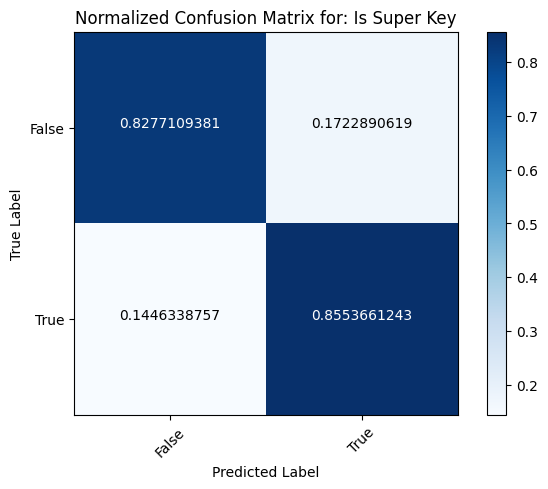

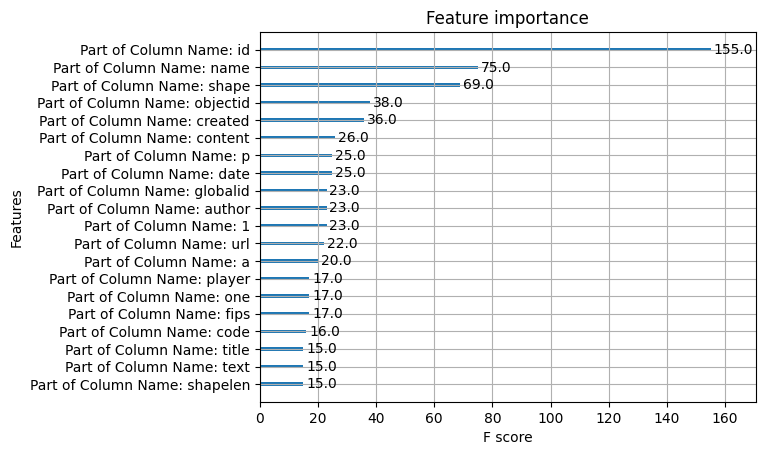

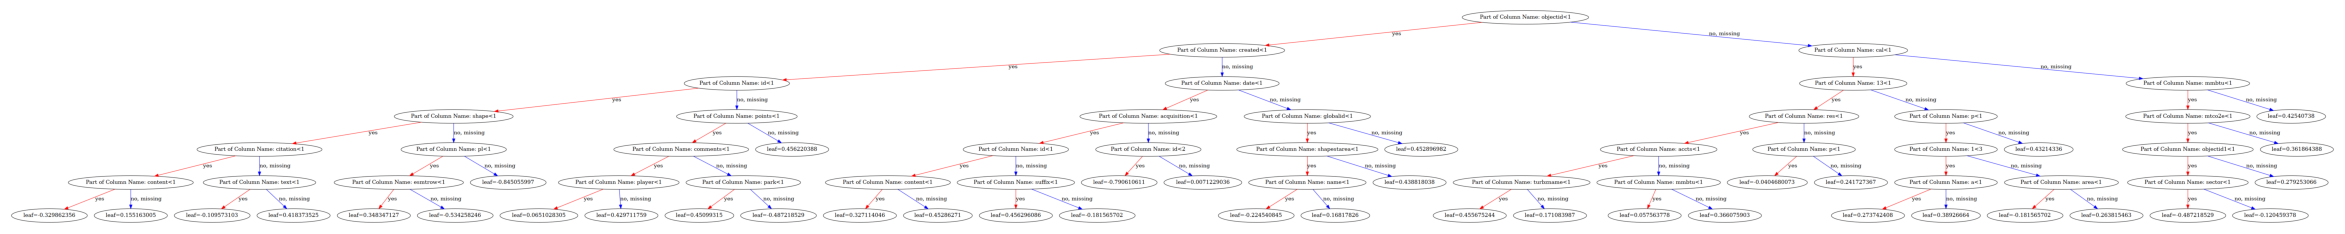

In [33]:
def column_names_bag_of_words():
    times_for_creation_summed = [sum(times_column_names_bag_of_words) + sum(times_column_names_concat)]

    start_of_computation = time.time()
    df_complete = df_column_names
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, column_names_bag_of_words, "Is Super Key", "Column_Names_Bag_of_Words")

Name: Column_Names_Bag_of_Chars (Is Super Key)

Number of Boosting Rounds: 100
Number of Features: 59

Example from the Data (Is Super Key)
Column Combination: [1]
Prediction: Propability for [False, True]: [0.8651548  0.13484521]
Is Super Key?: False



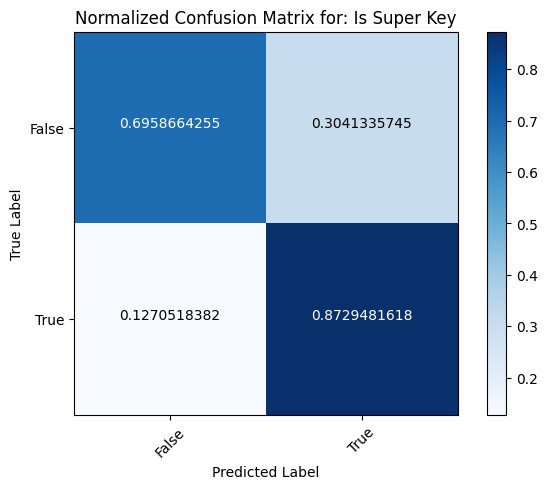

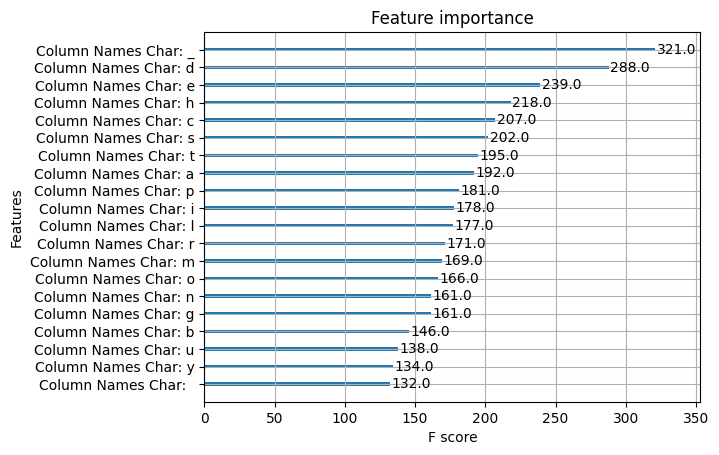

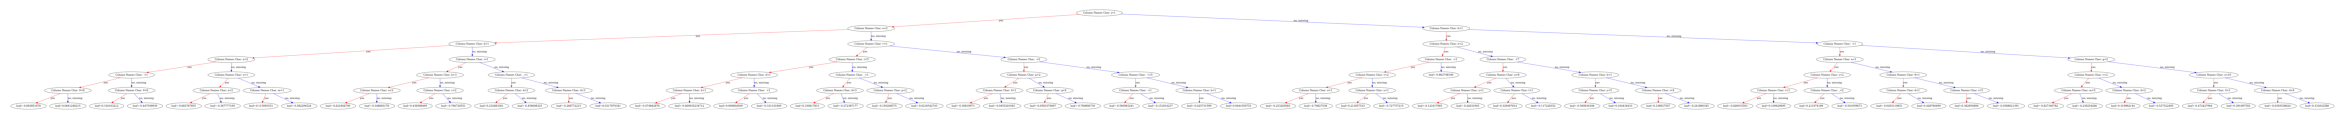

In [34]:
def column_names_bag_of_chars():
    times_for_creation_summed = [sum(times_column_names_bag_of_chars) + sum(times_column_names_concat)]

    start_of_computation = time.time()
    df_complete = df_column_names_bag_of_chars
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, column_names_bag_of_chars, "Is Super Key", "Column_Names_Bag_of_Chars")

Name: Column_Names_Bag_of_Words_and_Bag_of_Chars (Is Super Key)

Number of Boosting Rounds: 100
Number of Features: 5749

Example from the Data (Is Super Key)
Column Combination: [1]
Prediction: Propability for [False, True]: [0.8510097  0.14899029]
Is Super Key?: False



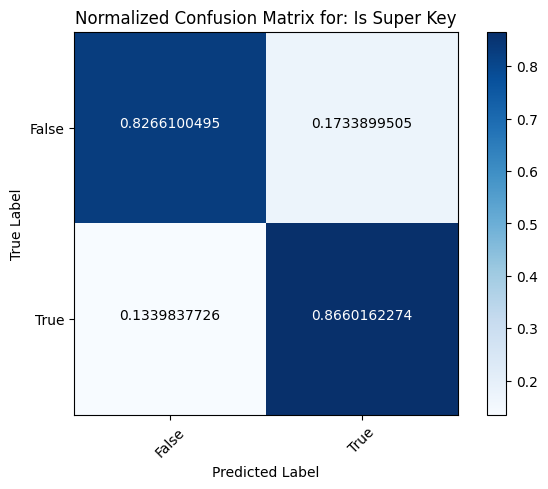

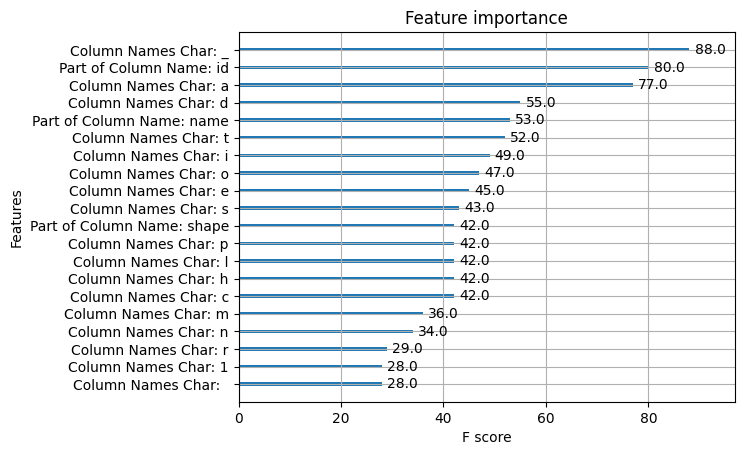

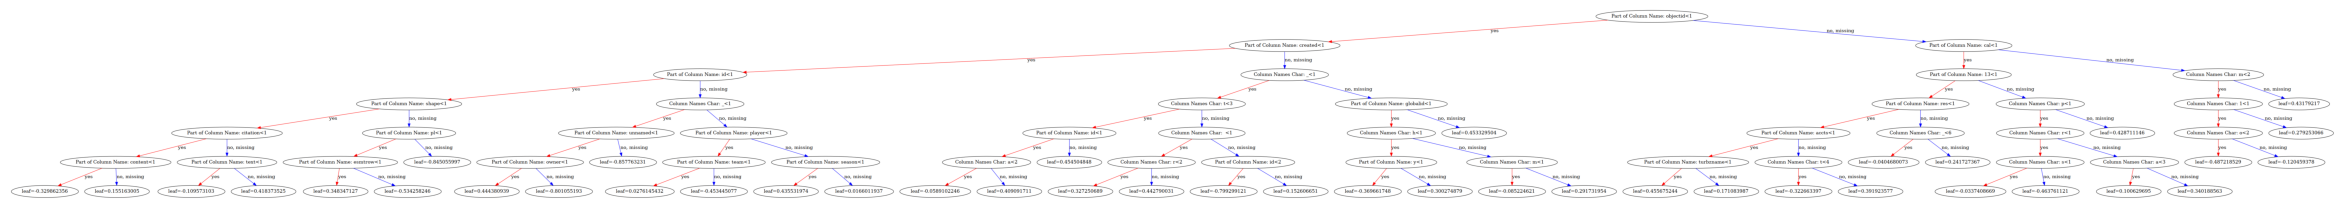

In [35]:
def column_names_bag_of_words_and_bag_of_chars():
    times_for_creation_summed = [sum(times_column_names_bag_of_words) + sum(times_column_names_concat)\
                                 + sum(times_column_names_bag_of_chars)]

    start_of_computation = time.time()
    df_complete = df_column_names_bag_of_chars.join(df_column_names)
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, column_names_bag_of_words_and_bag_of_chars, "Is Super Key", "Column_Names_Bag_of_Words_and_Bag_of_Chars")

Name: Column_Names_Bigrams_and_Bag_of_Chars (Is Super Key)

Number of Boosting Rounds: 100
Number of Features: 1763

Example from the Data (Is Super Key)
Column Combination: [1]
Prediction: Propability for [False, True]: [0.7851648  0.21483524]
Is Super Key?: False



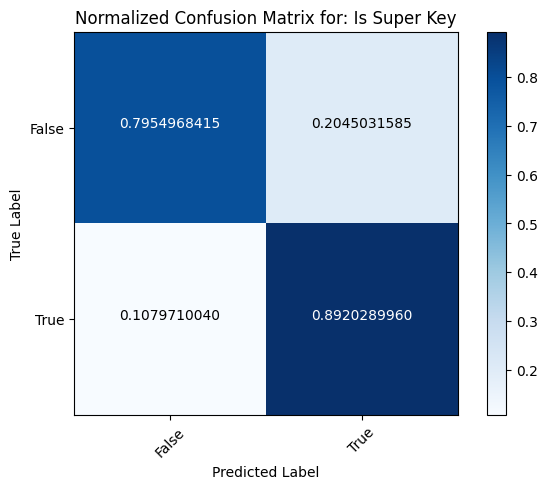

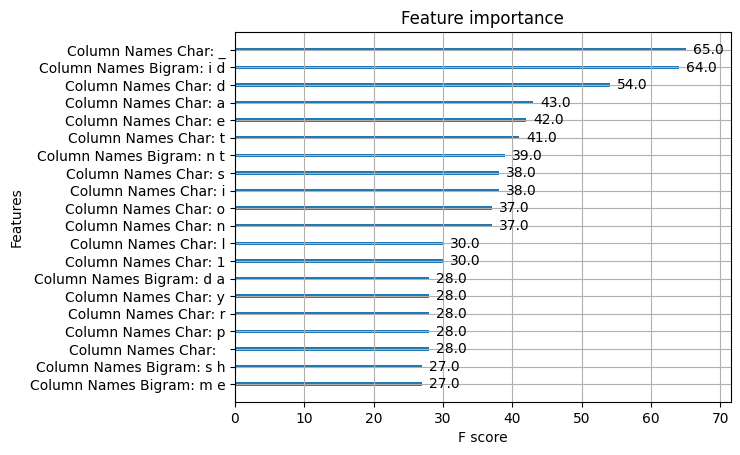

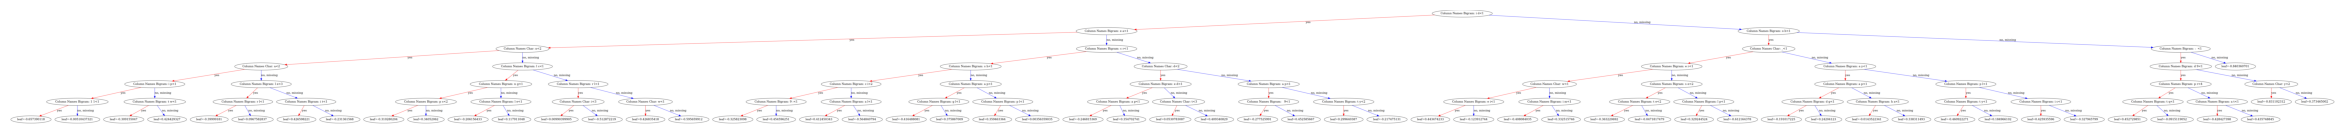

In [36]:
def column_names_bigrams_and_bag_of_chars():
    times_for_creation_summed = [sum(times_column_names_bigrams) + sum(times_column_names_concat)\
                                 + sum(times_column_names_bag_of_chars)]

    start_of_computation = time.time()
    df_complete = df_column_names_bag_of_chars.join(df_column_names_bigrams)
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, column_names_bigrams_and_bag_of_chars, "Is Super Key", "Column_Names_Bigrams_and_Bag_of_Chars")

Name: Data_Types (Is Super Key)

Number of Boosting Rounds: 100
Number of Features: 4

Example from the Data (Is Super Key)
Column Combination: [1]
Prediction: Propability for [False, True]: [0.69613314 0.3038669 ]
Is Super Key?: False



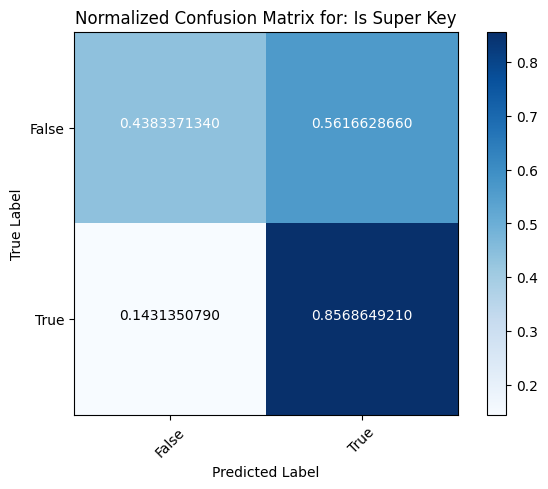

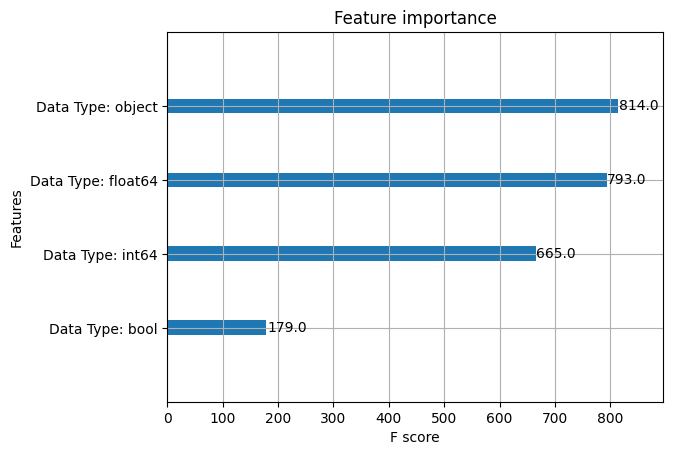

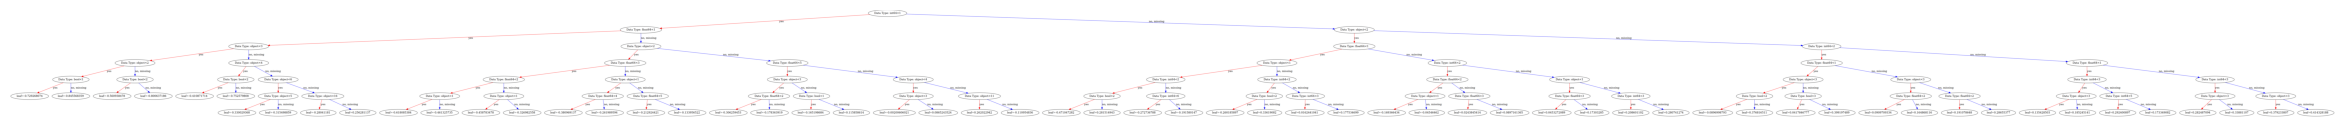

In [37]:
def data_types():
    times_for_creation_summed = [sum(times_data_types_bag_of_words) + sum(times_column_dtypes)]

    start_of_computation = time.time()
    df_complete = df_data_types
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, data_types, "Is Super Key", "Data_Types")

Name: 3_Number_Attributes_Statistics (Is Super Key)

Number of Boosting Rounds: 100
Number of Features: 3

Example from the Data (Is Super Key)
Column Combination: [1]
Prediction: Propability for [False, True]: [0.78515893 0.21484107]
Is Super Key?: False



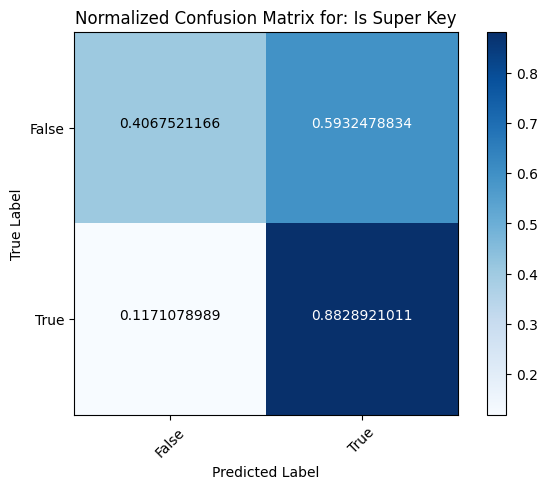

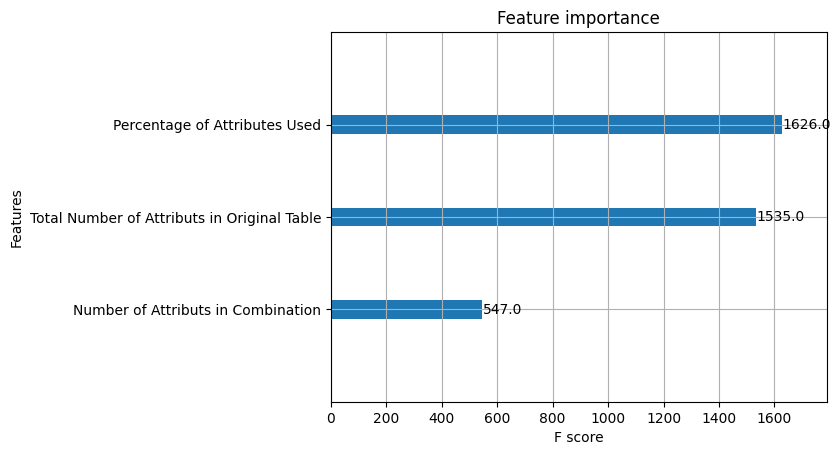

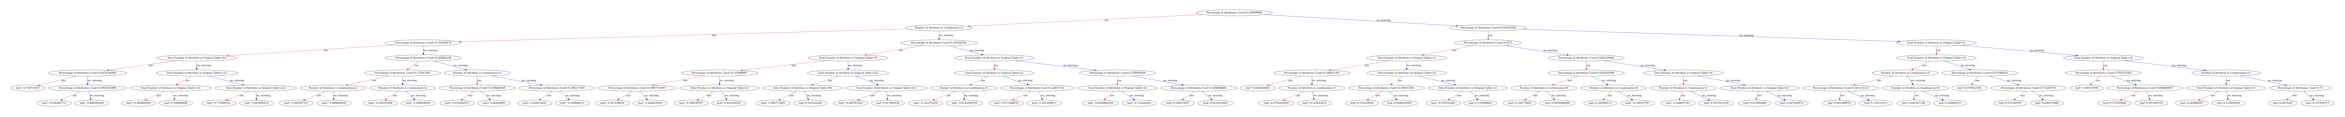

In [38]:
def statistics_3_number_attributes():
    times_for_creation_summed = [sum(times_creation_df_attribute_percentage)\
                                 + sum(times_creation_df_number_attributes) + sum(times_number_attributes)\
                                    + sum(times_creation_df_total_num_columns) + sum(times_total_num_columns)]

    start_of_computation = time.time()
    df_complete = df_attribute_percentage.join(df_number_attributes).join(df_total_num_columns)
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, statistics_3_number_attributes, "Is Super Key", "3_Number_Attributes_Statistics")

In [39]:
'''def statistics_5_tuple_length():
    times_for_creation_summed = [sum(times_creation_df_4_tuple_length_statistics) + sum(times_4_tuple_length_statistics) + sum(times_concat_of_content_column)\
                                 + sum(times_creation_df_tuple_length_per_column_average)]

    start_of_computation = time.time()
    df_complete = df_4_tuple_length_statistics.join(df_tuple_length_per_column_average)
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, statistics_5_tuple_length, "Is Super Key", "5_Tuple_Length_Statistics")'''

temp_var = 1

In [40]:
'''def total_tuple_length():
    times_for_creation_summed = [sum(times_creation_df_total_tuple_length) + sum(times_complete_df_4_tuple_length_statistics)]

    start_of_computation = time.time()
    df_complete = df_total_tuple_length
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, total_tuple_length, "Is Super Key", "Total_Tuple_Length")'''

temp_var = 1

In [41]:
'''def avg_avg_tuple_length():
    times_for_creation_summed = [sum(times_creation_df_avg_avg_tuple_length) + sum(times_complete_df_4_tuple_length_statistics)]

    start_of_computation = time.time()
    df_complete = df_avg_avg_tuple_length
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, avg_avg_tuple_length, "Is Super Key", "Avg_Avg_Tuple_Length")'''

temp_var = 1

Name: Attribute_Number_and_NaN (Is Super Key)

Number of Boosting Rounds: 100
Number of Features: 7

Example from the Data (Is Super Key)
Column Combination: [1]
Prediction: Propability for [False, True]: [0.6705926 0.3294074]
Is Super Key?: False



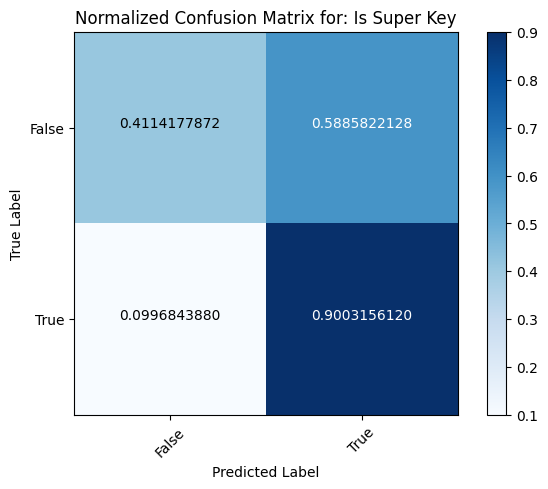

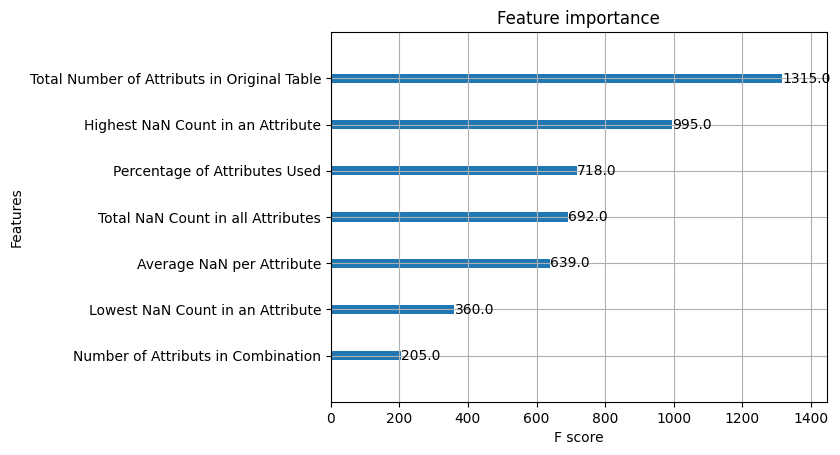

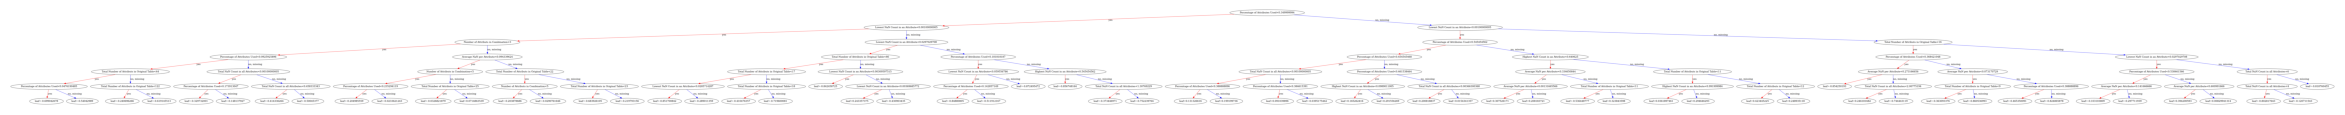

In [42]:
def attributes_and_nan():
    times_for_creation_summed = [sum(times_creation_df_attribute_percentage)\
                                 + sum(times_creation_df_number_attributes) + sum(times_number_attributes)\
                                    + sum(times_creation_df_total_num_columns) + sum(times_total_num_columns)\
                                        + sum(times_creation_df_4_nan_statistics) + sum(times_4_nan_statistics) + sum(times_concat_of_content_column)]

    start_of_computation = time.time()
    df_complete = df_attribute_percentage.join(df_number_attributes).join(df_total_num_columns).join(df_4_nan_statistics)
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, attributes_and_nan, "Is Super Key", "Attribute_Number_and_NaN")

In [43]:
'''def tuples_bag_of_chars_and_column_names_bag_of_words():
    times_for_creation_summed = [sum(times_tuples_bag_of_chars) + sum(times_concat_of_content_column)\
                                 + sum(times_column_names_bag_of_words) + sum(times_column_names_concat)]

    start_of_computation = time.time()
    df_complete = df_tuples_bag_of_chars.join(df_column_names)
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, tuples_bag_of_chars_and_column_names_bag_of_words, "Is Super Key", "Tuples_Bag_of_Chars_and_Column_Names_Bag_of_Words")'''

temp_var = 1

In [44]:
'''def tuples_bag_of_chars_and_column_names_bigrams():
    times_for_creation_summed = [sum(times_tuples_bag_of_chars) + sum(times_concat_of_content_column)\
                                 + sum(times_column_names_bigrams) + sum(times_column_names_concat)]

    start_of_computation = time.time()
    df_complete = df_tuples_bag_of_chars.join(df_column_names_bigrams)
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, tuples_bag_of_chars_and_column_names_bigrams, "Is Super Key", "Tuples_Bag_of_Chars_and_Column_Names_Bigrams")'''

temp_var = 1

In [45]:
'''def tuples_bag_of_chars_and_column_names_bag_of_chars():
    times_for_creation_summed = [sum(times_tuples_bag_of_chars) + sum(times_concat_of_content_column)\
                                 + sum(times_column_names_bag_of_chars) + sum(times_column_names_concat)]

    start_of_computation = time.time()
    df_complete = df_tuples_bag_of_chars.join(df_column_names_bag_of_chars)
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, tuples_bag_of_chars_and_column_names_bag_of_chars, "Is Super Key", "Tuples_Bag_of_Chars_and_Column_Names_Bag_of_Chars")'''

temp_var = 1

In [46]:
'''def tuples_bag_of_chars_and_data_types():
    times_for_creation_summed = [sum(times_tuples_bag_of_chars) + sum(times_concat_of_content_column)\
                                 + sum(times_data_types_bag_of_words) + sum(times_column_dtypes)]

    start_of_computation = time.time()
    df_complete = df_tuples_bag_of_chars.join(df_data_types)
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, tuples_bag_of_chars_and_data_types, "Is Super Key", "Tuples_Bag_of_Chars_and_Data_Types")'''

temp_var = 1

Name: Data_Types_and_Column_Names_Bag_of_Words (Is Super Key)

Number of Boosting Rounds: 100
Number of Features: 5694

Example from the Data (Is Super Key)
Column Combination: [1]
Prediction: Propability for [False, True]: [0.7774041  0.22259589]
Is Super Key?: False



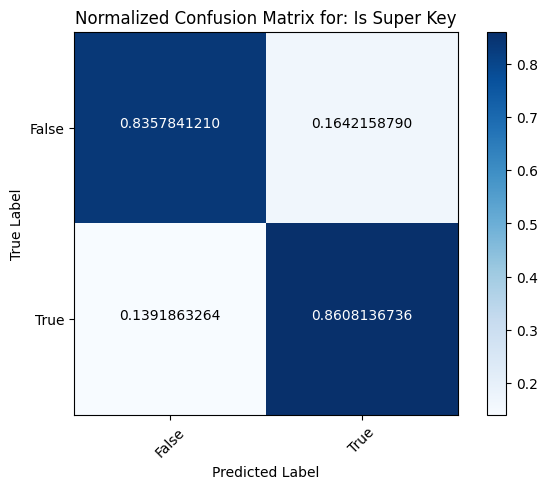

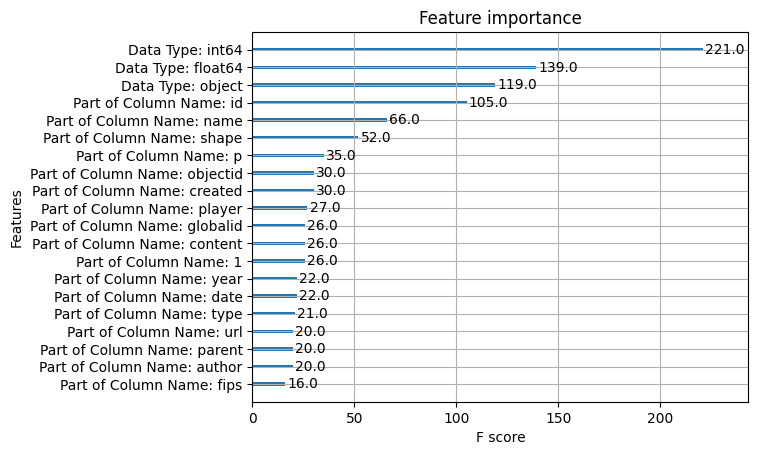

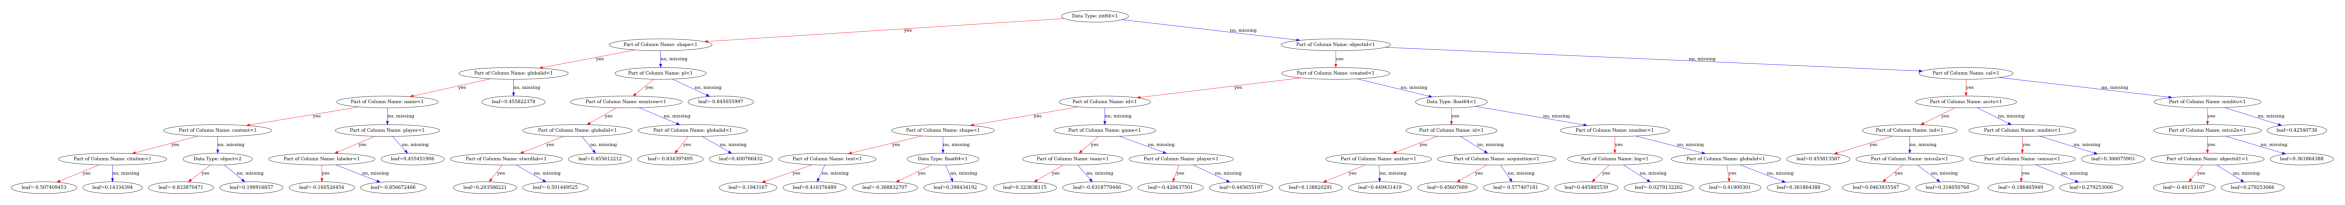

In [47]:
def data_types_and_column_names_bag_of_words():
    times_for_creation_summed = [sum(times_data_types_bag_of_words) + sum(times_column_dtypes)\
                                  + sum(times_column_names_bag_of_words) + sum(times_column_names_concat)]

    start_of_computation = time.time()
    df_complete = df_data_types.join(df_column_names)
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, data_types_and_column_names_bag_of_words, "Is Super Key", "Data_Types_and_Column_Names_Bag_of_Words")

Name: Data_Types_and_Column_Names_Bigrams (Is Super Key)

Number of Boosting Rounds: 100
Number of Features: 1708

Example from the Data (Is Super Key)
Column Combination: [1]
Prediction: Propability for [False, True]: [0.7541958  0.24580419]
Is Super Key?: False



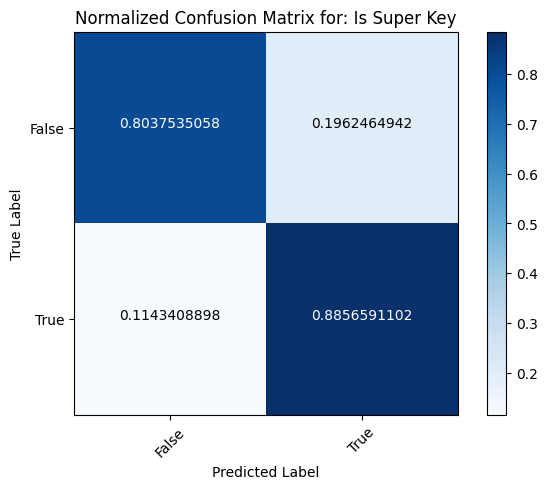

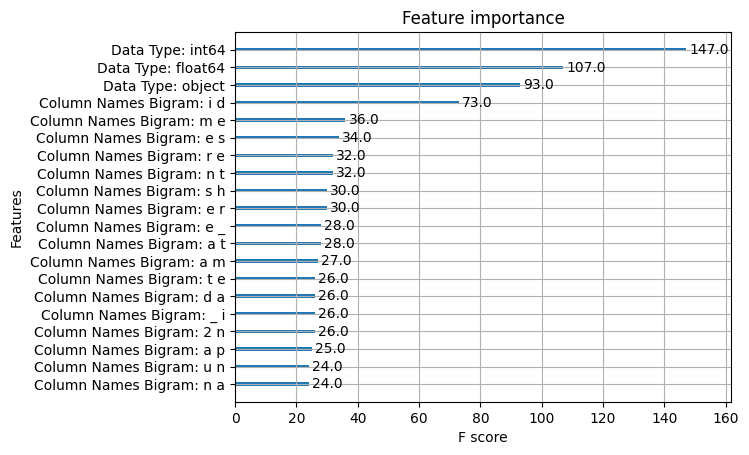

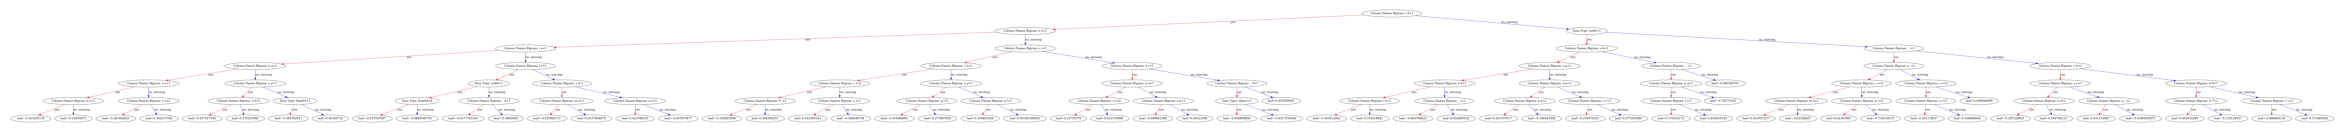

In [48]:
def data_types_and_column_names_bigrams():
    times_for_creation_summed = [sum(times_data_types_bag_of_words) + sum(times_column_dtypes)\
                                  + sum(times_column_names_bigrams) + sum(times_column_names_concat)]

    start_of_computation = time.time()
    df_complete = df_data_types.join(df_column_names_bigrams)
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, data_types_and_column_names_bigrams, "Is Super Key", "Data_Types_and_Column_Names_Bigrams")

In [49]:
'''def tuples_bag_of_chars_and_number_attributes():
    times_for_creation_summed = [sum(times_tuples_bag_of_chars) + sum(times_concat_of_content_column)\
                                 + sum(times_creation_df_number_attributes) + sum(times_number_attributes)]

    start_of_computation = time.time()
    df_complete = df_tuples_bag_of_chars.join(df_number_attributes)
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, tuples_bag_of_chars_and_number_attributes, "Is Super Key", "Tuples_Bag_of_Chars_and_Number_Attributes")'''

temp_var = 1

Name: Statistics_4_Tuple_Length_and_Number_Attributes (Is Super Key)

Number of Boosting Rounds: 100
Number of Features: 5

Example from the Data (Is Super Key)
Column Combination: [1]
Prediction: Propability for [False, True]: [0.85453355 0.14546642]
Is Super Key?: False



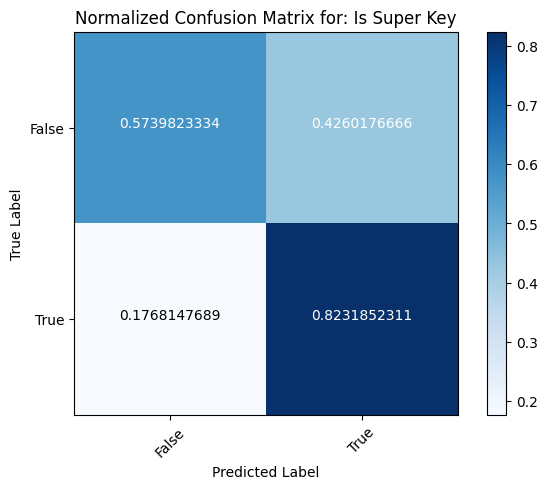

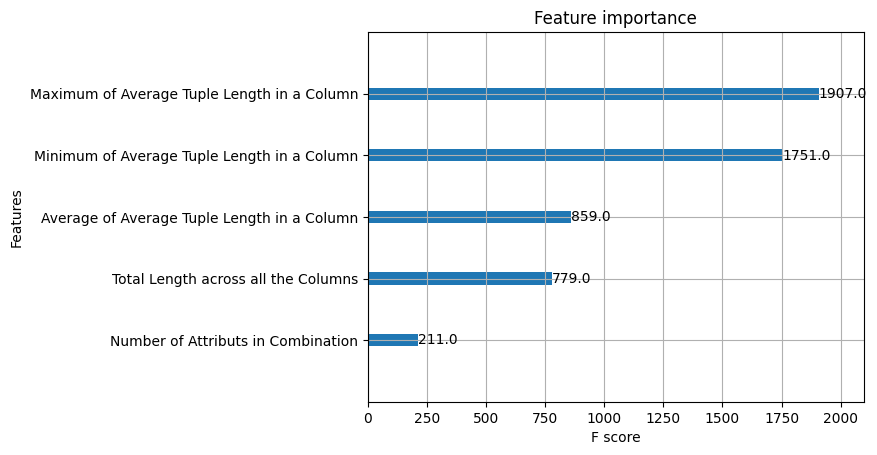

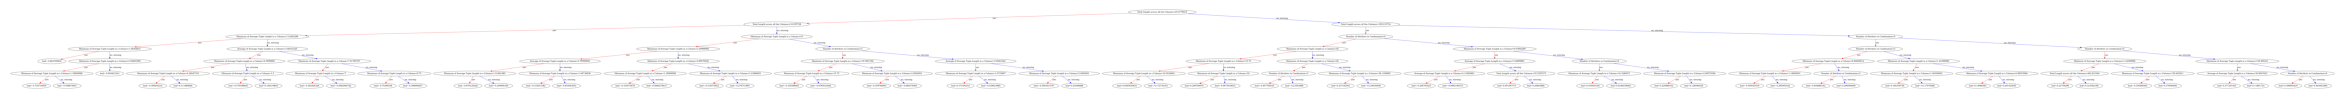

In [50]:
def statistics_4_tuple_length_and_number_attributes():
    times_for_creation_summed = [sum(times_complete_df_4_tuple_length_statistics)\
                                 + sum(times_creation_df_number_attributes) + sum(times_number_attributes)]

    start_of_computation = time.time()
    df_complete = df_4_tuple_length_statistics.join(df_number_attributes)
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, statistics_4_tuple_length_and_number_attributes, "Is Super Key", "Statistics_4_Tuple_Length_and_Number_Attributes")

In [51]:
'''def tuple_length_per_column_and_number_attributes():
    times_for_creation_summed = [sum(times_creation_df_tuple_length_per_column_average) + sum(times_complete_df_4_tuple_length_statistics)\
                                 + sum(times_creation_df_number_attributes) + sum(times_number_attributes)]

    start_of_computation = time.time()
    df_complete = df_tuple_length_per_column_average.join(df_number_attributes)
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, tuple_length_per_column_and_number_attributes, "Is Super Key", "Tuple_Length_per_Column_and_Number_Attributes")'''

temp_var = 1

Name: Number_Attributes_with_2_more (Is Super Key)

Number of Boosting Rounds: 100
Number of Features: 9

Example from the Data (Is Super Key)
Column Combination: [1]
Prediction: Propability for [False, True]: [0.85653096 0.14346905]
Is Super Key?: False



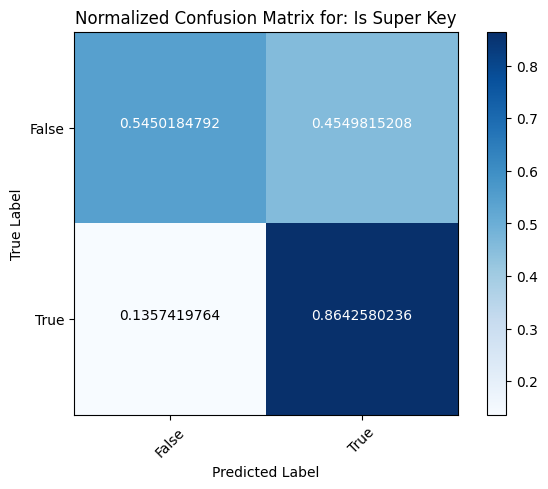

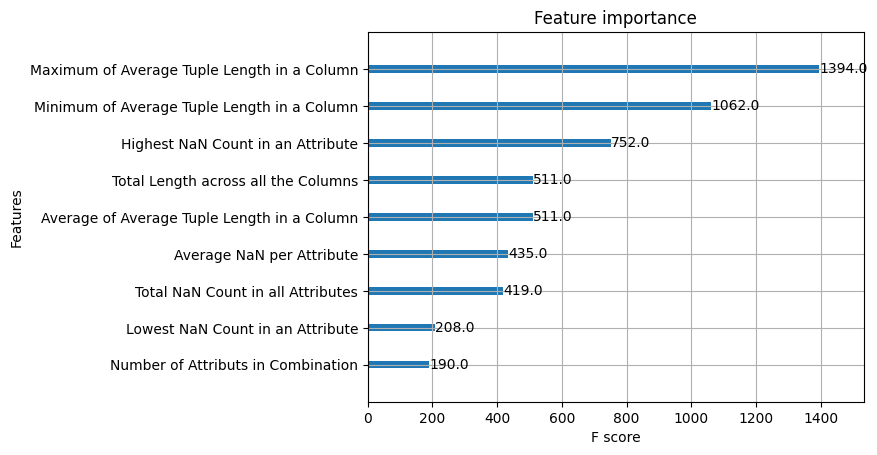

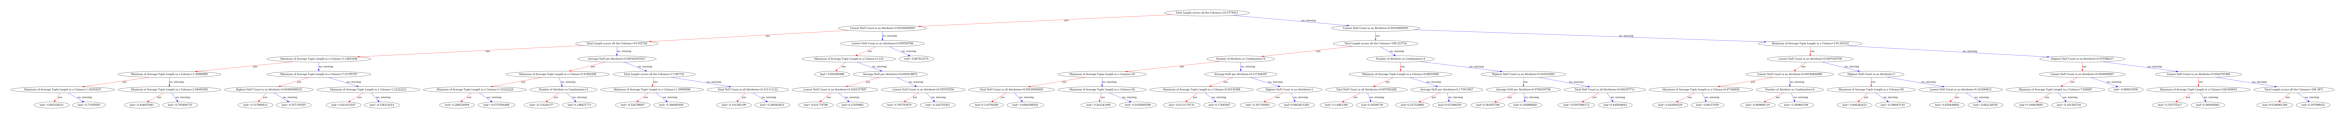

In [52]:
def number_attributes_with_2_more():
    times_for_creation_summed = [sum(times_creation_df_number_attributes) + sum(times_number_attributes)\
                                  + sum(times_complete_df_4_tuple_length_statistics)\
                                    + sum(times_creation_df_4_nan_statistics) + sum(times_4_nan_statistics)]

    start_of_computation = time.time()
    df_complete = df_number_attributes.join(df_4_tuple_length_statistics).join(df_4_nan_statistics)
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, number_attributes_with_2_more, "Is Super Key", "Number_Attributes_with_2_more")

Name: Number_Attributes_with_4_more_1 (Is Super Key)

Number of Boosting Rounds: 100
Number of Features: 5703

Example from the Data (Is Super Key)
Column Combination: [1]
Prediction: Propability for [False, True]: [0.8335309  0.16646907]
Is Super Key?: False



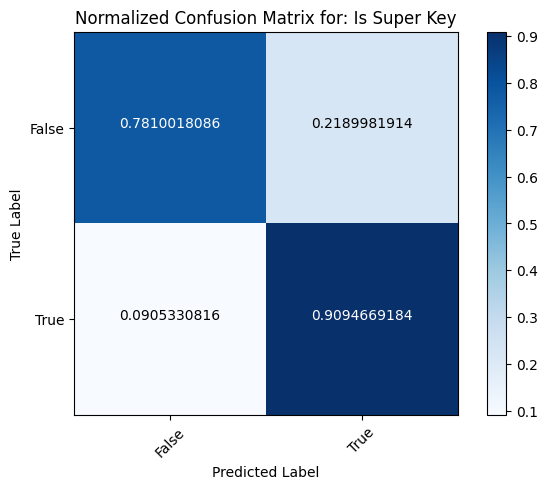

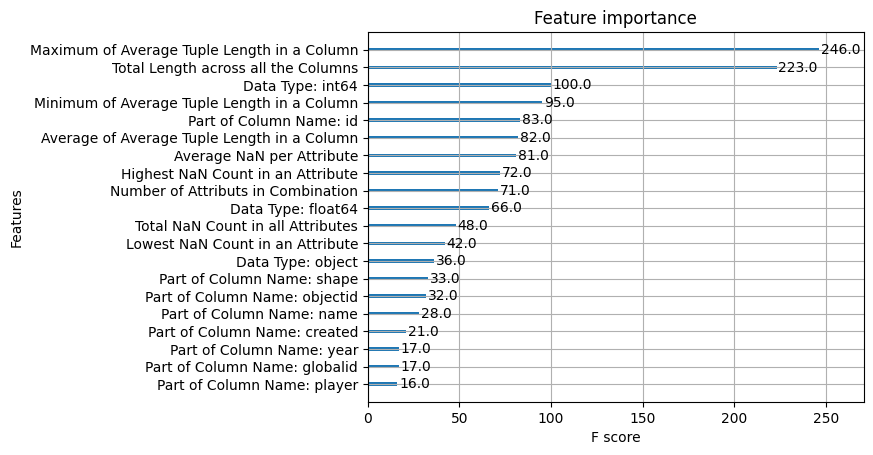

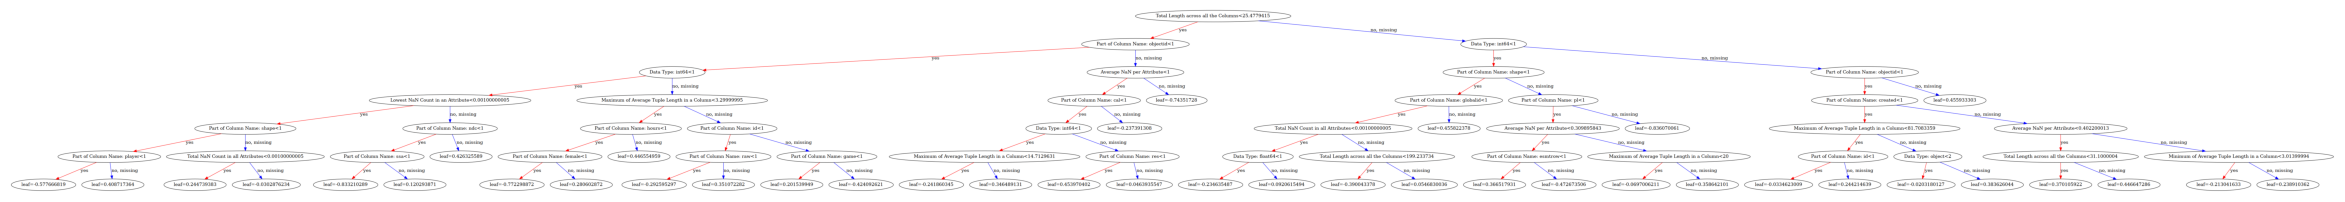

In [53]:
def number_attributes_with_4_more_1():
    times_for_creation_summed = [sum(times_creation_df_number_attributes) + sum(times_number_attributes)\
                                    + sum(times_complete_df_4_tuple_length_statistics)\
                                        + sum(times_creation_df_4_nan_statistics) + sum(times_4_nan_statistics)\
                                            + sum(times_column_names_bag_of_words) + sum(times_column_names_concat)\
                                                + sum(times_data_types_bag_of_words) + sum(times_column_dtypes)]

    start_of_computation = time.time()
    df_complete = df_number_attributes.join(df_4_tuple_length_statistics).join(df_4_nan_statistics).join(df_column_names).join(df_data_types)
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, number_attributes_with_4_more_1, "Is Super Key", "Number_Attributes_with_4_more_1")

Name: Number_Attributes_with_4_more_2 (Is Super Key)

Number of Boosting Rounds: 100
Number of Features: 1717

Example from the Data (Is Super Key)
Column Combination: [1]
Prediction: Propability for [False, True]: [0.8469372 0.1530628]
Is Super Key?: False



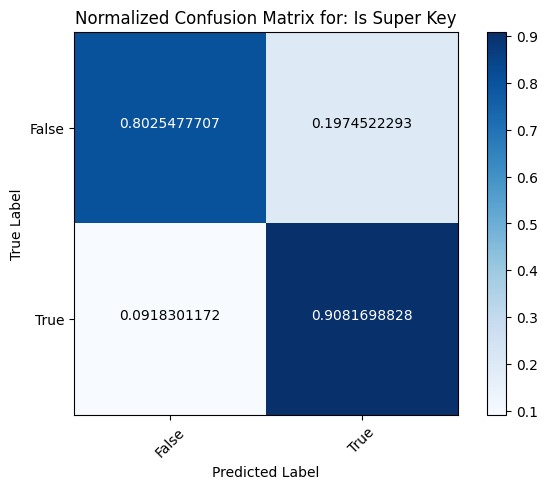

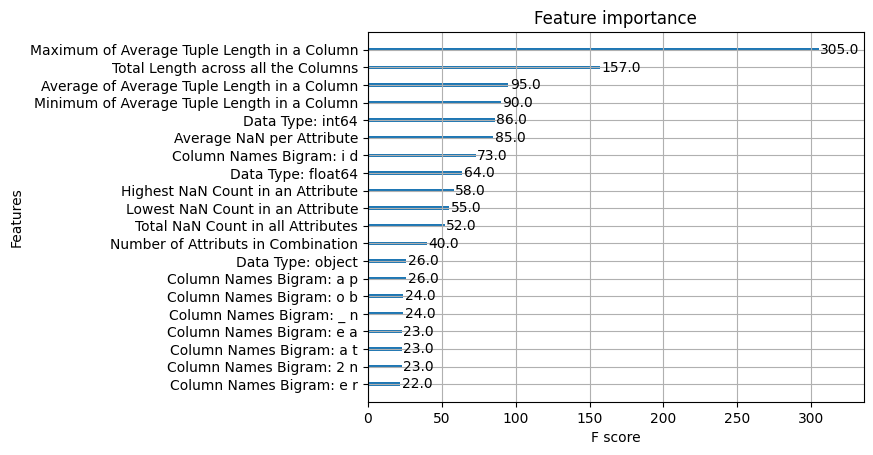

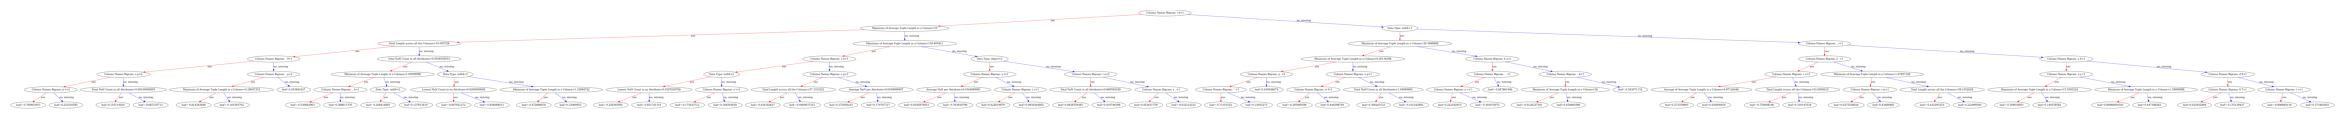

In [54]:
def number_attributes_with_4_more_2():
    times_for_creation_summed = [sum(times_creation_df_number_attributes) + sum(times_number_attributes)\
                                    + sum(times_complete_df_4_tuple_length_statistics)\
                                        + sum(times_creation_df_4_nan_statistics) + sum(times_4_nan_statistics)\
                                            + sum(times_column_names_bigrams) + sum(times_column_names_concat)\
                                                + sum(times_data_types_bag_of_words) + sum(times_column_dtypes)]

    start_of_computation = time.time()
    df_complete = df_number_attributes.join(df_4_tuple_length_statistics).join(df_4_nan_statistics).join(df_column_names_bigrams).join(df_data_types)
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, number_attributes_with_4_more_2, "Is Super Key", "Number_Attributes_with_4_more_2")

Name: Column_Names_Bag_of_Chars_and_Number_Attributes (Is Super Key)

Number of Boosting Rounds: 100
Number of Features: 60

Example from the Data (Is Super Key)
Column Combination: [1]
Prediction: Propability for [False, True]: [0.8382085 0.1617915]
Is Super Key?: False



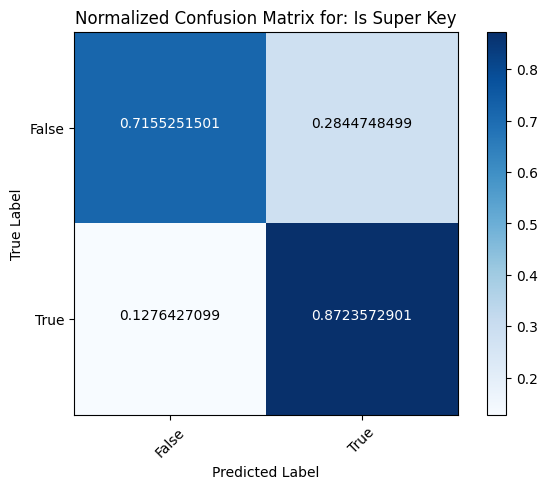

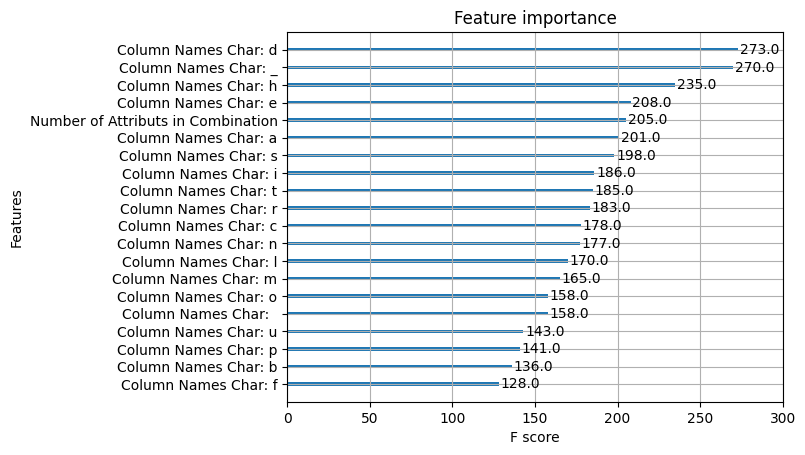

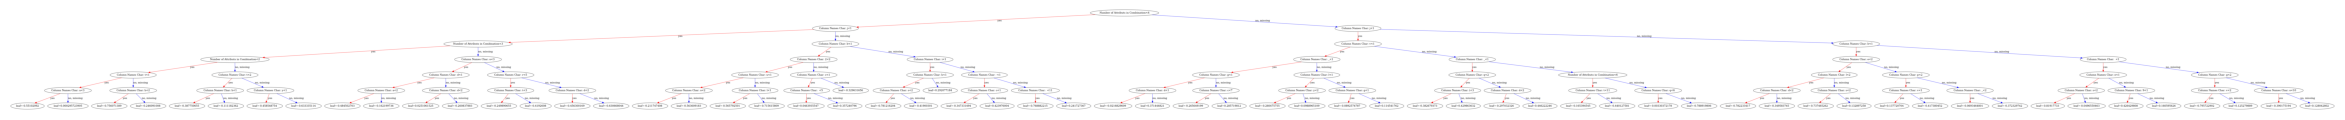

In [55]:
def column_names_bag_of_chars_and_number_attributes():
    times_for_creation_summed = [sum(times_column_names_bag_of_chars) + sum(times_column_names_concat)\
                                 + sum(times_creation_df_number_attributes) + sum(times_number_attributes)]

    start_of_computation = time.time()
    df_complete = df_column_names_bag_of_chars.join(df_number_attributes)
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, column_names_bag_of_chars_and_number_attributes, "Is Super Key", "Column_Names_Bag_of_Chars_and_Number_Attributes")

Name: Column_Names_Bag_of_Chars_with_3_more (Is Super Key)

Number of Boosting Rounds: 100
Number of Features: 68

Example from the Data (Is Super Key)
Column Combination: [1]
Prediction: Propability for [False, True]: [0.9307112  0.06928877]
Is Super Key?: False



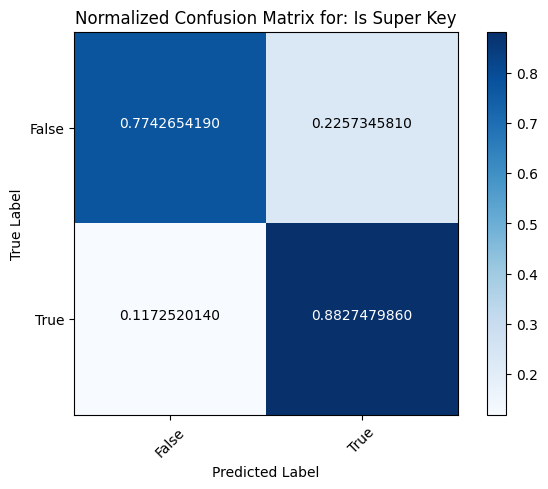

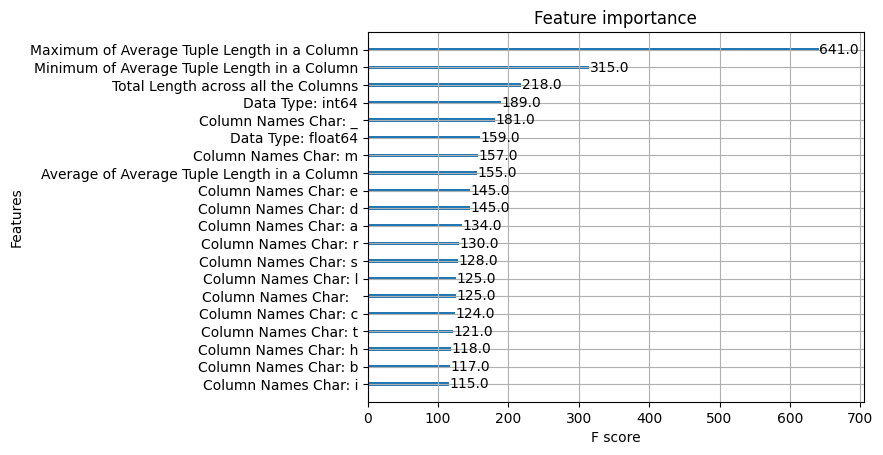

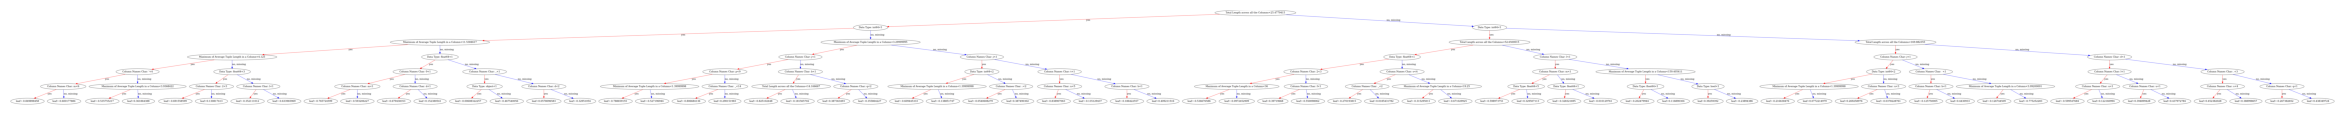

In [56]:
def column_names_bag_of_chars_with_3_more():
    times_for_creation_summed = [sum(times_column_names_bag_of_chars) + sum(times_column_names_concat)\
                                 + sum(times_creation_df_number_attributes) + sum(times_number_attributes)\
                                    + sum(times_complete_df_4_tuple_length_statistics)\
                                        + sum(times_data_types_bag_of_words) + sum(times_column_dtypes)]

    start_of_computation = time.time()
    df_complete = df_column_names_bag_of_chars.join(df_number_attributes).join(df_4_tuple_length_statistics).join(df_data_types)
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, column_names_bag_of_chars_with_3_more, "Is Super Key", "Column_Names_Bag_of_Chars_with_3_more")

Name: Column_Names_Bag_of_Chars_with_4_more (Is Super Key)

Number of Boosting Rounds: 100
Number of Features: 72

Example from the Data (Is Super Key)
Column Combination: [1]
Prediction: Propability for [False, True]: [0.853964   0.14603601]
Is Super Key?: False



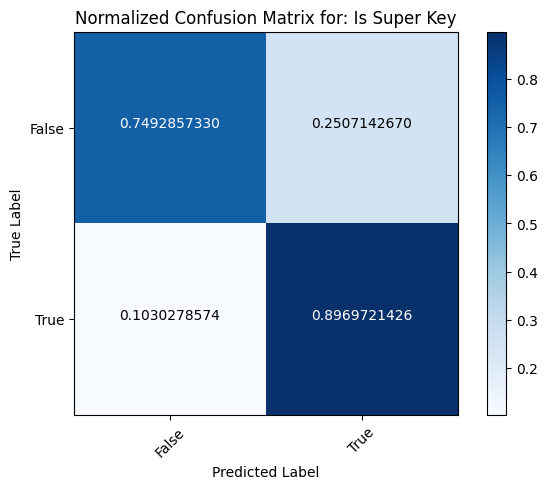

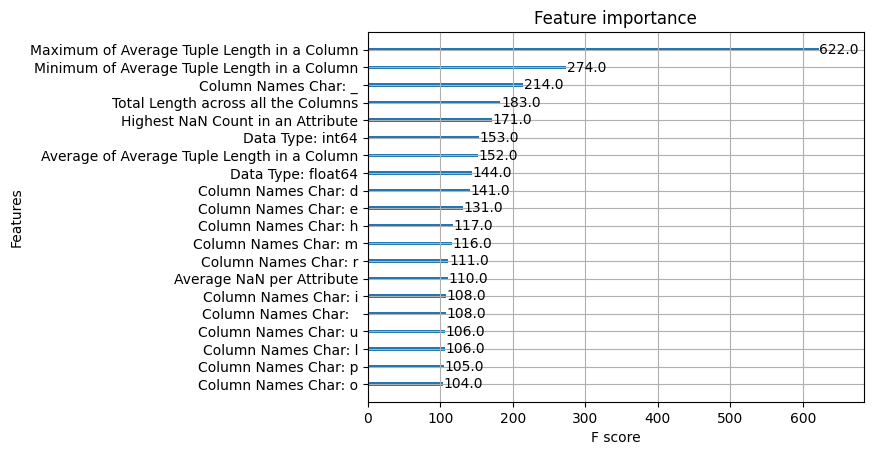

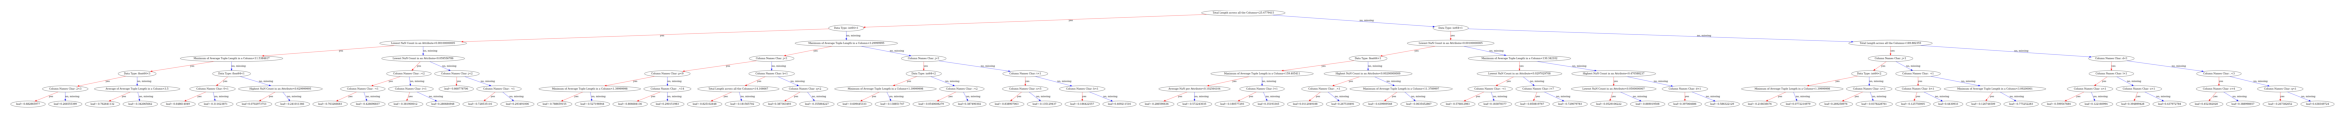

In [57]:
def column_names_bag_of_chars_with_4_more():
    times_for_creation_summed = [sum(times_column_names_bag_of_chars) + sum(times_column_names_concat)\
                                 + sum(times_creation_df_number_attributes) + sum(times_number_attributes)\
                                    + sum(times_complete_df_4_tuple_length_statistics)\
                                        + sum(times_creation_df_4_nan_statistics) + sum(times_4_nan_statistics)\
                                            + sum(times_data_types_bag_of_words) + sum(times_column_dtypes)]

    start_of_computation = time.time()
    df_complete = df_column_names_bag_of_chars.join(df_number_attributes).join(df_4_tuple_length_statistics).join(df_4_nan_statistics).join(df_data_types)
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, column_names_bag_of_chars_with_4_more, "Is Super Key", "Column_Names_Bag_of_Chars_with_4_more")

Name: Column_Names_Bag_of_Chars_with_5_more_1 (Is Super Key)

Number of Boosting Rounds: 100
Number of Features: 5762

Example from the Data (Is Super Key)
Column Combination: [1]
Prediction: Propability for [False, True]: [0.8460514  0.15394862]
Is Super Key?: False



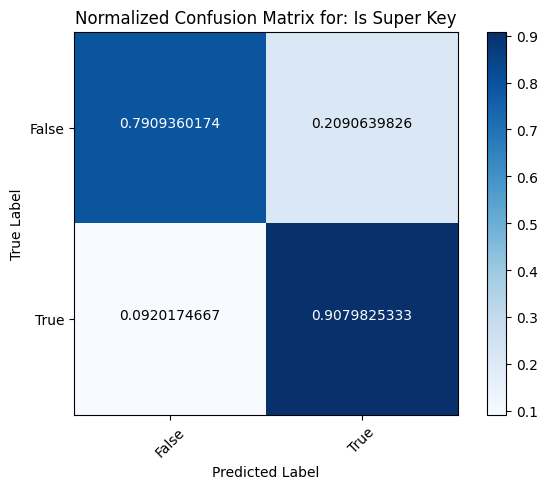

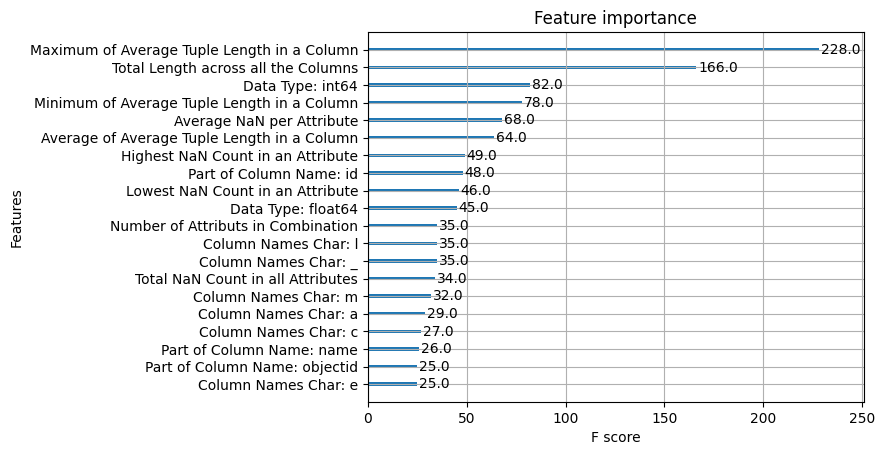

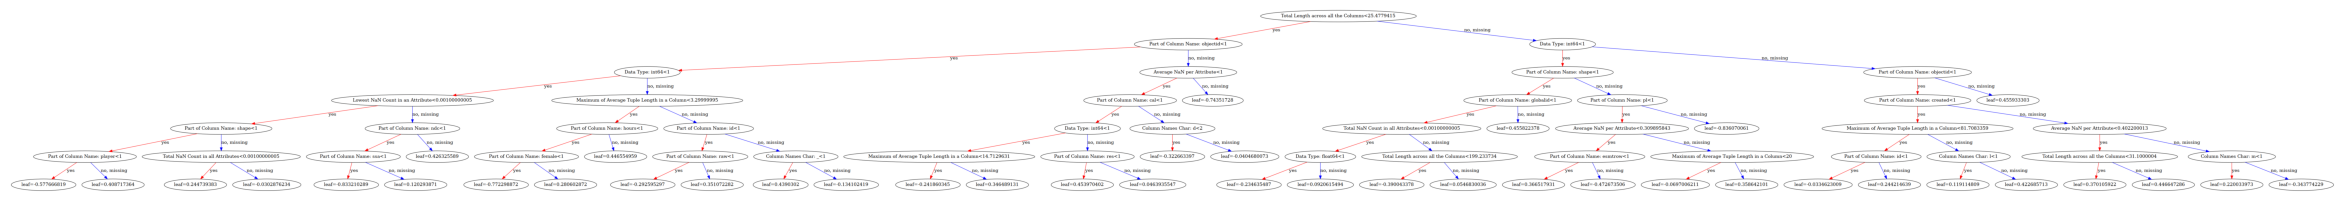

In [58]:
def column_names_bag_of_chars_with_5_more_1():
    times_for_creation_summed = [sum(times_column_names_bag_of_chars) + sum(times_column_names_concat)\
                                 + sum(times_creation_df_number_attributes) + sum(times_number_attributes)\
                                    + sum(times_complete_df_4_tuple_length_statistics)\
                                        + sum(times_creation_df_4_nan_statistics) + sum(times_4_nan_statistics)\
                                            + sum(times_column_names_bag_of_words)\
                                                + sum(times_data_types_bag_of_words) + sum(times_column_dtypes)]

    start_of_computation = time.time()
    df_complete = df_column_names_bag_of_chars.join(df_number_attributes).join(df_4_tuple_length_statistics).join(df_4_nan_statistics).join(df_column_names).join(df_data_types)
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, column_names_bag_of_chars_with_5_more_1, "Is Super Key", "Column_Names_Bag_of_Chars_with_5_more_1")

Name: Column_Names_Bag_of_Chars_with_5_more_2 (Is Super Key)

Number of Boosting Rounds: 100
Number of Features: 1776

Example from the Data (Is Super Key)
Column Combination: [1]
Prediction: Propability for [False, True]: [0.85021347 0.14978655]
Is Super Key?: False



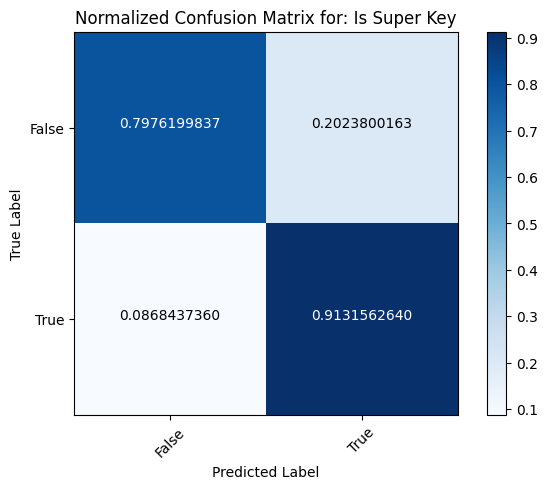

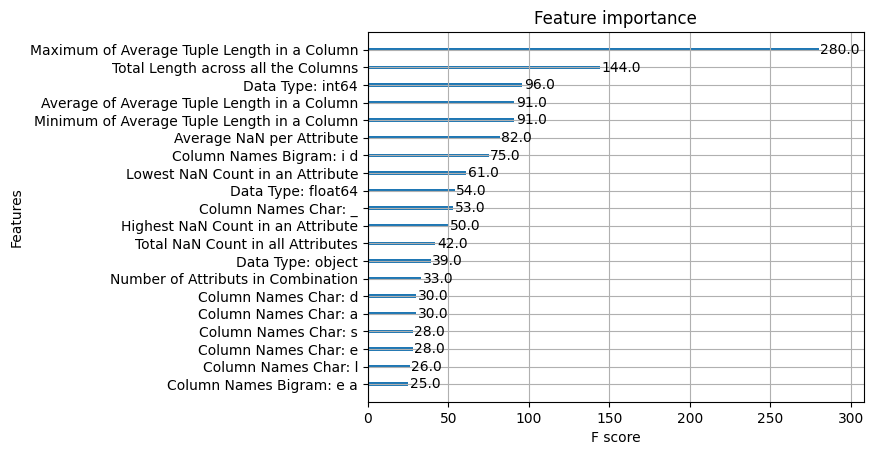

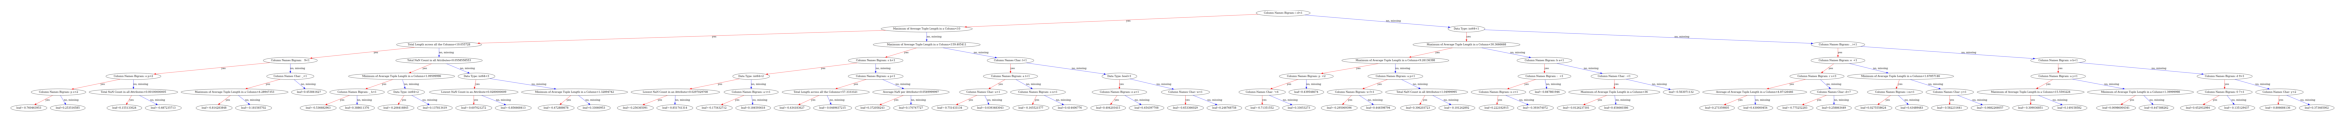

In [59]:
def column_names_bag_of_chars_with_5_more_2():
    times_for_creation_summed = [sum(times_column_names_bag_of_chars) + sum(times_column_names_concat)\
                                 + sum(times_creation_df_number_attributes) + sum(times_number_attributes)\
                                    + sum(times_complete_df_4_tuple_length_statistics)\
                                        + sum(times_creation_df_4_nan_statistics) + sum(times_4_nan_statistics)\
                                            + sum(times_column_names_bigrams)\
                                                + sum(times_data_types_bag_of_words) + sum(times_column_dtypes)]

    start_of_computation = time.time()
    df_complete = df_column_names_bag_of_chars.join(df_number_attributes).join(df_4_tuple_length_statistics).join(df_4_nan_statistics).join(df_column_names_bigrams).join(df_data_types)
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, column_names_bag_of_chars_with_5_more_2, "Is Super Key", "Column_Names_Bag_of_Chars_with_5_more_2")

In [60]:
'''def tuples_bigrams_and_bag_of_chars():
    times_for_creation_summed = [sum(times_tuples_bigrams) + sum(times_concat_of_content_column)\
                                 + sum(times_tuples_bag_of_chars)]

    start_of_computation = time.time()
    df_complete = df_tuples_bigrams.join(df_tuples_bag_of_chars)
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, tuples_bigrams_and_bag_of_chars, "Is Super Key", "Tuples_Bigrams_and_Bag_of_Chars")'''

temp_var = 1

In [61]:
'''def tuples_bigrams_and_column_names_bigrams():
    times_for_creation_summed = [sum(times_tuples_bigrams) + sum(times_concat_of_content_column)\
                                 + sum(times_column_names_bigrams) + sum(times_column_names_concat)]

    start_of_computation = time.time()
    df_complete = df_tuples_bigrams.join(df_column_names_bigrams)
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, tuples_bigrams_and_column_names_bigrams, "Is Super Key", "Tuples_Bigrams_and_Column_Names_Bigrams")'''

temp_var = 1

In [62]:
'''def tuples_bigrams_and_column_names_bag_of_chars():
    times_for_creation_summed = [sum(times_tuples_bigrams) + sum(times_concat_of_content_column)\
                                 + sum(times_column_names_bag_of_chars) + sum(times_column_names_concat)]

    start_of_computation = time.time()
    df_complete = df_tuples_bigrams.join(df_column_names_bag_of_chars)
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, tuples_bigrams_and_column_names_bag_of_chars, "Is Super Key", "Tuples_Bigrams_and_Column_Names_Bag_of_Chars")'''

temp_var = 1

In [63]:
'''def tuples_bigrams_and_data_types():
    times_for_creation_summed = [sum(times_tuples_bigrams) + sum(times_concat_of_content_column)\
                                 + sum(times_data_types_bag_of_words) + sum(times_column_dtypes)]

    start_of_computation = time.time()
    df_complete = df_tuples_bigrams.join(df_data_types)
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, tuples_bigrams_and_data_types, "Is Super Key", "Tuples_Bigrams_and_Data_Types")'''

temp_var = 1

In [64]:
'''def tuples_bigrams_and_num_attributes():
    times_for_creation_summed = [sum(times_tuples_bigrams) + sum(times_concat_of_content_column)\
                                 + sum(times_creation_df_number_attributes) + sum(times_number_attributes)]

    start_of_computation = time.time()
    df_complete = df_tuples_bigrams.join(df_number_attributes)
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, tuples_bigrams_and_num_attributes, "Is Super Key", "Tuples_Bigrams_and_Number_of_Attributes")'''

temp_var = 1

In [65]:
'''def tuples_bigrams_and_total_tuple_length():
    times_for_creation_summed = [sum(times_tuples_bigrams)\
                                 + sum(times_creation_df_total_tuple_length) + sum(times_complete_df_4_tuple_length_statistics)]

    start_of_computation = time.time()
    df_complete = df_tuples_bigrams.join(df_total_tuple_length)
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, tuples_bigrams_and_total_tuple_length, "Is Super Key", "Tuples_Bigrams_and_Total_Tuple_Length")'''

temp_var = 1

In [66]:
'''def tuples_bigrams_and_4_tuple_length_statistics():
    times_for_creation_summed = [sum(times_tuples_bigrams) + sum(times_concat_of_content_column)\
                                 + sum(times_creation_df_4_tuple_length_statistics) + sum(times_4_tuple_length_statistics)]

    start_of_computation = time.time()
    df_complete = df_tuples_bigrams.join(df_4_tuple_length_statistics)
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, tuples_bigrams_and_4_tuple_length_statistics, "Is Super Key", "Tuples_Bigrams_and_4_Tuple_Length_Statistics")'''

temp_var = 1

In [67]:
'''def tuples_bigrams_and_53_statistics():
    times_for_creation_summed = [sum(times_tuples_bigrams) + sum(times_concat_of_content_column)\
                                 + sum(times_creation_df_49_statistics) + sum(times_49_statistics)\
                                    + sum(times_creation_df_4_nan_statistics) + sum(times_4_nan_statistics)]

    start_of_computation = time.time()
    df_complete = df_tuples_bigrams.join(df_49_statistics).join(df_4_nan_statistics)
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, tuples_bigrams_and_53_statistics, "Is Super Key", "Tuples_Bigrams_and_53_Statistics")'''

temp_var = 1

In [68]:
'''def tuples_bigrams_and_total_tuple_length_and_number_attributes():
    times_for_creation_summed = [sum(times_tuples_bigrams)\
                                 + sum(times_creation_df_total_tuple_length) + sum(times_complete_df_4_tuple_length_statistics)\
                                    + sum(times_creation_df_number_attributes) + sum(times_number_attributes)]

    start_of_computation = time.time()
    df_complete = df_tuples_bigrams.join(df_total_tuple_length).join(df_number_attributes)
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, tuples_bigrams_and_total_tuple_length_and_number_attributes, "Is Super Key", "Tuples_Bigrams_and_Total_Tuple_Length_and_Number_Attributes")'''

temp_var = 1

In [69]:
'''def tuples_bigrams_and_bag_of_chars_and_column_names_bigrams():
    times_for_creation_summed = [sum(times_tuples_bigrams) + sum(times_concat_of_content_column)\
                                 + sum(times_tuples_bag_of_chars)\
                                    + sum(times_column_names_bigrams) + sum(times_column_names_concat)]

    start_of_computation = time.time()
    df_complete = df_tuples_bigrams.join(df_tuples_bag_of_chars).join(df_column_names_bigrams)
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, tuples_bigrams_and_bag_of_chars_and_column_names_bigrams, "Is Super Key", "Tuples_Bigrams_and_Bag_of_Chars_and_Column_Names_Bigrams")'''

temp_var = 1

In [70]:
'''def tuples_bigrams_and_bag_of_chars_and_column_names_bag_of_chars():
    times_for_creation_summed = [sum(times_tuples_bigrams) + sum(times_concat_of_content_column)\
                                 + sum(times_tuples_bag_of_chars)\
                                    + sum(times_column_names_bag_of_chars) + sum(times_column_names_concat)]

    start_of_computation = time.time()
    df_complete = df_tuples_bigrams.join(df_tuples_bag_of_chars).join(df_column_names_bag_of_chars)
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, tuples_bigrams_and_bag_of_chars_and_column_names_bag_of_chars, "Is Super Key", "Tuples_Bigrams_and_Bag_of_Chars_and_Column_Names_Bag_of_Chars")'''

temp_var = 1

In [71]:
'''def tuples_bigrams_and_column_names_bag_of_chars_and_bigrams():
    times_for_creation_summed = [sum(times_tuples_bigrams) + sum(times_concat_of_content_column)\
                                 + sum(times_column_names_bigrams) + sum(times_column_names_concat)\
                                    + sum(times_column_names_bag_of_chars)]
    
    start_of_computation = time.time()
    df_complete = df_tuples_bigrams.join(df_column_names_bigrams).join(df_column_names_bag_of_chars)
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, tuples_bigrams_and_column_names_bag_of_chars_and_bigrams, "Is Super Key", "Tuples_Bigrams_and_Column_Names_Bag_of_Chars_and_Bigrams")'''

temp_var = 1

In [72]:
'''def tuples_bag_of_chars_and_column_names_bag_of_chars_and_bigrams():
    times_for_creation_summed = [sum(times_tuples_bag_of_chars) + sum(times_concat_of_content_column)\
                                 + sum(times_column_names_bigrams) + sum(times_column_names_concat)\
                                    + sum(times_column_names_bag_of_chars)]

    start_of_computation = time.time()
    df_complete = df_tuples_bag_of_chars.join(df_column_names_bigrams).join(df_column_names_bag_of_chars)
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, tuples_bag_of_chars_and_column_names_bag_of_chars_and_bigrams, "Is Super Key", "Tuples_Bag_of_Chars_and_Column_Names_Bag_of_Chars_and_Bigrams")'''

temp_var = 1

In [73]:
'''def tuples_bigrams_and_bag_of_chars_and_column_names_bag_of_chars_and_bigrams():
    times_for_creation_summed = [sum(times_tuples_bigrams) + sum(times_concat_of_content_column)\
                                 + sum(times_column_names_bigrams) + sum(times_column_names_concat)\
                                    + sum(times_column_names_bag_of_chars)\
                                        + sum(times_tuples_bag_of_chars)]

    start_of_computation = time.time()
    df_complete = df_tuples_bigrams.join(df_column_names_bigrams).join(df_column_names_bag_of_chars).join(df_tuples_bag_of_chars)
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, tuples_bigrams_and_bag_of_chars_and_column_names_bag_of_chars_and_bigrams, "Is Super Key", "Tuples_Bigrams_and_Bag_of_Chars_and_Column_Names_Bag_of_Chars_and_Bigrams")'''

temp_var = 1

Name: Column_Names_Bag_of_Words_and_Statistics_4_Tuple_Length (Is Super Key)

Number of Boosting Rounds: 100
Number of Features: 5694

Example from the Data (Is Super Key)
Column Combination: [1]
Prediction: Propability for [False, True]: [0.8917186 0.1082814]
Is Super Key?: False



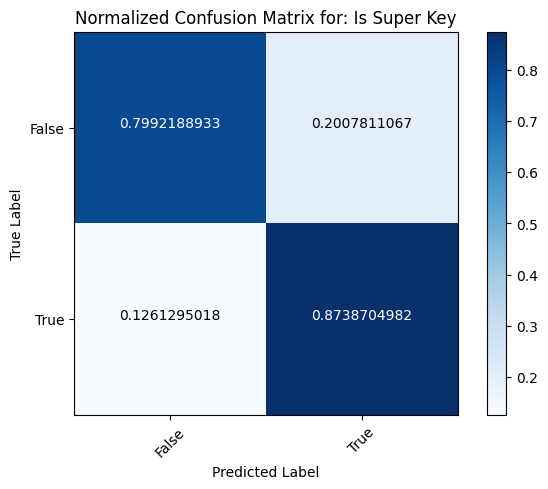

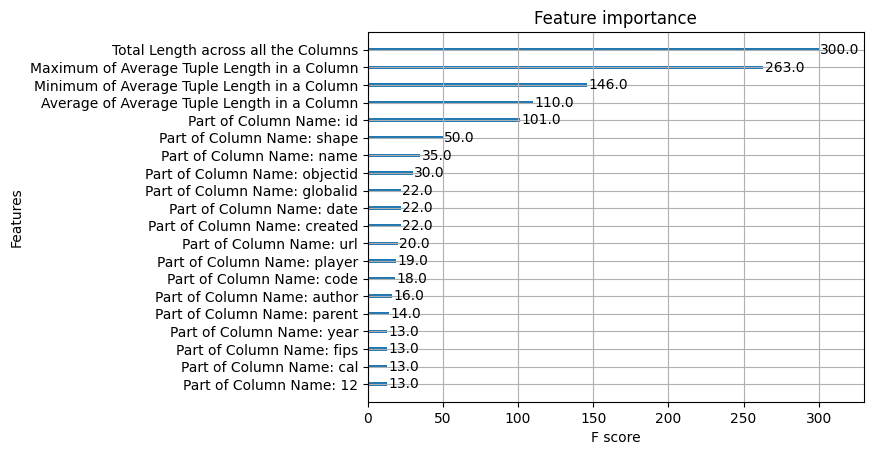

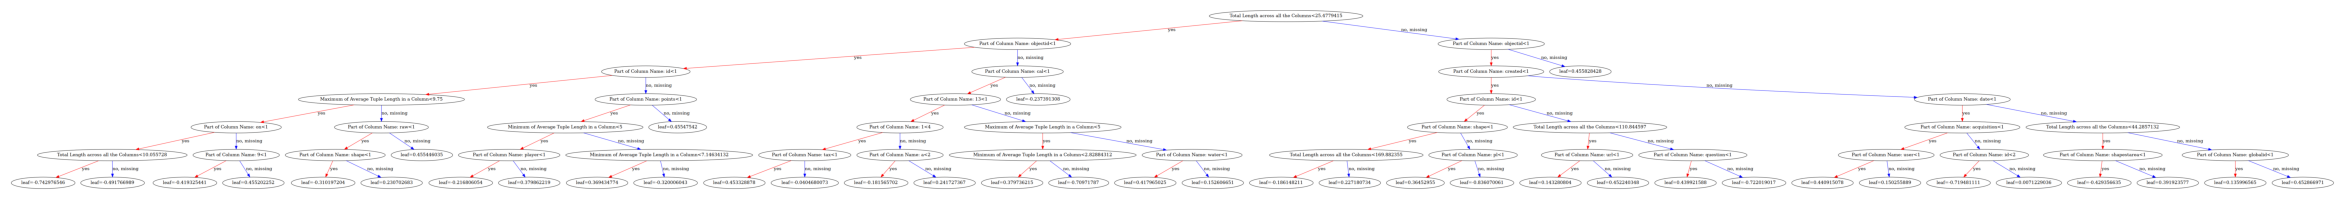

In [74]:
def column_names_bag_of_words_and_statistics_4_tuple_length():
    times_for_creation_summed = [sum(times_column_names_bag_of_words) + sum(times_column_names_concat)\
                                 + sum(times_complete_df_4_tuple_length_statistics)]

    start_of_computation = time.time()
    df_complete = df_column_names.join(df_4_tuple_length_statistics)
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, column_names_bag_of_words_and_statistics_4_tuple_length, "Is Super Key", "Column_Names_Bag_of_Words_and_Statistics_4_Tuple_Length")

In [75]:
'''def column_names_bag_of_words_and_avg_tuple_length():
    times_for_creation_summed = [sum(times_column_names_bag_of_words) + sum(times_column_names_concat)\
                                 + sum(times_creation_df_tuple_length_per_column_average) + sum(times_complete_df_4_tuple_length_statistics)]

    start_of_computation = time.time()
    df_complete = df_column_names.join(df_tuple_length_per_column_average)
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, column_names_bag_of_words_and_avg_tuple_length, "Is Super Key", "Column_Names_Bag_of_Words_and_Average_Tuple_Length")'''

temp_var = 1

Name: Column_Names_Bag_of_Words_and_Number_Attributes (Is Super Key)

Number of Boosting Rounds: 100
Number of Features: 5691

Example from the Data (Is Super Key)
Column Combination: [1]
Prediction: Propability for [False, True]: [0.8554886  0.14451139]
Is Super Key?: False



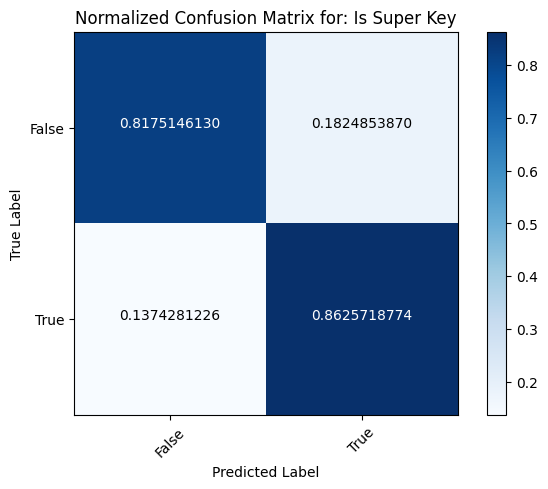

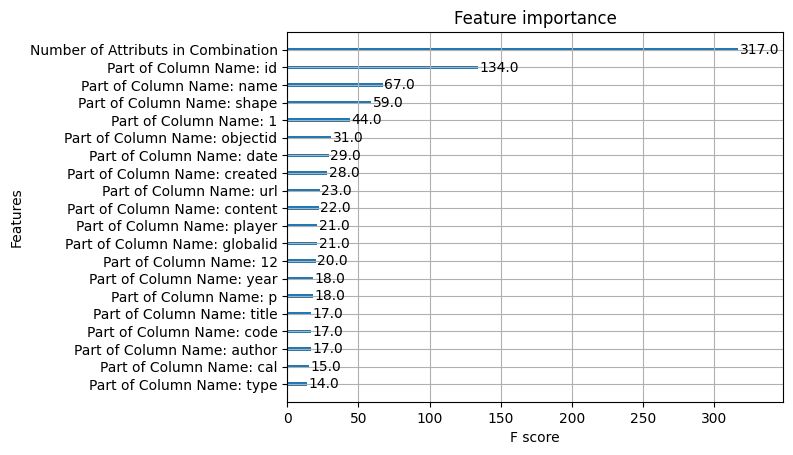

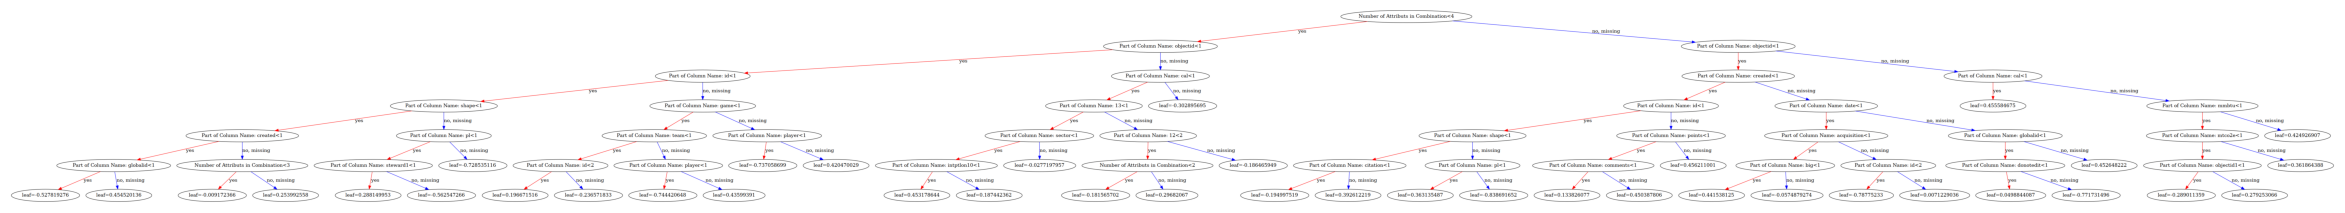

In [76]:
def column_names_bag_of_words_and_number_attributes():
    times_for_creation_summed = [sum(times_column_names_bag_of_words) + sum(times_column_names_concat)\
                                 + sum(times_creation_df_number_attributes) + sum(times_number_attributes)]

    start_of_computation = time.time()
    df_complete = df_column_names.join(df_number_attributes)
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, column_names_bag_of_words_and_number_attributes, "Is Super Key", "Column_Names_Bag_of_Words_and_Number_Attributes")

Name: Column_Names_Bag_of_Words_and_Bigrams (Is Super Key)

Number of Boosting Rounds: 100
Number of Features: 7394

Example from the Data (Is Super Key)
Column Combination: [1]
Prediction: Propability for [False, True]: [0.7501046  0.24989538]
Is Super Key?: False



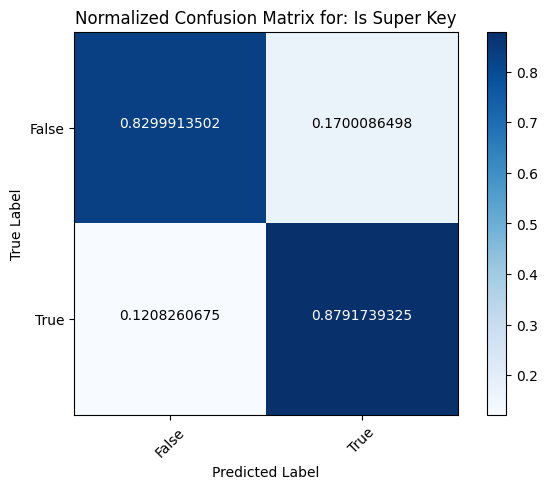

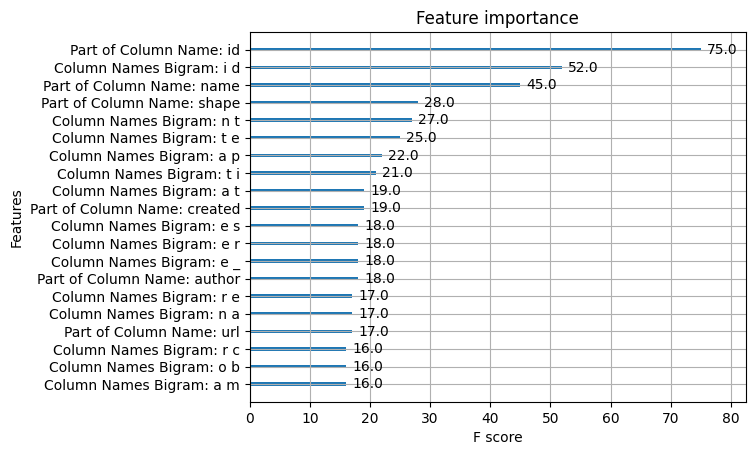

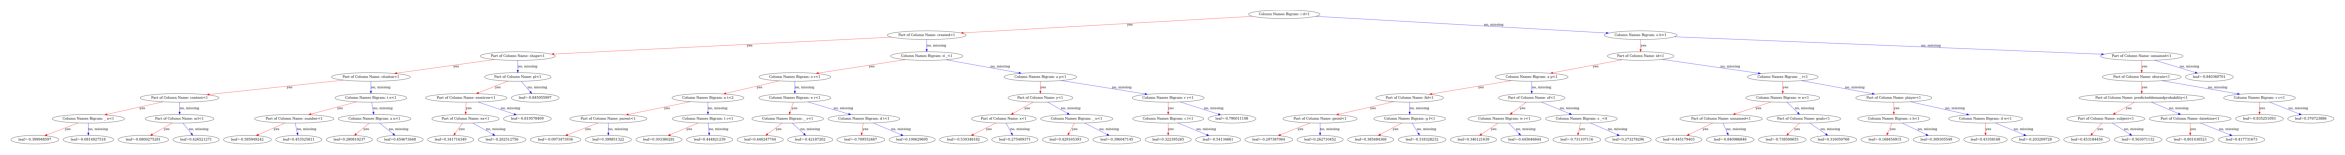

In [77]:
def column_names_bag_of_words_and_bigrams():
    times_for_creation_summed = [sum(times_column_names_bag_of_words) + sum(times_column_names_concat)\
                                 + sum(times_column_names_bigrams)]

    start_of_computation = time.time()
    df_complete = df_column_names.join(df_column_names_bigrams)
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, column_names_bag_of_words_and_bigrams, "Is Super Key", "Column_Names_Bag_of_Words_and_Bigrams")

Name: Column_Names_Bag_of_Words_and_Number_Attributes_and_Statistics_4_Tuple_Length (Is Super Key)

Number of Boosting Rounds: 100
Number of Features: 5695

Example from the Data (Is Super Key)
Column Combination: [1]
Prediction: Propability for [False, True]: [0.8710117  0.12898831]
Is Super Key?: False



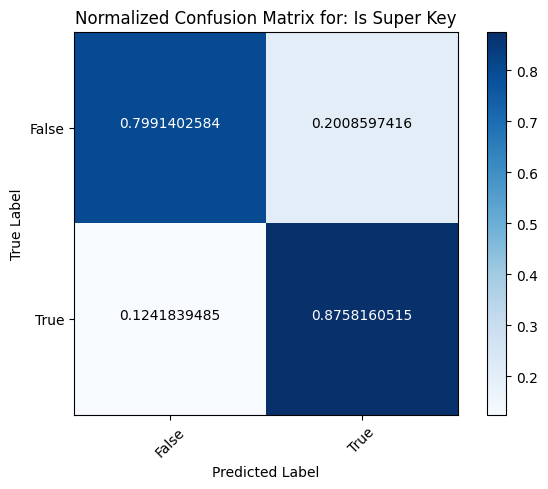

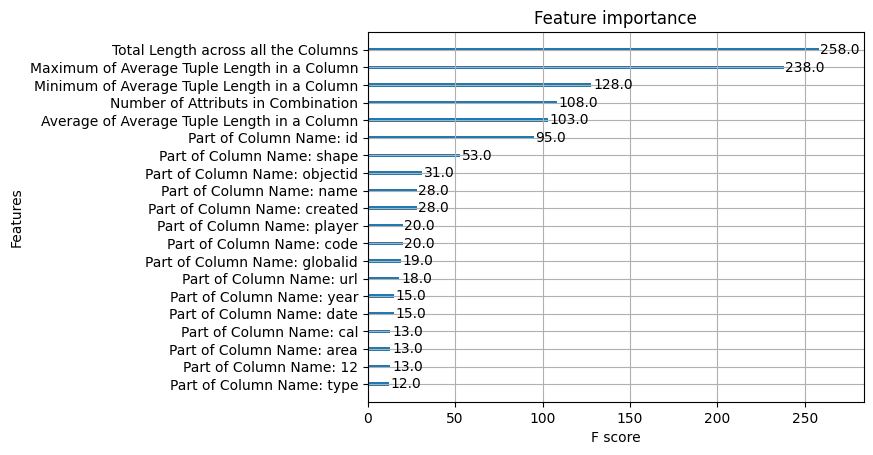

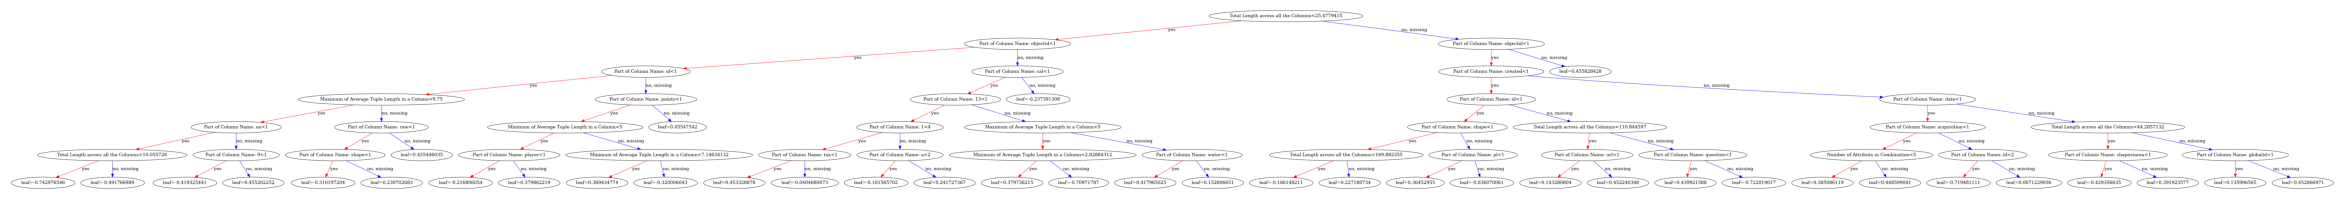

In [78]:
def column_names_bag_of_words_and_number_attributes_and_statistics_4_tuple_length():
    times_for_creation_summed = [sum(times_column_names_bag_of_words) + sum(times_column_names_concat)\
                                 + sum(times_creation_df_number_attributes) + sum(times_number_attributes)\
                                    + sum(times_complete_df_4_tuple_length_statistics)]

    start_of_computation = time.time()
    df_complete = df_column_names.join(df_number_attributes).join(df_4_tuple_length_statistics)
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, column_names_bag_of_words_and_number_attributes_and_statistics_4_tuple_length, "Is Super Key", "Column_Names_Bag_of_Words_and_Number_Attributes_and_Statistics_4_Tuple_Length")

Name: Number_Attributes (Is Super Key)

Number of Boosting Rounds: 100
Number of Features: 1

Example from the Data (Is Super Key)
Column Combination: [1]
Prediction: Propability for [False, True]: [0.8129835  0.18701646]
Is Super Key?: False



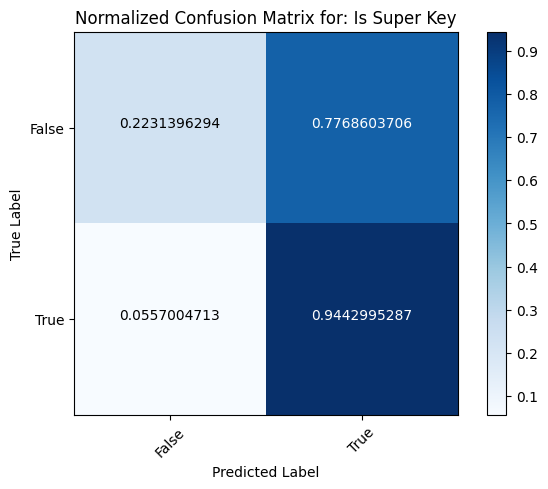

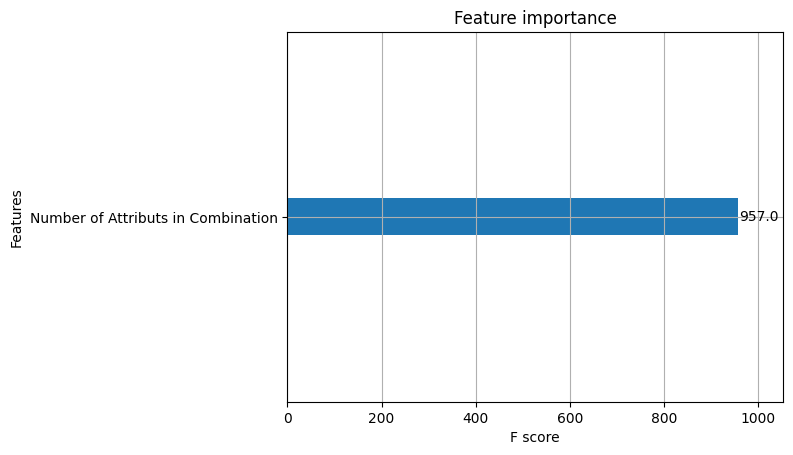

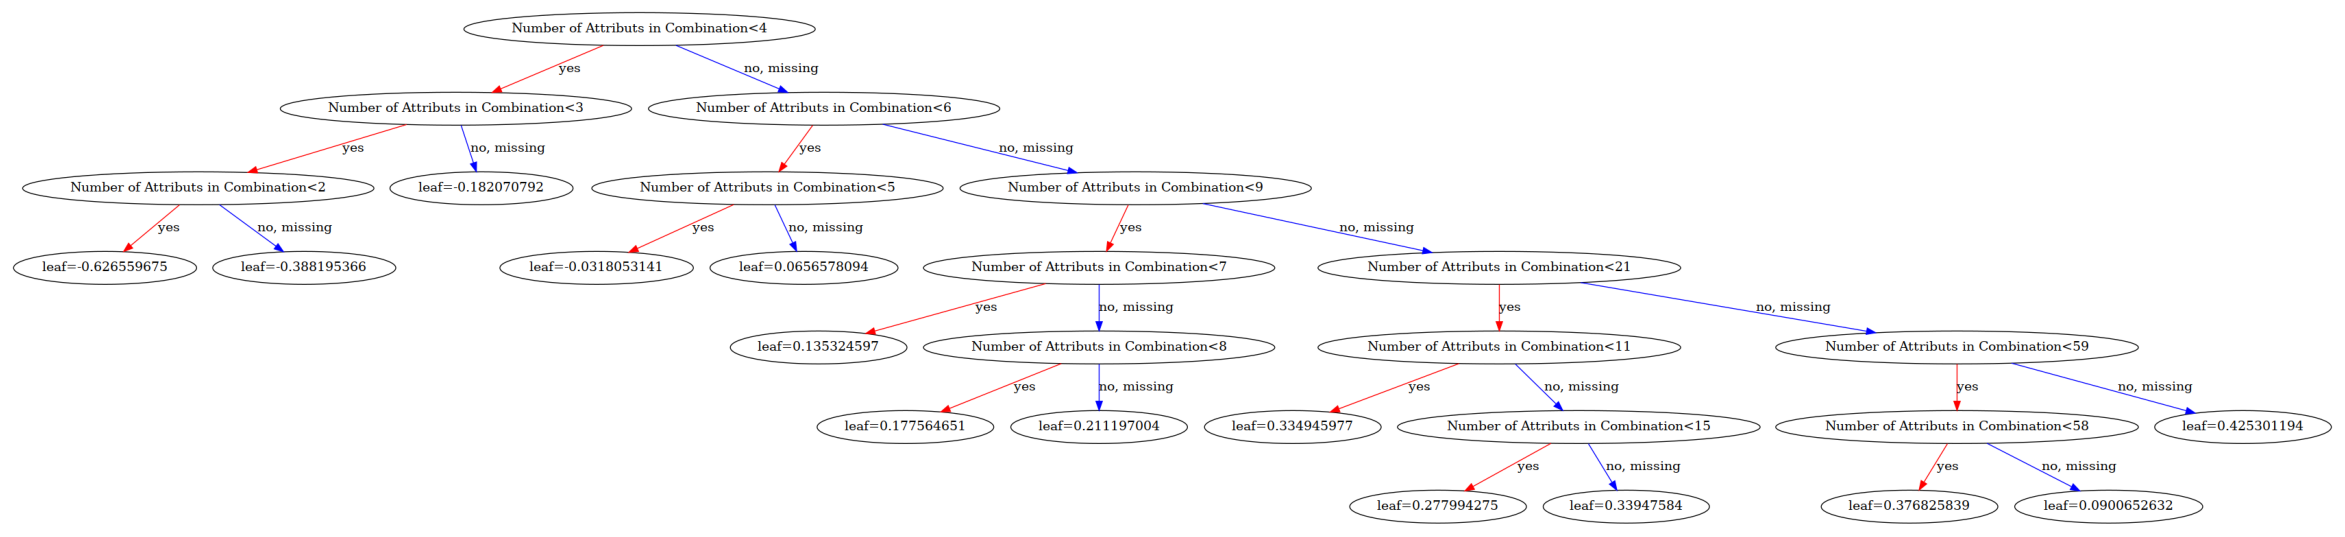

In [79]:
def number_attributes():
    times_for_creation_summed = [sum(times_creation_df_number_attributes) + sum(times_number_attributes)]

    start_of_computation = time.time()
    df_complete = df_number_attributes
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, number_attributes, "Is Super Key", "Number_Attributes")

Name: Total_Number_of_Columns_in_OG_Table (Is Super Key)

Number of Boosting Rounds: 100
Number of Features: 1

Example from the Data (Is Super Key)
Column Combination: [1]
Prediction: Propability for [False, True]: [0.36651784 0.63348216]
Is Super Key?: False



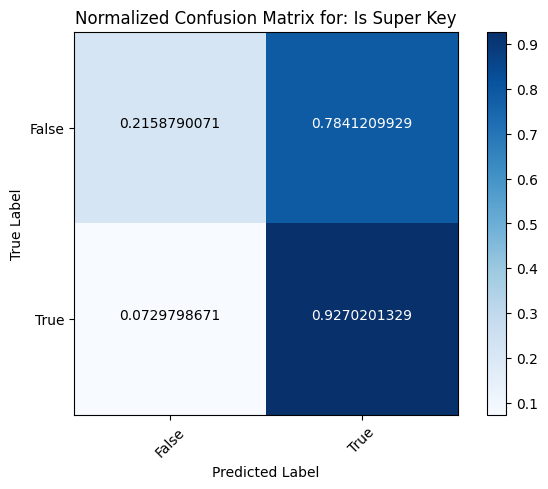

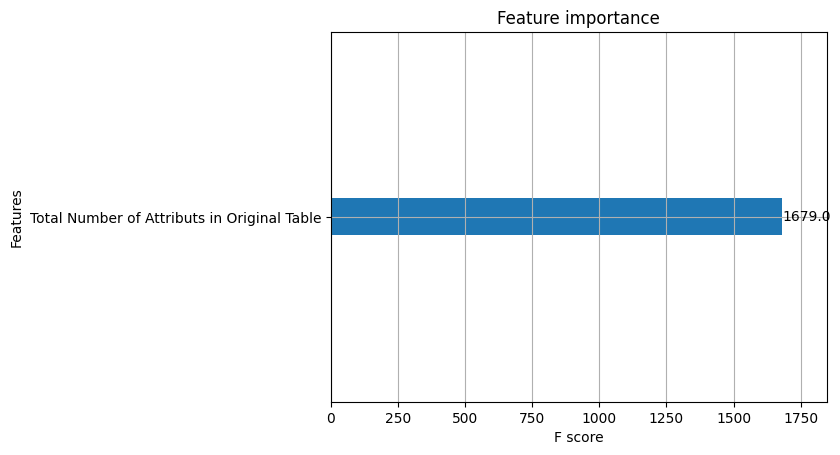

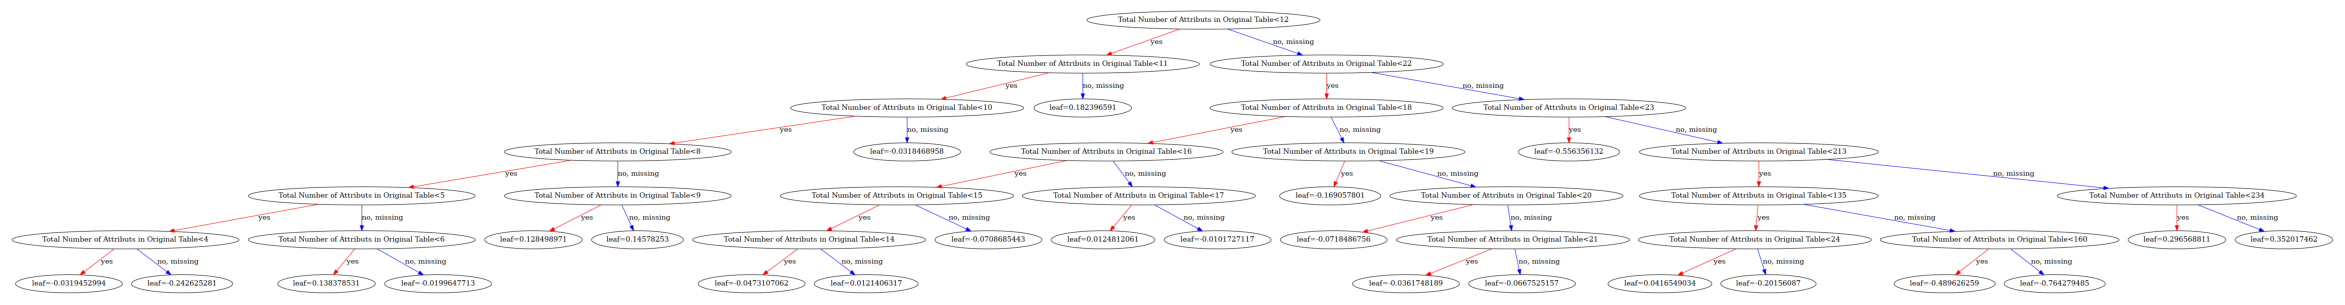

In [80]:
def total_num_columns():
    times_for_creation_summed = [sum(times_creation_df_total_num_columns) + sum(times_total_num_columns)]

    start_of_computation = time.time()
    df_complete = df_total_num_columns
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, total_num_columns, "Is Super Key", "Total_Number_of_Columns_in_OG_Table")

Name: 4_Tuple_Length_Statistics (Is Super Key)

Number of Boosting Rounds: 100
Number of Features: 4

Example from the Data (Is Super Key)
Column Combination: [1]
Prediction: Propability for [False, True]: [0.8756914  0.12430856]
Is Super Key?: False



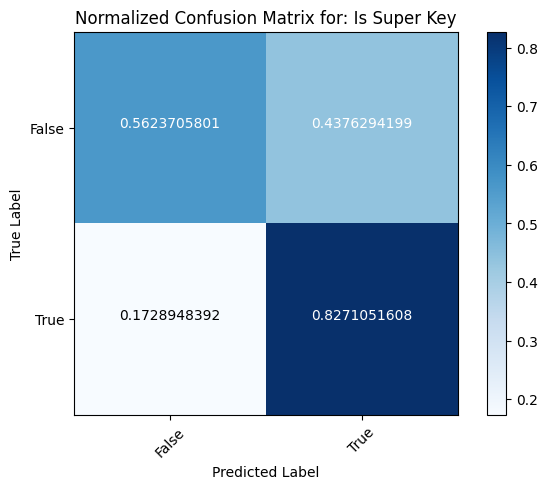

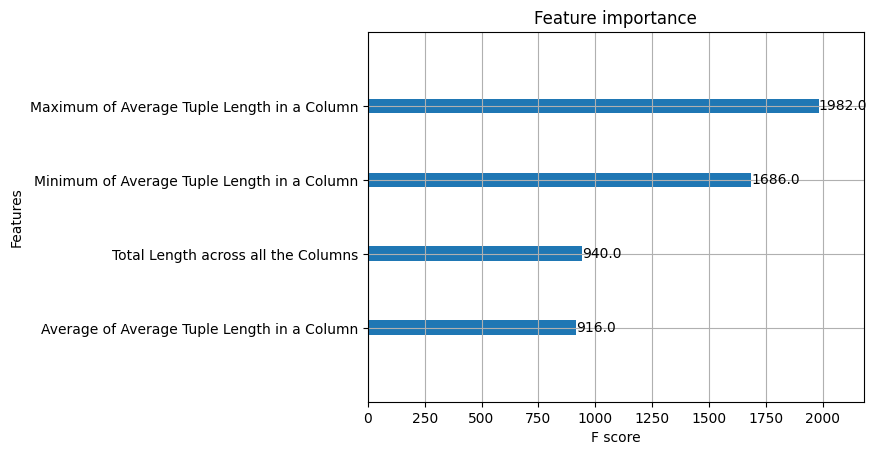

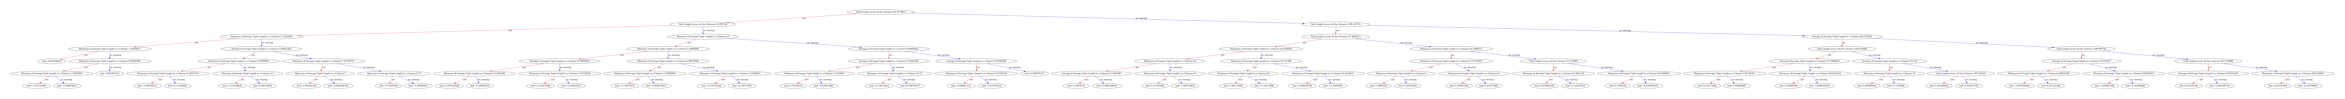

In [81]:
def statistics_4_tuple_length():
    times_for_creation_summed = [sum(times_creation_df_4_tuple_length_statistics) + sum(times_4_tuple_length_statistics) + sum(times_concat_of_content_column)]

    start_of_computation = time.time()
    df_complete = df_4_tuple_length_statistics
    end_of_computation = time.time()
    time_for_computation = end_of_computation - start_of_computation
    times_summed = [sum(times_for_creation_summed) + time_for_computation]

    return df_complete, times_summed

train_with_phi_and_plot(xgboost_model, statistics_4_tuple_length, "Is Super Key", "4_Tuple_Length_Statistics")

### All 10 (/15) DataFrames I created to combine

df_49_statistics,
df_4_nan_statistics,
df_4_tuple_length_statistics


df_attribute_percentage,
df_number_attributes,
df_total_num_columns

df_column_names,
df_column_names_bag_of_chars,
df_column_names_bigrams

df_data_types




()





(df_tuples_bag_of_chars,
df_tuples_bigrams,
df_avg_avg_tuple_length,
df_total_tuple_length,
df_tuple_length_per_column_average)

In [82]:
if not results_super:
    results_super['No Values'] = {sort_results_by: 'Nothing'}
df_results = pd.DataFrame(results_super).sort_values(by = sort_results_by, axis = 1, ascending = False).T
####################


####################
#Transfor to dict to add Percentages of (Non-)Superkeys, then transform back
temp_dict = df_results.to_dict(orient = 'index')
nothing = {
    "Amount of Features": '%.10f' % 0,
    "Avg Comp.-Time per Combination": '%.10f' % 0,
    "F1-Score": '%.10f' % 0,
    "Precision": '%.10f' % 0,
    "Precision for Negatives": '%.10f' % 0,
    "Recall": '%.10f' % 0,
    "Recall for Negatives": '%.10f' % 0,
    "Cross-Entropy": '%.10f' % 0,
    "Balanced Accuracy": '%.10f' % 0,
    "Accuracy": '%.10f' % 0,
    "ROC-AUC-Score": '%.10f' % 0,
}
percentage_superkey = new_df[new_df['Is Super Key'] == True].shape[0] / new_df.shape[0]
percentage_non_superkey = new_df[new_df['Is Super Key'] == False].shape[0] / new_df.shape[0]
temp_dict[f'Percentage Superkeys: {percentage_superkey}'] = nothing
temp_dict[f'Percentage Non-Superkeys: {percentage_non_superkey}'] = nothing

times_superkey_properties_avg = sum(times_superkey_properties) / new_df.shape[0]
temp_dict[f'Avg Comp.-Time per Combination with pandas.duplicated() on all Tuples: {times_superkey_properties_avg}'] = nothing

df_results = pd.DataFrame(temp_dict).T
####################


####################
if do_saving:
    df_results.to_csv(path_save_results, index = False)
df_results

Amount of Features  \
All_Features                                                     7517   
Column_Names_Bag_of_Chars_with_5_more_2                          1776   
Column_Names_Bag_of_Chars_with_5_more_1                          5762   
Number_Attributes_with_4_more_2                                  1717   
Number_Attributes_with_4_more_1                                  5703   
Column_Names_Bigrams_and_Bag_of_Chars                            1763   
Data_Types_and_Column_Names_Bigrams                              1708   
Column_Names_Bag_of_Words_and_Bigrams                            7394   
Column_Names_Bag_of_Chars_with_4_more                              72   
Column_Names_Bag_of_Chars_with_3_more                              68   
Column_Names_Bag_of_Words_and_Bag_of_Chars                       5749   
Data_Types_and_Column_Names_Bag_of_Words                         5694   
Column_Names_Bag_of_Words_and_Number_Attributes...               5695   
53_Statistics                                                      53   
49_Statistics                                                      49   
Column_Names_Bigrams                                             1704   
Column_Names_Bag_of_Words_and_Statistics_4_Tupl...               5694   
Column_Names_Bag_of_Chars_and_Number_Attributes                    60   
Column_Names_Bag_of_Chars                                          59   
Data_Types                                                          4   
Column_Names_Bag_of_Words_and_Number_Attributes                  5691   
Column_Names_Bag_of_Words                                        5690   
Number_Attributes_with_2_more                                       9   
Statistics_4_Tuple_Length_and_Number_Attributes                     5   
4_Tuple_Length_Statistics                                           4   
Attribute_Number_and_NaN                                            7   
4_NaN_Statistics                                                    4   
3_Number_Attributes_Statistics                                      3   
Number_Attributes                                                   1   
Total_Number_of_Columns_in_OG_Table                                 1   
Percentage Superkeys: 0.645238980844337                  0.0000000000   
Percentage Non-Superkeys: 0.354761019155663              0.0000000000   
Avg Comp.-Time per Combination with pandas.dupl...       0.0000000000   

                                                   Avg Comp.-Time per Combination  \
All_Features                                                         0.0110502343   
Column_Names_Bag_of_Chars_with_5_more_2                              0.0070112256   
Column_Names_Bag_of_Chars_with_5_more_1                              0.0067672858   
Number_Attributes_with_4_more_2                                      0.0052715456   
Number_Attributes_with_4_more_1                                      0.0049925858   
Column_Names_Bigrams_and_Bag_of_Chars                                0.0046510502   
Data_Types_and_Column_Names_Bigrams                                  0.0045769878   
Column_Names_Bag_of_Words_and_Bigrams                                0.0045500303   
Column_Names_Bag_of_Chars_with_4_more                                0.0037796245   
Column_Names_Bag_of_Chars_with_3_more                                0.0037513297   
Column_Names_Bag_of_Words_and_Bag_of_Chars                           0.0034848037   
Data_Types_and_Column_Names_Bag_of_Words                             0.0033564152   
Column_Names_Bag_of_Words_and_Number_Attributes...                   0.0033200927   
53_Statistics                                                        0.0025677073   
49_Statistics                                                        0.0025416407   
Column_Names_Bigrams                                                 0.0024131751   
Column_Names_Bag_of_Words_and_Statistics_4_Tupl...                   0.0018714282   
Column_Names_Bag_of_Chars_and_Number_A